# A Data Analysis of College Women in STEM Studies

### Gioia Dominedo, Amy Lee and Kendrick Lo

<img src='img/header.jpg'>

# Table of Contents
1. [Background and Motivation](#section1)
2. [Data Collection](#section2)
3. [Exploratory Analysis](#section3)
4. [Feature Engineering](#section4)
5. [Additional Data Preparation](#section5)
6. [Logistic Regression Models](#section6)
7. [Decision Tree and Random Forest Models](#section7)
8. [Subgroup Analysis](#section8)
9. [Prediction Tool](#section9)
10. [Discussion and Takeaways](#section10)

<div class="alert alert-info">
<p><strong>Documentation Referenced</strong></p>
<ul>
<li>AC209 HW3, Lab 7, Lab 11</li>
<li>Sebastian Raschka, <i>Python Machine Learning</i></li>
<li>Sebastian Raschka, Github and Blog (http://sebastianraschka.com/Articles/2014_python_lda.html)</li>
<li>Hui Zou and Trevor Hastie, <i>Regularization and Variable Selection via the Elastic Net</i> (http://web.stanford.edu/~hastie/TALKS/enet_talk.pdf)</li>
</ul>
</div>

 <a id = "section1"></a>
 ## 1. Background and Motivation

While women in the US today earn over 50% of bachelor's degrees, reports estimate that they only account for 25% or fewer of students earning degrees in science, technology, engineering and math (or STEM, for short). There has been no shortage of media coverage recently speculating about the causes of this imbalance, and discussing why it is an important issue. As STEM students ourselves, we strongly believe that including a more diverse range of people - not only women, but also other under-represented minorities - can enrich creativity and broaden the impact of innovation.

Armed with US Census microdata, we set out to investigate whether we could identify personal or household level features that make a female student more likely to choose to major in a STEM field, and to build a predictive model based on these features.

**Initial Questions:**
* Which personal and household level variables are correlated with a female student's decision to major in a STEM field or not?
* Can we use these variables to build regression and machine learning models that predict whether female students will major in a STEM field?
* Can we carry out peer analysis to determine whether these key variables differ across female and male students?
* Can we turn our classifiers into a prediction tool for female students' choice of major?
* Finally, can we identify key takeaways on how to encourage more female students to major in STEM subjects?

 <a id = "section2"></a>
 ## 2. Data Collection

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
# Defined for easy access
colorPalette = sns.color_palette()
snsBlue = colorPalette[0]
snsGreen = colorPalette[1]
snsRed = colorPalette[2]
snsPurple = colorPalette[3]
snsYellow = colorPalette[4]
snsAzure = colorPalette[5]

### 2.1 Data Source

The data for this project was obtained from the <a href='https://usa.ipums.org'>Integrated Public Use Microdata Series</a> (IPUMS), which is maintained by the University of Minnesota. IPUMS consists of sample microdata from US censuses dating back to 1850. The available data for each census represents approximately 1% of the total population.

The key advantage of working with this data is the incredibly high level of granularity, as we are working with individual records as opposed to working with summary census statistics. The main drawback is that the data only represents a small percentage of the overall population; however, the dataset is nonetheless very large (~3 million records per census). The number of potential features is also significant: for example there are 20+ demographic variables, 10+ education variables, 20+ income variables, etc.

We considered whether certain types of people might be more or less likely to respond to a census, thereby introducing bias to the data. However, responding to a census request is required by law, with a minimum fine of $5,000 for failing to complete the form or for answering questions falsely. For this reason we believe that any bias created by individual non-responses is likely to be negligible.

We chose to use data from the most recent US census, which was carried out in 2010. The data is not available via an API and can only be downloaded as an ASCII file, so we had to take the following steps in order to obtain a file that we could load into our iPython notebook.

* First, we submitted a query at the IPUMS-USA website for all available 2010 US census microdata. The result of the query was an ASCII data file and an associated STATA syntax file.
* We then loaded the ASCII data file into STATA (using the companion syntax file) and exported it as a CSV file (~12.2GB). A zipped version (~1.28GB) of this file is available <a href='https://copy.com/31nVAgdrBtZcgADm'>here</a>.

**Source:** Steven Ruggles, J. Trent Alexander, Katie Genadek, Ronald Goeken, Matthew B. Schroeder, and Matthew Sobek. Integrated Public Use Microdata Series: Version 5.0 [Machine-readable database]. Minneapolis, MN: Minnesota Population Center [producer and distributor], 2010.

### 2.2 Identifying the Relevant Population

<div class="alert alert-danger">
<strong>Note:</strong> The following lines of code require the entire 2010 US Census data file.
</div>

In [6]:
# this is all the US census microdata for 2010 before any filtering
df = pd.read_csv('data/acs_2010_all_fields.csv')

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (176,217,275,309) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [7]:
df.shape

(3061692, 434)

In [8]:
df.dtypes

rectype         object
year             int64
datanum          int64
serial           int64
numprec         object
subsamp         object
hhwt             int64
hhtype          object
repwt            int64
cluster          int64
adjust         float64
cpi99          float64
region          object
stateicp        object
statefip        object
county           int64
countyfips       int64
metro           object
metarea         object
metaread        object
city            object
cityerr         object
citypop          int64
puma             int64
pumares2mig      int64
strata           int64
pumasupr         int64
conspuma         int64
appal           object
appald          object
                ...   
repwtp51         int64
repwtp52         int64
repwtp53         int64
repwtp54         int64
repwtp55         int64
repwtp56         int64
repwtp57         int64
repwtp58         int64
repwtp59         int64
repwtp60         int64
repwtp61         int64
repwtp62         int64
repwtp63   

The first step was to identify the relevant population for our research question. We started by extracting all college undergraduates at the time of the census and adding indicator variables for:
* current college undergraduate
* female
* majoring in STEM (either primary or secondary field)

In [9]:
# let's just look at college students
college = df[df['gradeatt']=='College undergraduate']
college.shape

(168113, 434)

In [10]:
# get college students where main degreefield is not blank: 13,139 records
college_with_deg = college[college['degfield'] != '0']
college_with_deg.shape

(13139, 434)

In [11]:
# these are the subjects that are considered STEM
stem = ['Computer and Information Sciences', 'Engineering', 'Engineering Technologies', 
        'Biology and Life Sciences', 'Mathematics and Statistics', 'Physical Sciences', 
        'Nuclear, Industrial Radiology, and Biological Technologies']

In [12]:
cdeg = college_with_deg.copy()
cdeg['i_p_female'] = (college_with_deg.sex=='Female') * 1
cdeg['i_p_stem'] = (college_with_deg.degfield.isin(stem) | college_with_deg.degfield2.isin(stem)) * 1
cdeg['i_p_college'] = 1

In [13]:
cdeg.shape

(13139, 437)

Our research goal was to identify both personal and household characteristics that may influence a female student's decision to major in a STEM field, so the next step was to extract all the household members of those same college undergraduates.

In [14]:
# get unique household numbers of college undergrads
household_serial_num = cdeg.serial.unique()

In [15]:
len(household_serial_num)

12627

In [16]:
# get people in households, remove those in college undergrad to prevent duplicates with cdeg
household=df[df.serial.isin(household_serial_num)]
hh_nocollege = household[household['gradeatt']!='College undergraduate']

In [17]:
hh_nocollege.shape

(22525, 434)

In [18]:
# add same indicator variables
hh = hh_nocollege.copy()
hh['i_p_female'] = (hh.sex=='Female') * 1
hh['i_p_stem'] = (hh.degfield.isin(stem) | hh.degfield2.isin(stem)) * 1
hh['i_p_college'] = 0

Finally, we combined the two dataframes into a single dataframe and save it for later use.

In [19]:
dftouse = pd.concat([hh, cdeg])

In [20]:
dftouse.shape

(35664, 437)

In [21]:
dftouse.head()

,rectype,year,datanum,serial,numprec,subsamp,hhwt,hhtype,repwt,cluster,adjust,cpi99,region,stateicp,statefip,county,countyfips,metro,metarea,metaread,city,cityerr,citypop,puma,pumares2mig,strata,pumasupr,conspuma,appal,appald,homeland,cntry,gq,gqtype,gqtyped,farm,ownershp,ownershpd,mortgage,mortgag2,commuse,farmprod,acrehous,mortamt1,mortamt2,taxincl,insincl,propinsr,proptx99,owncost,...,repwtp34,repwtp35,repwtp36,repwtp37,repwtp38,repwtp39,repwtp40,repwtp41,repwtp42,repwtp43,repwtp44,repwtp45,repwtp46,repwtp47,repwtp48,repwtp49,repwtp50,repwtp51,repwtp52,repwtp53,repwtp54,repwtp55,repwtp56,repwtp57,repwtp58,repwtp59,repwtp60,repwtp61,repwtp62,repwtp63,repwtp64,repwtp65,repwtp66,repwtp67,repwtp68,repwtp69,repwtp70,repwtp71,repwtp72,repwtp73,repwtp74,repwtp75,repwtp76,repwtp77,repwtp78,repwtp79,repwtp80,i_p_female,i_p_stem,i_p_college
168,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,53,107,14,57,59,65,57,58,88,101,56,52,60,92,16,101,53,15,17,14,58,107,15,55,56,58,56,48,97,89,54,66,56,89,17,102,51,16,15,14,59,96,16,55,54,54,53,1,0,0
169,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,78,180,28,87,101,103,94,91,155,136,70,94,107,138,19,155,79,26,29,29,95,167,29,84,84,92,101,72,122,151,96,93,74,152,24,199,98,24,28,24,83,152,28,91,93,85,88,0,0,0
170,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,67,144,17,80,76,84,68,74,134,111,66,66,98,100,17,125,71,19,23,19,73,107,21,73,65,68,68,62,119,168,73,63,64,117,21,117,84,17,20,18,66,131,22,74,64,65,60,1,0,0
230,H,2010,1,105,3,81,62,"Male householder, no wife present",1,2010000001051,1.007624,0.764,East South Central Div.,Alabama,Alabama,0,0,"In metro area, central / principal city","Montgomery, AL","Montgomery, AL","Montgomery, AL",0%,2067,1900,19,190001,1500,5,Not in Appalachia,Not in Appalachia,PUMA does not include a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed

In [24]:
# save smaller dataframe for later use
dftouse.to_csv('data/dftouse3.csv') 

<div class="alert alert-success">
<strong>Note:</strong> From this point on, all the code can be run using the web links to the relevant CSV files.
</div>

 <a id = "section3"></a>
 ## 3. Exploratory Analysis

Before going any further, we carried out exploratory data analysis on the college students in our dataset using <a href='http://www.tableau.com/'>Tableau Desktop</a>.

It is worth noting that all the visualizations below only relate to the sub-sample of 13,139 college students in our dataset, and are not necessarily completely representative of the entire US college population.

**Are women going to college?**

<img src='img/college_gender.png' width=75%>

Women are not shying away from higher education. That's great!

**Are women getting into STEM programs?**

<img src='img/college_stem_gender.png' width=65%>

While female students account for nearly two-thirds of students majoring in non-STEM subjects, they only represent 42% of students majoring in STEM subjects. Still, that's not too bad.  But what if you look at it in a different way?

<img src='img/stem_female.png' width=55%>

Only 13% of female college students choose to pursue studies in a STEM major.

**Does the age distribution of STEM and non-STEM majors vary?**

<img src='img/women_stem_age.png' width=80%>

We were surprised the see the very wide distribution of ages for college students, and decided to explore this further in later steps.

**Does the race of STEM and non-STEM majors vary?**

<img src='img/race_bar.png' width=80%>

<img src='img/race_table.png' width=75%>

<img src='img/race_pies.png' width=80%>

At first glance, Chinese students seem to be the largest proportion (about one third) and Native American the lowest (less than 5%), though some sub-samples are too small to make any reasonable inference. Most others are in the 10-20% range.

**Does the first language of STEM and non-STEM majors vary?**

<img src='img/lang_logbar.png' width=80%>

<img src='img/lang_logcircle.png' width=90%>

There were no major insights to be gained from this graph.

**Does the family composition of STEM and non-STEM majors vary?**

<img src='img/famsize.png' width=80%>

<img src='img/siblings.png' width=55%>

It is unclear whether these provide any interesting insights without further analysis. In particular, it is important to note that the data only considers family members **within the same household**, so it may or may not capture the size and make-up of an individual's immediate family depending on whether they are living within the same household. It will be worth bearing this is mind when analyzing household level features.

**Do the economic characteristics of STEM and non-STEM majors vary?**

<img src='img/income_hist.png' width=85%>

<img src='img/income_pies.png' width=80%>

The first two graphs are skewed toward lower incomes, which is not surprising. We had originally suspected that there might be an association between income levels and the choice of fields of study - if there is, it is not clear from these graphs.

<img src='img/stem_mean.png' width=25%>

<img src='img/stem_hh.png' width=60%>

In further examining the income distribution, we noticed that there were a few 999999 values that were distorting results so we made a note to examine this in more detail later.

<img src='img/poverty.png' width=70%>

The above graph presents family income as a percentage of the poverty threshold. Not surprisingly, we found that there are more people in college from higher income families, which is consistent with these families being able to afford to send their children to college.

<img src='img/poverty_circles.png' width=60%>

We found that the previous graph was a bit misleading with respect to points less than the poverty threshold, so we converted to 'above the threshold' and 'below the threshold' in the above graph. We found this a clearer way to display the much larger proportion of students from families above the proverty line, regardless of their choice of major.

**Do the geographic characteristics of STEM and non-STEM majors vary?**

<img src='img/metro.png' width=35%>

<img src='img/map_1.png' width=90%>

<img src='img/map_2.png' width=90%>

<img src='img/map_3.png' width=35%>

We initially speculated that students living in areas that are more exposed to STEM fields (e.g. near technology hubs) may be more likely to study such subjects themselves. However, there does not seem to be any noticeable difference by state.

When examining these graphs, we also considered that individuals in different life circumstances may be classified under either their "home" state or the state where they are living to attend college, making a like-for-like comparison more difficult.

 <a id = "section4"></a>
 ## 4. Feature Engineering

### 4.1 Feature Engineering - Individual Records

By this point, we had reduced our dataset to ~13,000 college students with a declared major and ~22,000 individuals that are part of those students' households. The next step was to examine the data for any data quality issues (e.g. missing data or inconsistent types) and to narrow down the full list of 434 features in order to reduce the complexity of the prediction models that we planned to build.

In [3]:
# use locally stored file
df3 = pd.read_csv('data/dftouse3.csv')

# use web-based file (~142MB)
# df3 = pd.read_csv('https://copy.com/66pRRJSh1jDtNczk')

df3.drop('Unnamed: 0', axis=1, inplace=True)

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (5,197,218,276) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
df3.shape

(35664, 437)

In [5]:
# sort by household for easier viewing
df3 = df3.sort(['serial', 'pernum']).reset_index(drop=True)
df3.head()

,rectype,year,datanum,serial,numprec,subsamp,hhwt,hhtype,repwt,cluster,adjust,cpi99,region,stateicp,statefip,county,countyfips,metro,metarea,metaread,city,cityerr,citypop,puma,pumares2mig,strata,pumasupr,conspuma,appal,appald,homeland,cntry,gq,gqtype,gqtyped,farm,ownershp,ownershpd,mortgage,mortgag2,commuse,farmprod,acrehous,mortamt1,mortamt2,taxincl,insincl,propinsr,proptx99,owncost,...,repwtp34,repwtp35,repwtp36,repwtp37,repwtp38,repwtp39,repwtp40,repwtp41,repwtp42,repwtp43,repwtp44,repwtp45,repwtp46,repwtp47,repwtp48,repwtp49,repwtp50,repwtp51,repwtp52,repwtp53,repwtp54,repwtp55,repwtp56,repwtp57,repwtp58,repwtp59,repwtp60,repwtp61,repwtp62,repwtp63,repwtp64,repwtp65,repwtp66,repwtp67,repwtp68,repwtp69,repwtp70,repwtp71,repwtp72,repwtp73,repwtp74,repwtp75,repwtp76,repwtp77,repwtp78,repwtp79,repwtp80,i_p_female,i_p_stem,i_p_college
0,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,58,103,14,72,63,56,63,66,92,97,67,59,62,82,18,104,62,17,16,20,71,101,17,72,72,51,49,63,132,134,70,62,56,96,20,117,59,18,17,16,56,95,18,55,58,64,55,0,1,1
1,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,53,107,14,57,59,65,57,58,88,101,56,52,60,92,16,101,53,15,17,14,58,107,15,55,56,58,56,48,97,89,54,66,56,89,17,102,51,16,15,14,59,96,16,55,54,54,53,1,0,0
2,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,78,180,28,87,101,103,94,91,155,136,70,94,107,138,19,155,79,26,29,29,95,167,29,84,84,92,101,72,122,151,96,93,74,152,24,199,98,24,28,24,83,152,28,91,93,85,88,0,0,0
3,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage

**4.1.1 Delete Fields**

We used the US Census documentation to familarize ourselves with the many variables and to identify the most relevant ones for our research question. Our findings and rationale for excluding fields are summarized <a href='doc/excluded_features.md'>here</a>.

In [6]:
columns_to_drop = ['related', 'rectype', 'year', 'datanum', 'numprec', 'subsamp', 'hhtype', 'repwt', 
                   'cluster', 'adjust', 'cpi99', 'region', 'stateicp', 'statefip', 'county', 'countyfips',
                   'metro', 'metarea', 'metaread', 'city', 'cityerr', 'citypop', 'puma', 'pumares2mig',
                   'strata', 'pumasupr', 'conspuma','appal', 'appald', 'homeland', 'cntry', 'gq', 'gqtype',
                   'gqtyped', 'farm', 'ownershp', 'mortgag2','commuse', 'farmprod', 'acrehous', 'mortamt1',
                   'mortamt2', 'taxincl', 'insincl', 'propinsr', 'proptx99', 'owncost', 'rentgrs', 'rentmeal',
                   'condofee', 'moblhome', 'costfuel', 'vacancy', 'kitchen', 'fridge', 'sink', 'stove', 'rooms',
                   'plumbing', 'hotwater', 'shower', 'toilet','builtyr2', 'unitsstr', 'phone', 'fuelheat',
                   'nsubfam', 'ncouples', 'multgend', 'cbnsubfam', 'repwt1', 'repwt2', 'repwt3', 'repwt4',
                   'repwt5', 'repwt6', 'repwt7', 'repwt8', 'repwt9', 'repwt10', 'repwt11', 'repwt12', 'repwt13',
                   'repwt14', 'repwt15', 'repwt16', 'repwt17', 'repwt18', 'repwt19', 'repwt20', 'repwt21', 
                   'repwt22', 'repwt23', 'repwt24', 'repwt25', 'repwt26', 'repwt27', 'repwt28', 'repwt29',
                   'repwt30', 'repwt31', 'repwt32', 'repwt33', 'repwt34', 'repwt35', 'repwt36', 'repwt37',
                   'repwt38', 'repwt39', 'repwt40', 'repwt41', 'repwt42', 'repwt43', 'repwt44', 'repwt45', 
                   'repwt46', 'repwt47', 'repwt48', 'repwt49', 'repwt50', 'repwt51', 'repwt52', 'repwt53',
                   'repwt54', 'repwt55', 'repwt56', 'repwt57', 'repwt58', 'repwt59', 'repwt60', 'repwt61',
                   'repwt62', 'repwt63', 'repwt64', 'repwt65', 'repwt66', 'repwt67', 'repwt68', 'repwt69',
                   'repwt70', 'repwt71', 'repwt72', 'repwt73', 'repwt74', 'repwt75', 'repwt76', 'repwt77',
                   'repwt78', 'repwt79', 'repwt80', 'respmode', 'slwt', 'repwtp', 'nchlt5', 'famunit', 
                   'eldch', 'yngch', 'stepmom', 'momrule', 'steppop', 'poprule', 'sprule', 'subfam', 'sftype',
                   'sfrelate', 'cbsubfam', 'cbsftype','cbsfrelate', 'relate', 'sex', 'birthqtr', 'birthyr',
                   'marrno', 'marrinyr', 'yrmarr', 'divinyr', 'widinyr', 'fertyr', 'race', 'raced', 'hispand',
                   'bpld', 'ancestr1', 'ancestr1d', 'ancestr2', 'ancestr2d', 'yrnatur',
                   'yrsusa1', 'yrsusa2', 'languaged', 'tribe', 'tribed', 'racesing', 'racesingd', 'racnum',
                   'hcovpriv', 'hinsemp', 'hinspur', 'hinstri', 'hcovpub', 'hinscaid', 'hinscare', 'hinsva', 
                   'hinsihs', 'hiufpgbase', 'hiufpginc', 'hiurule', 'hiuid', 'hiunpers', 'educ', 'gradeatt',
                   'gradeattd', 'degfield', 'degfieldd', 'degfield2', 'degfield2d', 'empstatd', 'labforce', 
                   'occ1950', 'occ1990', 'occ2010', 'ind', 'ind1950', 'ind1990', 'classwkr', 'occsoc',
                   'indnaics', 'wkswork2', 'uhrswork', 'absent', 'looking', 'availble', 'wrkrecal', 'workedyr',
                   'ftotinc', 'incwage', 'incbus00', 'incss', 'incwelfr', 'incinvst', 'incretir', 'incsupp',
                   'incother', 'incearn', 'occscore', 'sei', 'hwsei', 'presgl', 'prent', 'erscor50', 'erscor90',
                   'edscor50', 'edscor90', 'npboss50', 'npboss90', 'migrate1', 'migrate1d', 'migplac1',
                   'migmet1', 'migtype1', 'migcity1', 'migpums1', 'migpuma1', 'movedin', 'vetstat', 'vet01ltr',
                   'vet90x01', 'vet75x90', 'vet80x90', 'vet75x80', 'vetvietn', 'vet55x64', 'vetkorea',
                   'vet47x50', 'vetwwii', 'vetother', 'pwstate2', 'pwmetro', 'pwcity', 'pwtype', 'pwpuma00',
                   'pwpumas', 'tranwork', 'carpool', 'riders', 'trantime', 'departs', 'arrives', 'gchouse',
                   'gcmonths', 'gcrespon', 'probai', 'probapi', 'probblk', 'proboth', 'probwht', 'repwtp1',
                   'repwtp2', 'repwtp3', 'repwtp4', 'repwtp5', 'repwtp6', 'repwtp7', 'repwtp8', 'repwtp9',
                   'repwtp10', 'repwtp11', 'repwtp12','repwtp13', 'repwtp14', 'repwtp15', 'repwtp16', 'repwtp17',
                   'repwtp18', 'repwtp19', 'repwtp20', 'repwtp21', 'repwtp22', 'repwtp23', 'repwtp24', 'repwtp25',
                   'repwtp26', 'repwtp27', 'repwtp28', 'repwtp29', 'repwtp30', 'repwtp31', 'repwtp32', 'repwtp33',
                   'repwtp34', 'repwtp35', 'repwtp36', 'repwtp37', 'repwtp38', 'repwtp39', 'repwtp40', 'repwtp41',
                   'repwtp42', 'repwtp43', 'repwtp44', 'repwtp45', 'repwtp46', 'repwtp47', 'repwtp48', 'repwtp49',
                   'repwtp50', 'repwtp51', 'repwtp52', 'repwtp53', 'repwtp54', 'repwtp55', 'repwtp56', 'repwtp57', 
                   'repwtp58', 'repwtp59', 'repwtp60', 'repwtp61', 'repwtp62', 'repwtp63', 'repwtp64', 'repwtp65',
                   'repwtp66', 'repwtp67', 'repwtp68', 'repwtp69', 'repwtp70', 'repwtp71', 'repwtp72', 'repwtp73',
                   'repwtp74', 'repwtp75', 'repwtp76', 'repwtp77', 'repwtp78', 'repwtp79', 'repwtp80']

In [7]:
# focus on key fields
df3_firstpass = df3.drop(columns_to_drop, axis=1)
df3_firstpass.head()

,serial,hhwt,ownershpd,mortgage,rent,costelec,costgas,costwatr,hhincome,foodstmp,valueh,lingisol,bedrooms,vehicles,nfams,nmothers,nfathers,multgen,pernum,perwt,famsize,nchild,nsibs,momloc,poploc,sploc,age,marst,hispan,bpl,citizen,yrimmig,language,speakeng,racamind,racasian,racblk,racpacis,racwht,racother,hcovany,school,educd,schltype,empstat,occ,classwkrd,inctot,poverty,vetdisab,diffrem,diffphys,diffmob,diffcare,diffsens,diffeye,diffhear,vetstatd,i_p_female,i_p_stem,i_p_college
0,80,60,Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt",0,2400,9993,30,87000,No,165000,Not linguistically isolated,3,3,1 family or N/A,1,1,2 generations,1,60,4,2,0 siblings,0,0,2,33,"Married, spouse present",Not Hispanic,Alabama,NaN,0,English,"Yes, speaks only English",No,No,Yes,No,No,No,With health insurance coverage,"Yes, in school",Bachelor's degree,Public school,Employed,1360,"Wage/salary, private",45000,396,NaN,No cognitive difficulty,No ambulatory difficulty,No independent living difficulty,No,No vision or hearing difficulty,No,No,No military service,0,1,1
1,80,60,Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt",0,2400,9993,30,87000,No,165000,Not linguistically isolated,3,3,1 family or N/A,1,1,2 generations,2,56,4,2,0 siblings,0,0,1,27,"Married, spouse present",Not Hispanic,Alabama,NaN,0,English,"Yes, speaks only English",No,No,Yes,No,No,No,With health insurance coverage,"No, not in school","Associate's degree, type not specified",Not enrolled,Employed,3500,"Wage/salary, private",42000,396,NaN,No cognitive difficulty,No ambulatory difficulty,No independent living difficulty,No,No vision or hearing difficulty,No,No,No military service,1,0,0
2,80,60,Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt",0,2400,9993,30,87000,No,165000,Not linguistically isolated,3,3,1 family or N/A,1,1,2 generations,3,88,4,0 children present,1 sibling,2,1,0,Less than 1 year old,Never married/single,Not Hispanic,Alabama,NaN,0,N/A or blank,N/A (Blank),No,No,Yes,No,No,No,With health insurance coverage,NaN,NaN,NaN,NaN,0,NaN,9999999,396,NaN,NaN,NaN,NaN,NaN,No vision or hearing difficulty,No,No,NaN,0,0,0
3,80,60,Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt",0,2400,9993,30,87000,No,165000,Not linguistically isolated,3,3,1 family or N/A,1,1,2 generations,4,69,4,0 children present,1 sibling,2,1,0,Less than 1 year old,Never married/single,Not Hispanic,Alabama,NaN,0,N/A or blank,N/A (Blank),No,No,Yes,No,No,No,With health insurance coverage,NaN,NaN,NaN,NaN,0,NaN,9999999,396,NaN,NaN,NaN,NaN,NaN,No vision or hearing difficulty,No,No,NaN,1,0,0
4,105,62,Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt",0,2160,480,600,25200,No,56000,Not linguistically isolated,4 (4+ in 1960),2,1 family or N/A,0 mothers or N/A,1,2 generations,1,61,3,2,0 siblings,0,0,0,53,Divorced,Not Hispanic,Alabama,NaN,0,English,"Yes, speaks only English",No,No,Yes,No,No,No,No health insurance coverage,"No, not in school",No schooling completed,Not enrolled,Unemployed,6515,"Wage/salary, private",12200,147,NaN,No cognitive difficulty,No ambulatory difficulty,No independent living difficulty,No,No vision or hearing difficulty,No,No,No military service,0,0,0


**4.1.2 Convert Binary Fields to Indicator Variables**

These indicator variables are intended to represented whether an individual associates with a certain field/type sufficiently to self-identify. Consequently, any blank fields were treated as negative responses and converted to zeros.

In [8]:
# keep track of indicator variables
INDICATOR_VARS = ['i_p_female', 'i_p_stem', 'i_p_college']

In [9]:
# create home ownership indicator variable
# ownershpd -> i_hh_own_house (owned = 1, otherwise = 0)
df3_firstpass.ownershpd = df3_firstpass.ownershpd.replace(['Owned with mortgage or loan', 'Owned free and clear'], 1)
df3_firstpass.ownershpd = df3_firstpass.ownershpd.replace(['With cash rent', 'No cash rent'], 0)

df3_firstpass = df3_firstpass.rename(columns={'ownershpd': 'i_hh_own_house'})
INDICATOR_VARS.append('i_hh_own_house')

In [10]:
# create mortgage indicator variable
# mortgage -> i_hh_mortgage (mortgage = 1, otherwise = 0)
df3_firstpass.mortgage = df3_firstpass.mortgage.replace(['Yes, mortgaged/ deed of trust or similar debt', 
                                                         'Yes, contract to purchase'], 1)
df3_firstpass.mortgage = df3_firstpass.mortgage.replace(['No, owned free and clear', np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'mortgage': 'i_hh_mortgage'})
INDICATOR_VARS.append('i_hh_mortgage')

In [11]:
# create foodstamp indicator variable
# foodstmp -> i_hh_food_stamp (Yes = 1, otherwise = 0)
df3_firstpass.foodstmp = df3_firstpass.foodstmp.replace(['Yes'], 1)
df3_firstpass.foodstmp = df3_firstpass.foodstmp.replace(['No'], 0)

df3_firstpass = df3_firstpass.rename(columns={'foodstmp': 'i_hh_food_stamp'})
INDICATOR_VARS.append('i_hh_food_stamp')

In [12]:
# create linguistic isolation indicator variable
# lingisol -> i_hh_linguistic_isolation (Linguistically isolated = 1, otherwise = 0)
df3_firstpass.lingisol = df3_firstpass.lingisol.replace(['Linguistically isolated'], 1)
df3_firstpass.lingisol = df3_firstpass.lingisol.replace(['Not linguistically isolated',
                                                         'N/A (group quarters/vacant)'], 0)
df3_firstpass = df3_firstpass.rename(columns={'lingisol': 'i_hh_linguistic_isolation'})
INDICATOR_VARS.append('i_hh_linguistic_isolation')

In [13]:
# create indicator variable for number of children
# nchild -> i_p_have_kids (have 1 or more children = 1, otherwise = 0)
df3_firstpass.nchild = df3_firstpass.nchild.replace(['1 child present', 2, '2', 3, '3', 4, '4', 5, '5', 
                                                     6, '6', 7, '7', 8, '8', '9+'], 1)
df3_firstpass.nchild = df3_firstpass.nchild.replace(['0 children present'], 0)

df3_firstpass = df3_firstpass.rename(columns={'nchild': 'i_p_have_kids'})
INDICATOR_VARS.append('i_p_have_kids')

In [14]:
# create indicator variable for marital status
# marst -> i_p_married (Married, spouse present = 1, otherwise = 0)
df3_firstpass.marst = df3_firstpass.marst.replace(['Married, spouse present'], 1)
df3_firstpass.marst = df3_firstpass.marst.replace(['Never married/single',
                                                   'Married, spouse absent',
                                                   'Divorced', 
                                                   'Widowed',
                                                   'Separated'], 0)

df3_firstpass = df3_firstpass.rename(columns={'marst': 'i_p_married'})
INDICATOR_VARS.append('i_p_married')

In [15]:
# create indicator variable for US citizen
# citizen -> i_p_us_citizen (blanks indicate citizens)
df3_firstpass.citizen = df3_firstpass.citizen.replace(['Born abroad of American parents', 'Naturalized citizen',
                                                       np.nan], 1)
df3_firstpass.citizen = df3_firstpass.citizen.replace(['Not a citizen'], 0)

df3_firstpass = df3_firstpass.rename(columns={'citizen': 'i_p_us_citizen'})
INDICATOR_VARS.append('i_p_us_citizen')

In [16]:
# create indicator variable for born in USA
# bpl -> i_p_born_usa (Born in USA = 1, otherwise = 0)
df3_firstpass.bpl = df3_firstpass.bpl.replace(['Mississippi', 'Wyoming', 'Minnesota', 'Illinois', 'Indiana', 
                                               'Louisiana', 'Texas', 'Kansas', 'Connecticut', 'West Virginia', 
                                               'New Hampshire', 'Alaska', 'Missouri', 'South Dakota', 
                                               'New Jersey', 'Washington', 'Maryland', 'Iowa', 'Michigan', 
                                               'Oregon', 'Montana', 'Massachusetts', 'Florida', 'Rhode Island', 
                                               'Ohio', 'North Carolina', 'District of Columbia', 'Maine', 
                                               'Oklahoma', 'Delaware', 'Arkansas', 'New Mexico', 'California', 
                                               'Georgia', 'North Dakota', 'Pennsylvania', 'Nebraska', 'Colorado', 
                                               'New York', 'Nevada', 'Idaho', 'Utah', 'Virginia', 'South Carolina', 
                                               'Vermont', 'Hawaii', 'Kentucky', 'Arizona', 'Wisconsin', 'Alabama', 
                                               'Tennessee'], 1)
df3_firstpass.bpl = df3_firstpass.bpl.replace(['Canada', 'Lithuania', 'Other USSR/Russia', 'Saudi Arabia', 
                                               'American Samoa', 'Spain', 'Netherlands', 'Albania', 'England', 
                                               'Guam', 'India', 'Israel/Palestine', 'Asia, nec/ns', 'Turkey', 
                                               'Afghanistan', 'Americas, n.s.', 'France', 'Laos', 'Norway', 
                                               'Korea', 'Singapore', 'China', 'West Indies', 'Germany', 'Finland', 
                                               'Indonesia', 'AFRICA', 'Sweden', 'Vietnam', 'Bulgaria', 'Romania', 
                                               'Portugal', 'Malaysia', 'Austria', 'Japan', 'U.S. Virgin Islands', 
                                               'Kuwait', 'Scotland', 'Ireland', 'Syria', 'Iran', 'Puerto Rico', 
                                               'Belgium', 'Thailand', 'Iraq', 'Pacific Islands', 'Denmark', 
                                               'Philippines', 'Estonia', 'Lebanon', 'United Kingdom, ns', 
                                               'Atlantic Islands', 'Italy', 'Nepal', 'Other, nec', 
                                               'Cambodia (Kampuchea)', 'Iceland', 'Czechoslovakia', 'SOUTH AMERICA', 
                                               'Jordan', 'Europe, ns', 'Poland', 'East Asia, ns', 'Hungary', 
                                               'Australia and New Zealand', 'Mexico', 'Central America', 'Cuba', 
                                               'Latvia', 'Yugoslavia', 'Greece', 'Swizterland', 
                                               'Yemen Arab Republic (North)'], 0)

df3_firstpass = df3_firstpass.rename(columns={'bpl': 'i_p_born_usa'})
INDICATOR_VARS.append('i_p_born_usa')

In [17]:
# create indicator variable for immigrants
# yrimmig -> i_p_immigrant (yrimmig is a year = 1, otherwise = 0)
df3_firstpass.yrimmig = df3_firstpass.yrimmig.replace([1920, 1929, 1932, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 
                                                       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 
                                                       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 
                                                       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 
                                                       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 
                                                       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 
                                                       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 
                                                       2006, 2007, 2008, 2009, 2010], 1)

df3_firstpass = df3_firstpass.rename(columns={'yrimmig': 'i_p_immigrant'})
INDICATOR_VARS.append('i_p_immigrant')

In [18]:
# create indicator variable for English as first language
# language -> i_english_first (English = 1, otherwise = 0)
df3_firstpass.language = df3_firstpass.language.replace(['English'], 1)
df3_firstpass.language = df3_firstpass.language.replace(['Swedish', 'Hebrew, Israeli', 'Other East/Southeast Asian', 
                                               'Keres', 'Vietnamese', 'Near East Arabic dialect', 
                                               'Filipino, Tagalog', 'Other Balto-Slavic', 'Lithuanian', 'Dutch', 
                                               'Korean', 'Persian, Iranian, Farssi', 'Czech', 'Danish', 'Indonesian', 
                                               'Miconesian, Polynesian', 'N/A or blank', 'Navajo/Navaho', 'Polish', 
                                               'Turkish', 'French', 'Magyar, Hungarian', 'Norwegian', 'African, n.s.',
                                               'Hindi and related', 'Armenian', 'Yiddish, Jewish', 'Russian', 
                                               'Burmese, Lisu, Lolo', 'Tibetan', 'Sub-Saharan Africa', 'Rumanian', 
                                               'Finnish', 'Albanian', 'Greek', 'Athapascan', 'Hamitic', 
                                               'Amharic, Ethiopian, etc.', 'Italian', 'Portuguese', 'Hawaiian', 
                                               'Chinese', 'German', 'Thai, Siamese, Lao', 'Aleut, Eskimo', 
                                               'Ukrainian, Ruthenian, Little Russian', 'Japanese', 
                                               'Serbo-Croatian, Yugoslavian, Slavonian', 'Slovak', 
                                               'Other Persian dialects', 'Other or not reported', 'Spanish', 
                                               'Dravidian', 'Arabic', 'Other Malayan', 'Native'], 0)

df3_firstpass = df3_firstpass.rename(columns={'language': 'i_p_english_first'})
INDICATOR_VARS.append('i_p_english_first')

In [19]:
# create indicator variable for fluency in english
# speakeng -> i_p_speak_english

df3_firstpass.speakeng = df3_firstpass.speakeng.replace(['N/A (Blank)', 
                                                         'Does not speak English',
                                                         'Yes, but not well'], 0)
df3_firstpass.speakeng = df3_firstpass.speakeng.replace(['Yes, speaks well',
                                                         'Yes, speaks very well',
                                                         'Yes, speaks only English'], 1)

df3_firstpass = df3_firstpass.rename(columns={'speakeng': 'i_p_speak_english'})
INDICATOR_VARS.append('i_p_speak_english')

In [20]:
# convert race fields to multiple indicator variables
# racamind/racasian/racblk/racpacis/racwht/racother: convert to indicator

df3_firstpass.hispan = df3_firstpass.hispan.replace(['Cuban', 'Mexican', 'Puerto Rican', 'Other'], 1)
df3_firstpass.racamind = df3_firstpass.racamind.replace(['Yes'], 1)
df3_firstpass.racasian = df3_firstpass.racasian.replace(['Yes'], 1)
df3_firstpass.racblk = df3_firstpass.racblk.replace(['Yes'], 1)
df3_firstpass.racpacis = df3_firstpass.racpacis.replace(['Yes'], 1)
df3_firstpass.racwht = df3_firstpass.racwht.replace(['Yes'], 1)
df3_firstpass.racother = df3_firstpass.racother.replace(['Yes'], 1)

df3_firstpass.hispan = df3_firstpass.hispan.replace(['Not Hispanic'], 0)
df3_firstpass.racamind = df3_firstpass.racamind.replace(['No'], 0)
df3_firstpass.racasian = df3_firstpass.racasian.replace(['No'], 0)
df3_firstpass.racblk = df3_firstpass.racblk.replace(['No'], 0)
df3_firstpass.racpacis = df3_firstpass.racpacis.replace(['No'], 0)
df3_firstpass.racwht = df3_firstpass.racwht.replace(['No'], 0)
df3_firstpass.racother = df3_firstpass.racother.replace(['No'], 0)

df3_firstpass = df3_firstpass.rename(columns={'hispan': 'i_p_race_hispanic',
                                              'racamind': 'i_p_race_am_indian_alaska', 
                                              'racasian': 'i_p_race_asian',
                                              'racblk': 'i_p_race_black', 
                                              'racpacis': 'i_p_race_pacific_islander', 
                                              'racwht': 'i_p_race_white', 
                                              'racother': 'i_p_race_other'
                                              })
INDICATOR_VARS.extend(['i_p_race_hispanic', 'i_p_race_am_indian_alaska', 'i_p_race_asian', 'i_p_race_black',
                       'i_p_race_pacific_islander', 'i_p_race_white', 'i_p_race_other'])

In [21]:
# Create indicator for health insurance
# hcovany -> i_p_health_insurance

df3_firstpass.hcovany = df3_firstpass.hcovany.replace(['With health insurance coverage'], 1)
df3_firstpass.hcovany = df3_firstpass.hcovany.replace(['No health insurance coverage'], 0)

df3_firstpass = df3_firstpass.rename(columns={'hcovany': 'i_p_health_insurance'})
INDICATOR_VARS.append('i_p_health_insurance')

In [22]:
# Create indicator variable for school status
# school -> i_school

df3_firstpass.school = df3_firstpass.school.replace(['Yes, in school'], 1)
df3_firstpass.school = df3_firstpass.school.replace(['No, not in school', np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'school': 'i_p_in_school'})
INDICATOR_VARS.append('i_p_in_school')

In [23]:
# create college (any level) indicator variable
# educd -> i_p_college_degree (any degree except GED = 1, otherwise 0)

df3_firstpass.educd = df3_firstpass.educd.replace(['Doctoral degree', "Bachelor's degree", 
                                                   "Professional degree beyond a bachelor's degree", 
                                                   "Master's degree", "Associate's degree, type not specified"], 1)
df3_firstpass.educd = df3_firstpass.educd.replace(['Grade 2', 'Grade 1', 'Grade 6', 'Grade 7', 'Grade 4', 
                                                   'Grade 3', 'Grade 8', 'Grade 9', 'Kindergarten', 
                                                   'GED or alternative credential', 'Grade 5', 'Grade 10', 
                                                   'Grade 11', 'Some college, but less than 1 year', 
                                                   'No schooling completed', '12th grade, no diploma', 
                                                   'Regular high school diploma', 'Nursery school, preschool', 
                                                   '1 or more years of college credit, no degree', np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'educd': 'i_p_college_degree'})
INDICATOR_VARS.append('i_p_college_degree')

In [24]:
# create private school indicator variable
# schltype -> i_p_private_school (private school = 1, otherwise 0)

df3_firstpass.schltype = df3_firstpass.schltype.replace(['Private school (1960,1990-2000,ACS,PRCS)'], 1)
df3_firstpass.schltype = df3_firstpass.schltype.replace(['Public school', 'Not enrolled', np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'schltype': 'i_p_private_school'})
INDICATOR_VARS.append('i_p_private_school')

In [25]:
# create employment indicator variable
# empstat -> i_p_employed (employed = 1, otherwise 0)

df3_firstpass.empstat = df3_firstpass.empstat.replace(['Employed'], 1)
df3_firstpass.empstat = df3_firstpass.empstat.replace(['Unemployed', 'Not in labor force', np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'empstat': 'i_p_employed'})
INDICATOR_VARS.append('i_p_employed')

In [26]:
# create STEM occupation indicator variable
# occ -> i_hh_stem_occupation (STEM occupation = 1, otherwise 0)

a = list(set(df3_firstpass.occ))
b = [110, 300, 250, 360, 1005, 1006, 1007, 1010, 1020, 1030, 1050, 1060, 1105, 1106, 1107, 1200, 1210, 1220, 1230, 
     1240, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1500, 1510, 1520, 
     1530, 1540, 1550, 1560, 1600, 1610, 1640, 1650, 1660, 1700, 1710, 1720, 1740, 1760, 1800, 1815, 1820, 1830, 
     1840, 1860, 1900, 1910, 1920, 1930, 1940, 1950, 1965, 3000, 3010, 3030, 3040, 3050, 3060, 3110, 3120, 3140, 
     3150, 3160, 3200, 3210, 3220, 3230, 3235, 3245, 3250, 3255, 3256, 3257, 3258, 3260, 3300, 3310, 3320, 3400, 
     3420, 3500, 3510, 3520, 3535, 3540, 4930]
c = list(set(a) - set(b))

df3_firstpass.occ = df3_firstpass.occ.replace(b, 1)
df3_firstpass.occ = df3_firstpass.occ.replace(c, 0)

df3_firstpass = df3_firstpass.rename(columns={'occ': 'i_p_stem_occupation'})
INDICATOR_VARS.append('i_p_stem_occupation')

In [27]:
# create self-employment indicator variable
# classwkrd -> i_hh_self_employed (self employed = 1, otherwise 0)

df3_firstpass.classwkrd = df3_firstpass.classwkrd.replace(['Self-employed, incorporated',
                                                           'Self-employed, not incorporated'], 1)
df3_firstpass.classwkrd = df3_firstpass.classwkrd.replace(['Wage/salary, private', 'Federal govt employee',
                                                           'Unpaid family worker', 'Local govt employee',
                                                           'State govt employee', 'Wage/salary at non-profit',
                                                           np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'classwkrd': 'i_p_self_employed'})
INDICATOR_VARS.append('i_p_self_employed')

In [28]:
# create disability indicator variables
# create indicators -> i_** (given disability listed = 1, otherwise 0)

df3_firstpass.vetdisab = df3_firstpass.vetdisab.replace([np.nan,
                                                         '0 percent disability rating',
                                                         'No disability rating'], 0)
df3_firstpass.vetdisab = df3_firstpass.vetdisab.replace(['10 or 20 percent disability rating', 
                                                           '30 or 40 percent',
                                                           'Has disability rating, level not reported',
                                                           '70 percent or higher',
                                                           '50 or 60 percent'], 1)

df3_firstpass.diffrem = df3_firstpass.diffrem.replace([np.nan,
                                                       'No cognitive difficulty'], 0)
df3_firstpass.diffrem = df3_firstpass.diffrem.replace(['Has cognitive difficulty'], 1)


df3_firstpass.diffphys = df3_firstpass.diffphys.replace([np.nan,
                                                         'No ambulatory difficulty'], 0)
df3_firstpass.diffphys = df3_firstpass.diffphys.replace(['Has ambulatory difficulty'], 1)

df3_firstpass.diffmob = df3_firstpass.diffmob.replace([np.nan,
                                                         'No independent living difficulty'], 0)
df3_firstpass.diffmob = df3_firstpass.diffmob.replace(['Has independent living difficulty'], 1)

df3_firstpass.diffcare = df3_firstpass.diffcare.replace([np.nan,
                                                         'No'], 0)
df3_firstpass.diffcare = df3_firstpass.diffcare.replace(['Yes'], 1)

df3_firstpass.diffsens = df3_firstpass.diffsens.replace([np.nan,
                                                         'No vision or hearing difficulty'], 0)
df3_firstpass.diffsens = df3_firstpass.diffsens.replace(['Has vision or hearing difficulty'], 1)

df3_firstpass.diffeye = df3_firstpass.diffeye.replace([np.nan,
                                                         'No'], 0)
df3_firstpass.diffeye = df3_firstpass.diffeye.replace(['Yes'], 1)

df3_firstpass.diffhear = df3_firstpass.diffhear.replace([np.nan,
                                                         'No'], 0)
df3_firstpass.diffhear = df3_firstpass.diffhear.replace(['Yes'], 1)

df3_firstpass['i_p_disability'] = ((df3_firstpass['vetdisab'] + df3_firstpass['diffrem'] + df3_firstpass['diffphys'] 
                            + df3_firstpass['diffmob'] + df3_firstpass['diffcare'] + df3_firstpass['diffsens']
                            + df3_firstpass['diffeye'] + df3_firstpass['diffhear']) > 0) * 1

df3_firstpass.drop(['vetdisab', 'diffrem', 'diffphys', 'diffmob', 'diffcare', 'diffsens', 'diffeye', 'diffhear'], 
                   axis=1, inplace=True)

INDICATOR_VARS.append('i_p_disability')

In [29]:
# create military service indicator variables
# vetstatd -> i_hh_veteran (no military service = 0, otherwise 1)

df3_firstpass.vetstatd = df3_firstpass.vetstatd.replace([np.nan,
                                                         'No military service'], 0)
df3_firstpass.vetstatd = df3_firstpass.vetstatd.replace(['   Veteran, on active duty prior to past year',
                                                         'Currently on active duty',
                                                         '   Veteran, on active duty in past year',
                                                         'Training for Reserves or National Guard only'], 1)

df3_firstpass = df3_firstpass.rename(columns={'vetstatd': 'i_p_veteran'})
INDICATOR_VARS.append('i_p_veteran')

In [30]:
df3_firstpass.head()

,serial,hhwt,i_hh_own_house,i_hh_mortgage,rent,costelec,costgas,costwatr,hhincome,i_hh_food_stamp,valueh,i_hh_linguistic_isolation,bedrooms,vehicles,nfams,nmothers,nfathers,multgen,pernum,perwt,famsize,i_p_have_kids,nsibs,momloc,poploc,sploc,age,i_p_married,i_p_race_hispanic,i_p_born_usa,i_p_us_citizen,i_p_immigrant,i_p_english_first,i_p_speak_english,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_pacific_islander,i_p_race_white,i_p_race_other,i_p_health_insurance,i_p_in_school,i_p_college_degree,i_p_private_school,i_p_employed,i_p_stem_occupation,i_p_self_employed,inctot,poverty,i_p_veteran,i_p_female,i_p_stem,i_p_college,i_p_disability
0,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1 family or N/A,1,1,2 generations,1,60,4,1,0 siblings,0,0,2,33,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,45000,396,0,0,1,1,0
1,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1 family or N/A,1,1,2 generations,2,56,4,1,0 siblings,0,0,1,27,1,0,1,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0,42000,396,0,1,0,0,0
2,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1 family or N/A,1,1,2 generations,3,88,4,0,1 sibling,2,1,0,Less than 1 year old,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,9999999,396,0,0,0,0,0
3,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1 family or N/A,1,1,2 generations,4,69,4,0,1 sibling,2,1,0,Less than 1 year old,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,9999999,396,0,1,0,0,0
4,105,62,1,1,0,2160,480,600,25200,0,56000,0,4 (4+ in 1960),2,1 family or N/A,0 mothers or N/A,1,2 generations,1,61,3,1,0 siblings,0,0,0,53,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,12200,147,0,0,0,0,0


**4.1.3 Convert Ordinary Fields to Integer Variables**

In [31]:
# keep track of integer variables
INTEGER_VARS = []

In [32]:
# number of bedrooms: convert to int
df3_firstpass.bedrooms = df3_firstpass.bedrooms.replace(['4 (4+ in 1960)'], 4)
df3_firstpass.bedrooms = df3_firstpass.bedrooms.replace(['5+ (1970-2000, ACS, PRCS)'], 5)
df3_firstpass.bedrooms = df3_firstpass.bedrooms.replace(['No bedrooms'], 0)

df3_firstpass = df3_firstpass.rename(columns={'bedrooms': 'int_hh_bedrooms'})
INTEGER_VARS.append('int_hh_bedrooms')

In [33]:
# number of vehicles: convert to int
df3_firstpass.vehicles = df3_firstpass.vehicles.replace(['1 available'], 1)
df3_firstpass.vehicles = df3_firstpass.vehicles.replace(['6 (6+, 2000, ACS and PRCS)'], 6)
df3_firstpass.vehicles = df3_firstpass.vehicles.replace(['No vehicles available'], 0)

df3_firstpass = df3_firstpass.rename(columns={'vehicles': 'int_hh_vehicles'})
INTEGER_VARS.append('int_hh_vehicles')

In [34]:
# number of families in household (nfams): convert to int
df3_firstpass.nfams = df3_firstpass.nfams.replace(['1 family or N/A'], 1)
df3_firstpass.nfams = df3_firstpass.nfams.replace(['2 families'], 2)

df3_firstpass = df3_firstpass.rename(columns={'nfams': 'int_hh_num_families'})
INTEGER_VARS.append('int_hh_num_families')

In [35]:
# number of mothers and fathers in household (nmothers/nfathers): convert to int
df3_firstpass.nmothers = df3_firstpass.nmothers.replace(['0 mothers or N/A'], 0)
df3_firstpass.nfathers = df3_firstpass.nfathers.replace(['0 fathers or N/A'], 0)

df3_firstpass = df3_firstpass.rename(columns={'nmothers': 'int_hh_num_mothers',
                                              'nfathers': 'int_hh_num_fathers'})
INTEGER_VARS.extend(['int_hh_num_mothers', 'int_hh_num_fathers'])

In [36]:
# multiple generations in household (multgen): convert to 1, 2, 3+ = 3
df3_firstpass.multgen = df3_firstpass.multgen.replace(['1 generation'], 1)
df3_firstpass.multgen = df3_firstpass.multgen.replace(['2 generations'], 2)
df3_firstpass.multgen = df3_firstpass.multgen.replace(['3+ generations'], 3)

df3_firstpass = df3_firstpass.rename(columns={'multgen': 'int_hh_num_generations'})
INTEGER_VARS.append('int_hh_num_generations')

In [37]:
# family size (famsize): convert to int
df3_firstpass.famsize = df3_firstpass.famsize.replace(['1 family member present'], 1)
df3_firstpass.famsize = df3_firstpass.famsize.replace(['2 family members present'], 2)

df3_firstpass = df3_firstpass.rename(columns={'famsize': 'int_p_family_size'})
INTEGER_VARS.append('int_p_family_size')

In [38]:
# number of siblings (nsibs): convert to int
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['0 siblings'], 0)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['1 sibling'], 1)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['2 siblings'], 2)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['3 siblings'], 3)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['4 siblings'], 4)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['5 siblings'], 5)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['6 siblings'], 6)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['7 siblings'], 7)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['8 siblings'], 8)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['9 or more siblings'], 9)

df3_firstpass = df3_firstpass.rename(columns={'nsibs': 'int_p_num_siblings'})
INTEGER_VARS.append('int_p_num_siblings')

In [39]:
# age: convert to int (treat <1 year as 1 year old)
df3_firstpass.age = df3_firstpass.age.replace(['Less than 1 year old'], 1)
df3_firstpass.age = df3_firstpass.age.replace(['90 (90+ in 1980 and 1990)'], 90)

df3_firstpass = df3_firstpass.rename(columns={'age': 'int_p_age'})
INTEGER_VARS.append('int_p_age')

In [40]:
df3_firstpass.head()

,serial,hhwt,i_hh_own_house,i_hh_mortgage,rent,costelec,costgas,costwatr,hhincome,i_hh_food_stamp,valueh,i_hh_linguistic_isolation,int_hh_bedrooms,int_hh_vehicles,int_hh_num_families,int_hh_num_mothers,int_hh_num_fathers,int_hh_num_generations,pernum,perwt,int_p_family_size,i_p_have_kids,int_p_num_siblings,momloc,poploc,sploc,int_p_age,i_p_married,i_p_race_hispanic,i_p_born_usa,i_p_us_citizen,i_p_immigrant,i_p_english_first,i_p_speak_english,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_pacific_islander,i_p_race_white,i_p_race_other,i_p_health_insurance,i_p_in_school,i_p_college_degree,i_p_private_school,i_p_employed,i_p_stem_occupation,i_p_self_employed,inctot,poverty,i_p_veteran,i_p_female,i_p_stem,i_p_college,i_p_disability
0,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1,1,1,2,1,60,4,1,0,0,0,2,33,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,45000,396,0,0,1,1,0
1,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1,1,1,2,2,56,4,1,0,0,0,1,27,1,0,1,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0,42000,396,0,1,0,0,0
2,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1,1,1,2,3,88,4,0,1,2,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,9999999,396,0,0,0,0,0
3,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1,1,1,2,4,69,4,0,1,2,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,9999999,396,0,1,0,0,0
4,105,62,1,1,0,2160,480,600,25200,0,56000,0,4,2,1,0,1,2,1,61,3,1,0,0,0,0,53,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,12200,147,0,0,0,0,0


**4.1.4 Deal with Missing Data**

As a whole, we found that the quality of the data was very high and that relatively few fields were blank. That being said, we did identify a few issues that we had to deal with before moving on to the next steps.

In [41]:
# N/A (not applicable) codes in cost of electricity
# 9993 = No charge or no electricity used (1990, 2000, 2003-onward ACS/PRCS)
# 9997 = Electricity included in rent or in condo fee (1990, 2000, 2003-onward ACS/PRCS) 
print '9993 codes: ', df3_firstpass[df3_firstpass.costelec==9993].shape[0]
print '9997 codes: ', df3_firstpass[df3_firstpass.costelec==9997].shape[0]
df3_firstpass.costelec = df3_firstpass.costelec.replace([9993, 9997], 0)

9993 codes:  320
9997 codes:  787


In [42]:
# N/A (not applicable) codes in cost of gas
# 9992 = Included in electricity payment (2003-2007 ACS/PRCS)
# 9993 = No charge or no gas used (1990, 2000, 2003-2007 ACS/PRCS) 
# 9997 = Gas included in rent or in condo fee (1990, 2000, 2003-2007 ACS/PRCS)
print '9992 codes: ', df3_firstpass[df3_firstpass.costgas==9992].shape[0]
print '9993 codes: ', df3_firstpass[df3_firstpass.costgas==9993].shape[0]
print '9997 codes: ', df3_firstpass[df3_firstpass.costgas==9997].shape[0]
df3_firstpass.costgas = df3_firstpass.costgas.replace([9992, 9993, 9997], 0)

9992 codes:  2031
9993 codes:  9674
9997 codes:  1209


In [43]:
# N/A (not applicable) codes in cost of water
# 9993 = No charge or no used (1990, 2000, 2003-onward ACS/PRCS) 
# 9997 = Water included in rent or in condo fee (1990, 2000, 2003-onward ACS/PRCS) 
print '9993 codes: ', df3_firstpass[df3_firstpass.costwatr==9993].shape[0]
print '9997 codes: ', df3_firstpass[df3_firstpass.costwatr==9997].shape[0]
df3_firstpass.costwatr = df3_firstpass.costwatr.replace([9993, 9997], 0)

9993 codes:  4338
9997 codes:  4523


In [44]:
# 9999999 (not applicable) values from house values
print df3_firstpass[(df3_firstpass.i_hh_own_house==1) & (df3_firstpass.valueh==9999999)].shape[0]
print df3_firstpass[(df3_firstpass.i_hh_own_house==0) & (df3_firstpass.valueh==9999999)].shape[0]
df3_firstpass.valueh = df3_firstpass.valueh.replace([9999999], 0)

0
9447


In [45]:
# 9999999 (not applicable) values from personal income
print df3_firstpass[df3_firstpass.inctot==9999999].shape[0]
df3_firstpass.inctot = df3_firstpass.inctot.replace([9999999], 0)

5751


In [46]:
# 157 person entries are consistently blank across all fields (just 2 examples shown below)
print df3_firstpass[(df3_firstpass.i_hh_own_house.isnull()) & (df3_firstpass.hhincome==9999999)].shape[0]

# delete these entries - acceptable as it represents <0.5% of the dataset so will not introduce material bias
blank_indices = df3_firstpass[df3_firstpass.i_hh_own_house.isnull()].index
df3_firstpass.drop(blank_indices, inplace=True)

157


**4.1.5 Update Feature Names**

We took this opportunity to rename the remaining features for ease of use. We tagged all household-level features with the prefix \_hh\_ and all individual-level features with the prefix \_p\_. In addition, indicator variables were tagged \_i\_, integer variables were tagged \_int\_ and continuous variables were tagged \_cont\_.

In [47]:
# keep track of continuous variables
df3_firstpass = df3_firstpass.rename(columns={'rent':    'cont_hh_rent',
                                             'costelec': 'cont_hh_cost_elec',
                                             'costgas':  'cont_hh_cost_gas',
                                             'costwatr': 'cont_hh_cost_water',
                                             'hhincome': 'cont_hh_income',
                                             'valueh':   'cont_hh_house_value',
                                             'inctot':   'cont_p_income',
                                             'poverty':  'cont_p_perc_poverty_threshold'
                                             })

CONTINUOUS_VARS = ['cont_hh_rent', 'cont_hh_cost_elec', 'cont_hh_cost_gas', 'cont_hh_cost_water',
                   'cont_hh_income', 'cont_hh_house_value', 'cont_p_income', 'cont_p_perc_poverty_threshold']

In [48]:
# keep track of other technical (non-feature) fields
df3_firstpass = df3_firstpass.rename(columns={'serial': 'tech_hh_id',
                                             'hhwt':    'tech_hh_weight',
                                             'pernum':  'tech_p_id',
                                             'perwt':   'tech_p_weight',
                                             'momloc':  'tech_p_mom_id',
                                             'poploc':  'tech_p_dad_id',
                                             'sploc':   'tech_p_spouse_id'})

TECHNICAL_VARS = ['tech_hh_id', 'tech_hh_weight', 
                  'tech_p_id', 'tech_p_weight', 'tech_p_mom_id', 'tech_p_dad_id', 'tech_p_spouse_id']

In [49]:
# for easier reading later on
INDICATOR_VARS.sort()
INTEGER_VARS.sort()
CONTINUOUS_VARS.sort()
TECHNICAL_VARS.sort()

In [50]:
# all fields should be integers after feature engineering
for field in INDICATOR_VARS:
    df3_firstpass[field] = df3_firstpass[field].astype(int)

for field in INTEGER_VARS:
    df3_firstpass[field] = df3_firstpass[field].astype(int)
    
for field in CONTINUOUS_VARS:
    df3_firstpass[field] = df3_firstpass[field].astype(int)
    
for field in TECHNICAL_VARS:
    df3_firstpass[field] = df3_firstpass[field].astype(int)

In [51]:
# save clean dataset
df4 = df3_firstpass.copy()
df4.to_csv('data/dftouse4.csv')

### 4.2 Feature Engineering - Related Household Entries

By this point, we had selected and cleaned the relevant features for each individual in the dataset. However, the data frame still included not only college students, but also all the household members associated with them. The next step was to create additional features relating to college students' household members, and to then delete the records related to these household members.

In [52]:
# use locally stored file
df4 = pd.read_csv('data/dftouse4.csv')

# use web-based file (~5MB)
# df4 = pd.read_csv('https://copy.com/IJavXktua7nUjthf')

df4.drop('Unnamed: 0', axis=1, inplace=True)

In [53]:
df4.shape

(35507, 54)

In [54]:
df4.head()

,tech_hh_id,tech_hh_weight,i_hh_own_house,i_hh_mortgage,cont_hh_rent,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_income,i_hh_food_stamp,cont_hh_house_value,i_hh_linguistic_isolation,int_hh_bedrooms,int_hh_vehicles,int_hh_num_families,int_hh_num_mothers,int_hh_num_fathers,int_hh_num_generations,tech_p_id,tech_p_weight,int_p_family_size,i_p_have_kids,int_p_num_siblings,tech_p_mom_id,tech_p_dad_id,tech_p_spouse_id,int_p_age,i_p_married,i_p_race_hispanic,i_p_born_usa,i_p_us_citizen,i_p_immigrant,i_p_english_first,i_p_speak_english,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_pacific_islander,i_p_race_white,i_p_race_other,i_p_health_insurance,i_p_in_school,i_p_college_degree,i_p_private_school,i_p_employed,i_p_stem_occupation,i_p_self_employed,cont_p_income,cont_p_perc_poverty_threshold,i_p_veteran,i_p_female,i_p_stem,i_p_college,i_p_disability
0,80,60,1,1,0,2400,0,30,87000,0,165000,0,3,3,1,1,1,2,1,60,4,1,0,0,0,2,33,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,45000,396,0,0,1,1,0
1,80,60,1,1,0,2400,0,30,87000,0,165000,0,3,3,1,1,1,2,2,56,4,1,0,0,0,1,27,1,0,1,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0,42000,396,0,1,0,0,0
2,80,60,1,1,0,2400,0,30,87000,0,165000,0,3,3,1,1,1,2,3,88,4,0,1,2,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,396,0,0,0,0,0
3,80,60,1,1,0,2400,0,30,87000,0,165000,0,3,3,1,1,1,2,4,69,4,0,1,2,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,396,0,1,0,0,0
4,105,62,1,1,0,2160,480,600,25200,0,56000,0,4,2,1,0,1,2,1,61,3,1,0,0,0,0,53,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,12200,147,0,0,0,0,0


**4.2.1 Create Additional Household-Level Features**

Several of the technical fields above (e.g. momloc, poploc, sploc, etc.) allow for records within a household to be linked based on people's roles. For example, momloc can be used to identify a college student's mother and look up her personal characteristics. It is important to note that these relationships are not self-reported, and that probable links (e.g. child-mother links) are imputed by IPUMS-USA.

Of the ~13,000 male and female college students in the data, only ~3,500 have an identified mother, ~3,000 have an identified father, and ~2,800 have both an identified mother record and an identified father record. Given these relatively low numbers, and for the sake of comparability across students, we decided to create our household-level features based on all household members, e.g. at least 1 household member with a college degree, as opposed to mother/father with a college degree. 

A potential extension of this project could be to focus on the subset of students that do have such identified relationships, and to see whether they have greater predictive power than the features that we build based on the overall household.

In [55]:
# do not include students to avoid mixing effects
# (i.e. want to break out incremental effect of characteristics of other household members)
df4_group = df4[df4.i_p_college==0].groupby('tech_hh_id').sum()

In [56]:
# indicator variables represent the presence of at least 1 other household member with a given feature
# for single-person households, these values are all set to 0

In [57]:
# 1+ other person with children in the household
tmp_vals = pd.DataFrame((df4_group['i_p_have_kids'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_have_kids_x': 'i_p_have_kids', 'i_p_have_kids_y': 'i_hh_have_kids'})
df4.i_hh_have_kids = df4.i_hh_have_kids.replace([np.nan], 0)
INDICATOR_VARS.append('i_hh_have_kids')

In [58]:
# 1+ other married person in household
tmp_vals = pd.DataFrame((df4_group['i_p_married'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_married_x': 'i_p_married', 'i_p_married_y': 'i_hh_married'})
df4.i_hh_married = df4.i_hh_married.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_married')

In [59]:
# 1+ other US citizen in household
tmp_vals = pd.DataFrame((df4_group['i_p_us_citizen'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_us_citizen_x': 'i_p_us_citizen', 'i_p_us_citizen_y': 'i_hh_us_citizen'})
df4.i_hh_us_citizen = df4.i_hh_us_citizen.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_us_citizen')

In [60]:
# 1+ other immigrant in household
tmp_vals = pd.DataFrame((df4_group['i_p_immigrant'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_immigrant_x': 'i_p_immigrant', 'i_p_immigrant_y': 'i_hh_immigrant'})
df4.i_hh_immigrant = df4.i_hh_immigrant.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_immigrant')

In [61]:
# 1+ other person in household fluent in english
tmp_vals = pd.DataFrame((df4_group['i_p_speak_english'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_speak_english_x': 'i_p_speak_english', 'i_p_speak_english_y': 'i_hh_speak_english'})
df4.i_hh_speak_english = df4.i_hh_speak_english.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_speak_english')

In [62]:
# 1+ other person in household with health insurance
tmp_vals = pd.DataFrame((df4_group['i_p_health_insurance'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_health_insurance_x': 'i_p_health_insurance', 'i_p_health_insurance_y': 'i_hh_health_insurance'})
df4.i_hh_health_insurance = df4.i_hh_health_insurance.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_health_insurance')

In [63]:
# 1+ other person in household in school
tmp_vals = pd.DataFrame((df4_group['i_p_in_school'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_in_school_x': 'i_p_in_school', 'i_p_in_school_y': 'i_hh_in_school'})
df4.i_hh_in_school = df4.i_hh_in_school.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_in_school')

In [64]:
# 1+ other person in household with college degree
tmp_vals = pd.DataFrame((df4_group['i_p_college_degree'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_college_degree_x': 'i_p_college_degree', 'i_p_college_degree_y': 'i_hh_college_degree'})
df4.i_hh_college_degree = df4.i_hh_college_degree.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_college_degree')

In [65]:
# 1+ other person in household with STEM college degree
tmp_vals = pd.DataFrame((df4_group['i_p_stem'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_stem_x': 'i_p_stem', 'i_p_stem_y': 'i_hh_stem'})
df4.i_hh_stem = df4.i_hh_stem.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_stem')

In [66]:
# 1+ other person in household went to private school
tmp_vals = pd.DataFrame((df4_group['i_p_private_school'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_private_school_x': 'i_p_private_school', 'i_p_private_school_y': 'i_hh_private_school'})
df4.i_hh_private_school = df4.i_hh_private_school.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_private_school')

In [67]:
# 1+ other employed person in household
tmp_vals = pd.DataFrame((df4_group['i_p_employed'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_employed_x': 'i_p_employed', 'i_p_employed_y': 'i_hh_employed'})
df4.i_hh_employed = df4.i_hh_employed.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_employed')

In [68]:
# 1+ other STEM employed person in household
tmp_vals = pd.DataFrame((df4_group['i_p_stem_occupation'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_stem_occupation_x': 'i_p_stem_occupation', 'i_p_stem_occupation_y': 'i_hh_stem_occupation'})
df4.i_hh_stem_occupation = df4.i_hh_stem_occupation.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_stem_occupation')

In [69]:
# 1+ other self-employed person in household
tmp_vals = pd.DataFrame((df4_group['i_p_self_employed'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_self_employed_x': 'i_p_self_employed', 'i_p_self_employed_y': 'i_hh_self_employed'})
df4.i_hh_self_employed = df4.i_hh_self_employed.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_self_employed')

In [70]:
# 1+ other person with disabilities in household
tmp_vals = pd.DataFrame((df4_group['i_p_disability'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_disability_x': 'i_p_disability', 'i_p_disability_y': 'i_hh_disability'})
df4.i_hh_disability = df4.i_hh_disability.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_disability')

In [71]:
# 1+ other veterans in household
tmp_vals = pd.DataFrame((df4_group['i_p_veteran'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_veteran_x': 'i_p_veteran', 'i_p_veteran_y': 'i_hh_veteran'})
df4.i_hh_veteran = df4.i_hh_veteran.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_veteran')

**4.2.2 Create Final Datasets**

While our research question is focused on factors that make female college students more likely to study STEM subjects, we were also interested in conducting peer analysis comparing female and male students. For this reason, we saved separate datasets for both genders.

In [72]:
# check datatypes
for field in INDICATOR_VARS:
    df4[field] = df4[field].astype(int)

for field in INTEGER_VARS:
    df4[field] = df4[field].astype(int)
    
for field in CONTINUOUS_VARS:
    df4[field] = df4[field].astype(int)
    
for field in TECHNICAL_VARS:
    df4[field] = df4[field].astype(int)

In [73]:
# separate out indicators that are model features
INDICATOR_VARS_MODEL = INDICATOR_VARS[:]
INDICATOR_VARS_MODEL.remove('i_p_college')
INDICATOR_VARS_MODEL.remove('i_p_female')
INDICATOR_VARS_MODEL.remove('i_p_college_degree')
INDICATOR_VARS_MODEL.remove('i_p_in_school')
INDICATOR_VARS_MODEL.remove('i_p_stem')

In [74]:
# sort for readability
df5 = df4.reindex_axis(sorted(df4.columns), axis=1)

In [75]:
# delete records that do not relate to college students
df5_all = df5[df5.i_p_college==1].reset_index(drop=True)

In [76]:
df5_all.shape

(12982, 69)

In [77]:
df5_all.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
0,2400,0,30,165000,87000,0,45000,396,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,0,1,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,1,0,3,1,1,2,1,3,33,4,0,80,60,0,1,0,2,60
1,2160,480,600,56000,25200,0,4700,147,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,4,1,1,2,0,2,20,3,1,105,62,1,2,0,0,68
2,2760,360,20,350000,135000,0,60000,501,1,0,1,0,1,1,0,1,0,1,1,1,1,0,1,0,0,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,1,0,3,1,1,2,1,2,34,4,0,160,53,0,2,0,1,51
3,0,0,0,0,26000,0,12000,106,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,2,2,0,1,0,3,22,1,0,359,16,0,1,0,0,17
4,3720,48,300,290000,231500,0,2500,501,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,4,1,1,2,1,4,24,3,0,430,84,1,3,2,0,104


In [78]:
# Split dataset into female and male students
df5_female = df5_all[df5_all.i_p_female==1]
df5_male = df5_all[df5_all.i_p_female==0]

In [79]:
df5_female.shape, df5_male.shape

((7853, 69), (5129, 69))

In [80]:
df5_female.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
1,2160,480,600,56000,25200,0,4700,147,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,4,1,1,2,0,2,20,3,1,105,62,1,2,0,0,68
5,2160,480,60,540000,131100,0,2100,501,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,4,1,1,2,1,3,21,4,1,493,76,1,3,2,0,93
6,2400,0,30,15000,24800,0,16400,191,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,4,1,0,2,1,1,45,2,0,747,27,0,2,1,0,45
7,0,0,0,0,76800,2200,4800,501,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,3,1,0,1,0,3,46,2,0,816,27,0,1,0,2,27
11,960,960,600,114000,43900,0,34500,303,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,1,0,1,0,2,28,2,0,1607,21,0,2,0,1,24


In [81]:
# save clean datasets
df5_female.to_csv('data/dftouse5female.csv')
df5_male.to_csv('data/dftouse5male.csv')

### 4.3 Exploring Feature Distributions

By this point we had constructed 40 indicator variables, 9 integer (ordinal) variables and 8 continuous variables. Before going any further, we wanted to examine the features that we had seleted and created, and see whether there were any immediately apparent links for either the female or male sub-populations.

As a reminder, our two datasets consisted of:
* 7,853 female undergraduate students (13% STEM majors)
* 5,129 male undergraduate students (26% STEM majors)

In [82]:
# use locally stored files
df5_female = pd.read_csv('data/dftouse5female.csv')
df5_male = pd.read_csv('data/dftouse5male.csv')

# use web-based files (~1.3MB for females and ~900KB for males)
# df5_female = pd.read_csv('https://copy.com/GCYuqmNCu7pZIkyw')
# df5_male = pd.read_csv('https://copy.com/NNtety3JYJcL9Mwv')

df5_female.drop('Unnamed: 0', axis=1, inplace=True)
df5_male.drop('Unnamed: 0', axis=1, inplace=True)

**4.3.1 Female Students**

In [83]:
# distribution of response variables for female students
female_STEM = df5_female[df5_female.i_p_stem==1].shape[0]
female_nonSTEM = df5_female[df5_female.i_p_stem==0].shape[0]
female_students = female_STEM + female_nonSTEM
female_students, female_STEM, female_nonSTEM

(7853, 990, 6863)

In [84]:
# Code to convert from # of observations to percentages adapted from 
# http://stackoverflow.com/questions/9767241/setting-a-relative-frequency-in-a-matplotlib-histogram
# and http://stackoverflow.com/questions/26294360/pyplot-using-percentage-on-x-axis
# Used to aid comparability of the positive and negative responses given different sample sizes

# Code to tweak tick label size adapted from
# http://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

//anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


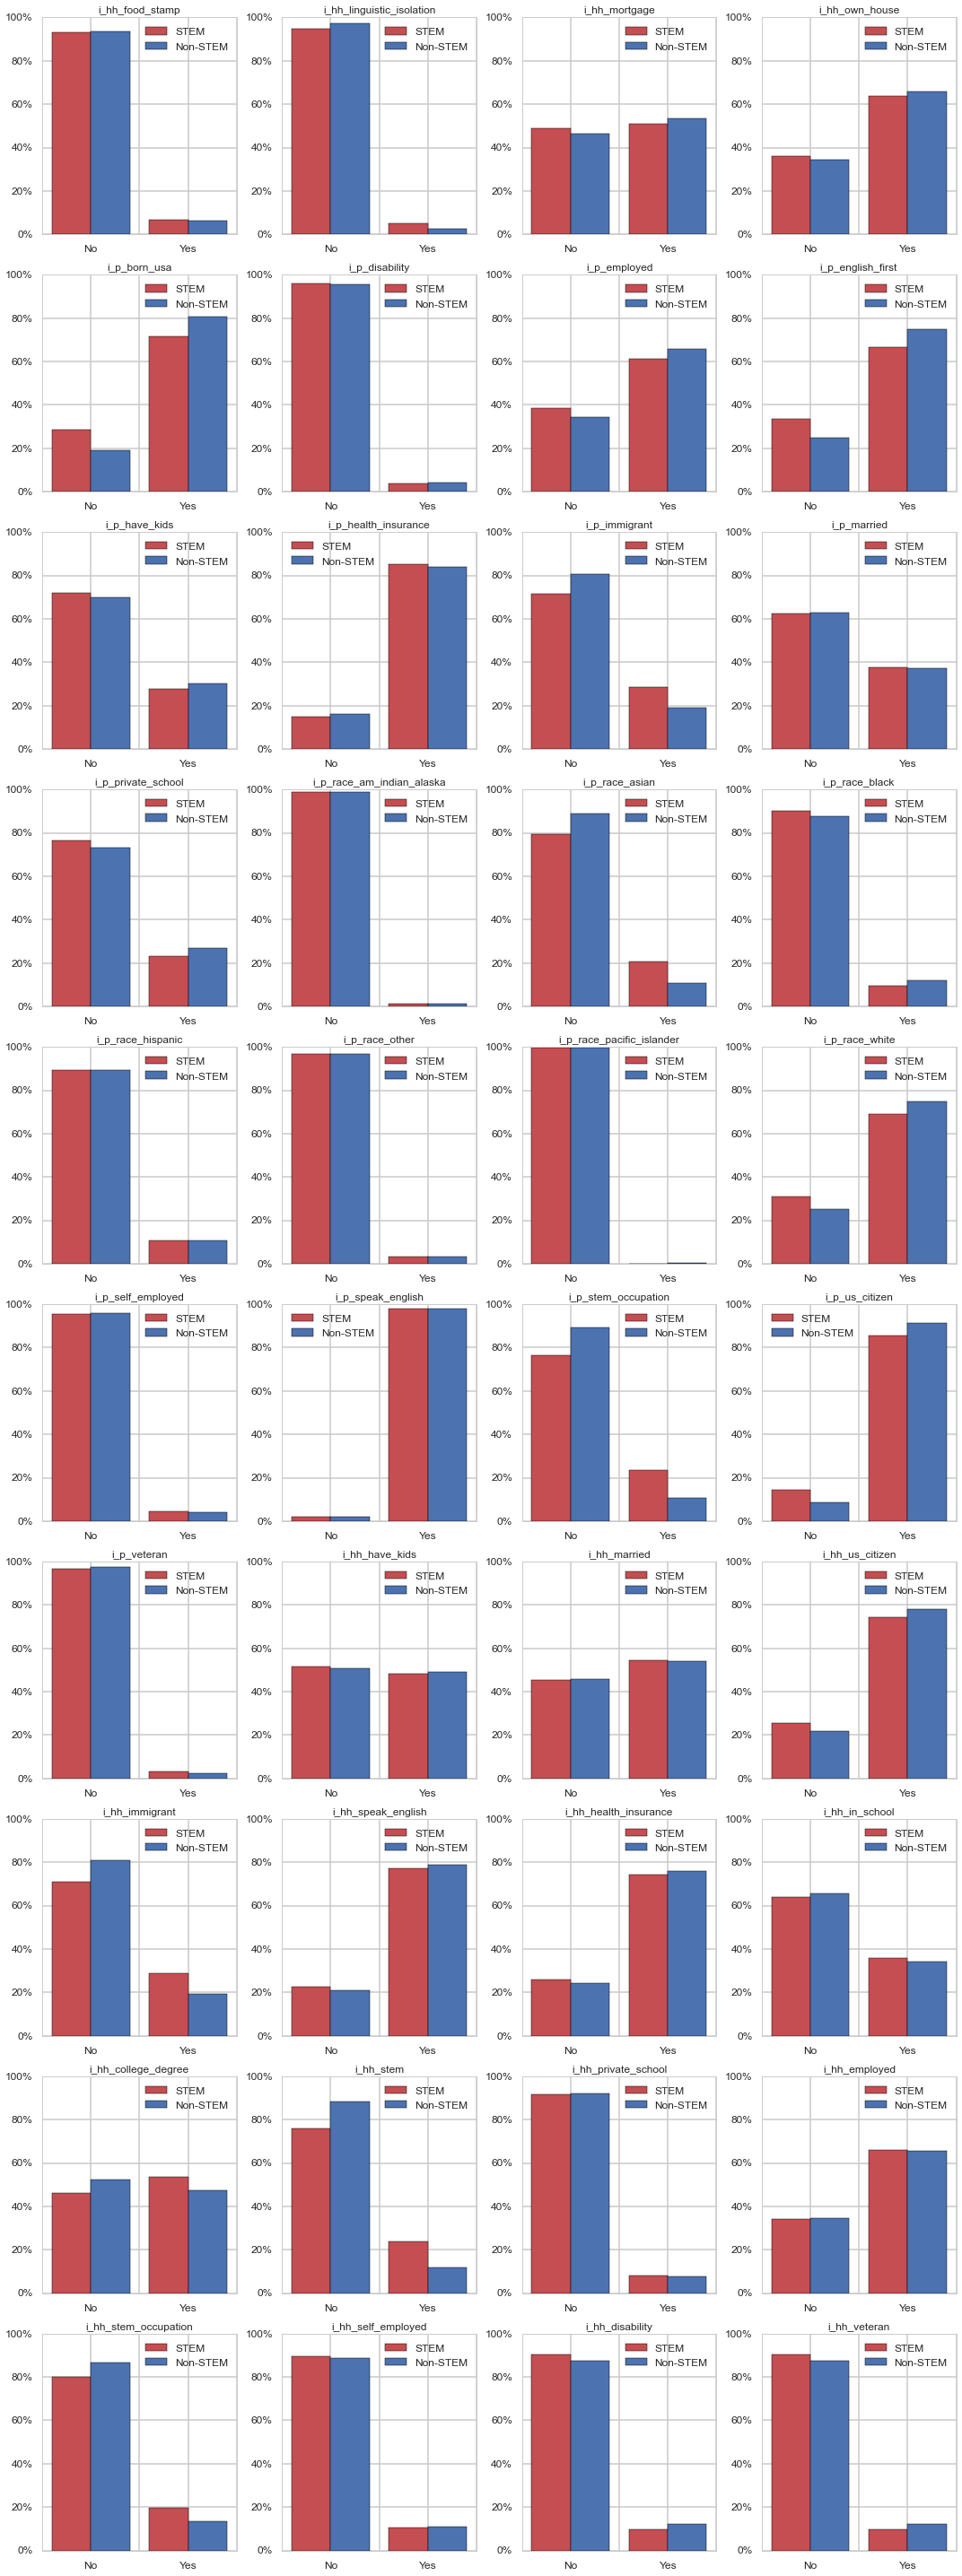

In [85]:
# check for trends in indicator variables
figIndicators, axes = plt.subplots(nrows=10, ncols=4, figsize=(15, 40), tight_layout=True)

for axis, feature in zip(axes.ravel(), INDICATOR_VARS_MODEL):
    countsSTEM = df5_female[feature][df5_female.i_p_stem==1]
    countsNonSTEM = df5_female[feature][df5_female.i_p_stem==0]
    featureSTEM = [(countsSTEM[countsSTEM==i].shape[0] * 100. / female_STEM) for i in range(2)]
    featureNonSTEM = [(countsNonSTEM[countsNonSTEM==i].shape[0] * 100. / female_nonSTEM) for i in range(2)]    
    axis.bar([-0.4, 0.6], featureSTEM, width=0.4, color=snsRed, label='STEM')
    axis.bar([0.0, 1.0], featureNonSTEM, width=0.4, color=snsBlue, label='Non-STEM')
    axis.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    axis.set_title(feature, fontsize=12)
    axis.set_xlim(xmin=-0.5, xmax=1.5)
    axis.set_ylim(ymin=0, ymax=100)
    axis.set_xticklabels(['', 'No', '', 'Yes', ''])
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

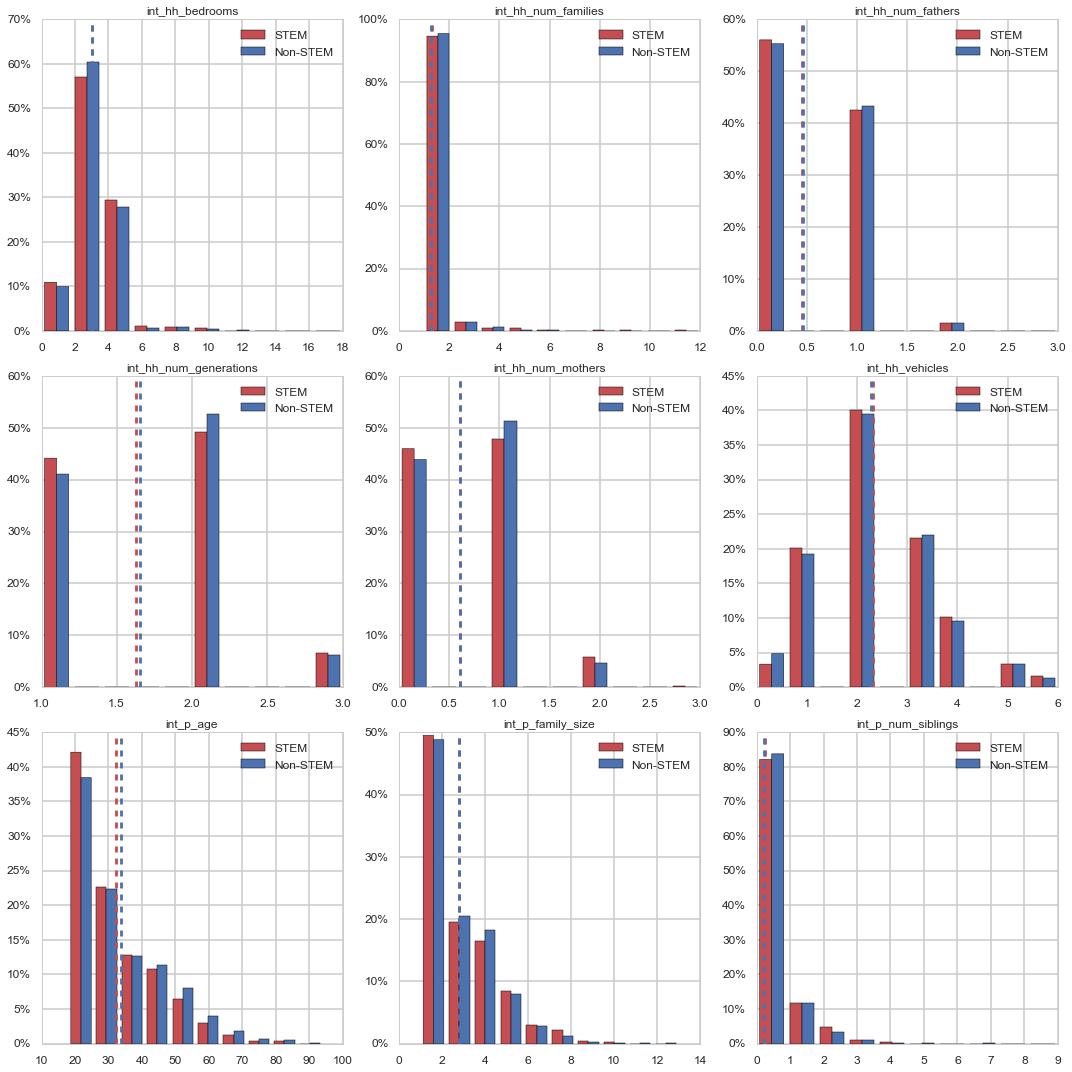

In [86]:
# check for trends in integer variables
figIntVars, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), tight_layout=True)

for axis, feature in zip(axes.ravel(), INTEGER_VARS):
    STEMResp = df5_female[feature][df5_female.i_p_stem==1].values
    NonSTEMResp = df5_female[feature][df5_female.i_p_stem==0].values
    STEMWeights = np.zeros_like(STEMResp) + 100. / STEMResp.size
    NonSTEMWeights = np.zeros_like(NonSTEMResp) + 100. / NonSTEMResp.size
    axis.hist([STEMResp, NonSTEMResp], weights=[STEMWeights, NonSTEMWeights], label=['STEM', 'Non-STEM'],
              color=[snsRed,snsBlue])
    axis.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    axis.axvline(x=STEMResp.mean(), linestyle='--', color=snsRed)
    axis.axvline(x=NonSTEMResp.mean(), linestyle='--', color=snsBlue)
    axis.set_title(feature, fontsize=12)
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


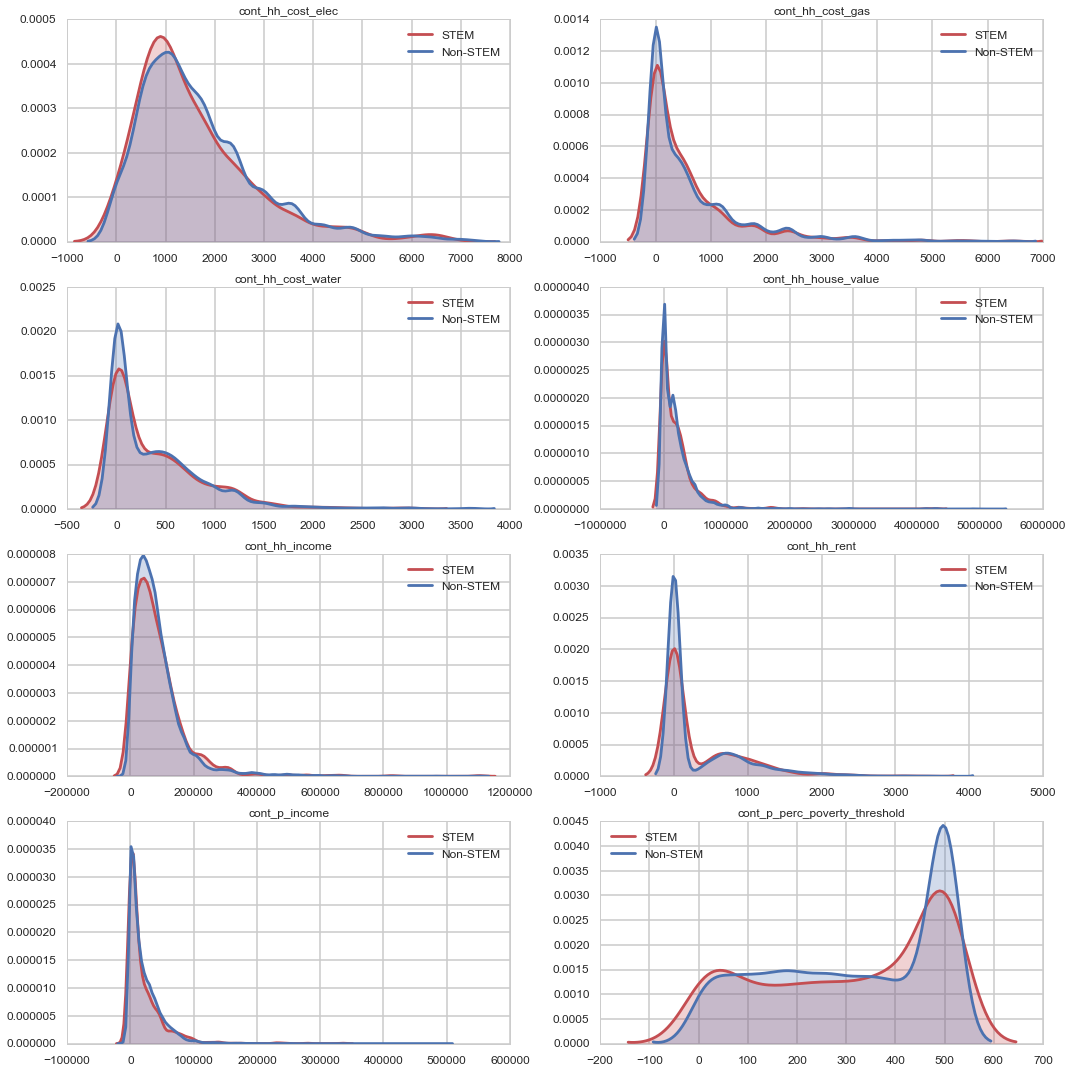

In [87]:
# check for trends in continuous variables
# note - not standardized yet
figContVars, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15), tight_layout=True)

for axis, feature in zip(axes.ravel(), CONTINUOUS_VARS):
    sns.kdeplot(df5_female[feature][df5_female.i_p_stem==1], shade=True, label='STEM', color=snsRed, ax=axis)
    sns.kdeplot(df5_female[feature][df5_female.i_p_stem==0], shade=True, label='Non-STEM', color=snsBlue, ax=axis)
    axis.set_title(feature, fontsize=12)
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

We first examined the breakdown of the indicator variables. Many distributions were roughly similar, although we did notice a few trends when comparing STEM to non-STEM female undergraduates.

* a higher proportion of STEM students were not born in the USA and/or are not US citizens
* a higher proportion of STEM students do not have english as a first language
* a higher proportion of STEM students are immigrants and/or have at least one household member that is an immigrant
* a higher proportion of STEM students are of Asian descent
* a lower proportion of STEM students are white
* a higher proportion of STEM students are already in a STEM occupation and/or have at least one household member in a STEM occupation
* a higher proportion of STEM students have at least one household member with a college degree and/or at least one household member with a degree in a STEM field

This indicates that immigrants or students of certain ethnic background may be more likely to pursue STEM degrees. In addition, exposure to the field through a job or other household member also seems to make students more likely to study STEM.

We then examined the breakdown of integer (ordinal) variables. We observed fewer noticeable differences here, although it was interesting to note that STEM students appear to be marginally younger. We noticed the same (surprisingly) wide age distribution that we had observed during our exploratory data analysis.

The continuous variables were also roughly similar between STEM and non-STEM students, though we noticed that STEM students tended to have a broader distribution of values across the poverty threshold when compared to non-STEM students (i.e. there is less of a concentration among higher-income individuals). Not surprisingly, both categories peaked at higher income levels, which is consistent with a higher proportion of higher-income individuals attending college at all.

**4.3.2 Male Students**

In [88]:
# distribution of response variables for male students
male_STEM = df5_male[df5_male.i_p_stem==1].shape[0]
male_nonSTEM = df5_male[df5_male.i_p_stem==0].shape[0]
male_students = male_STEM + male_nonSTEM
male_students, male_STEM, male_nonSTEM

(5129, 1348, 3781)

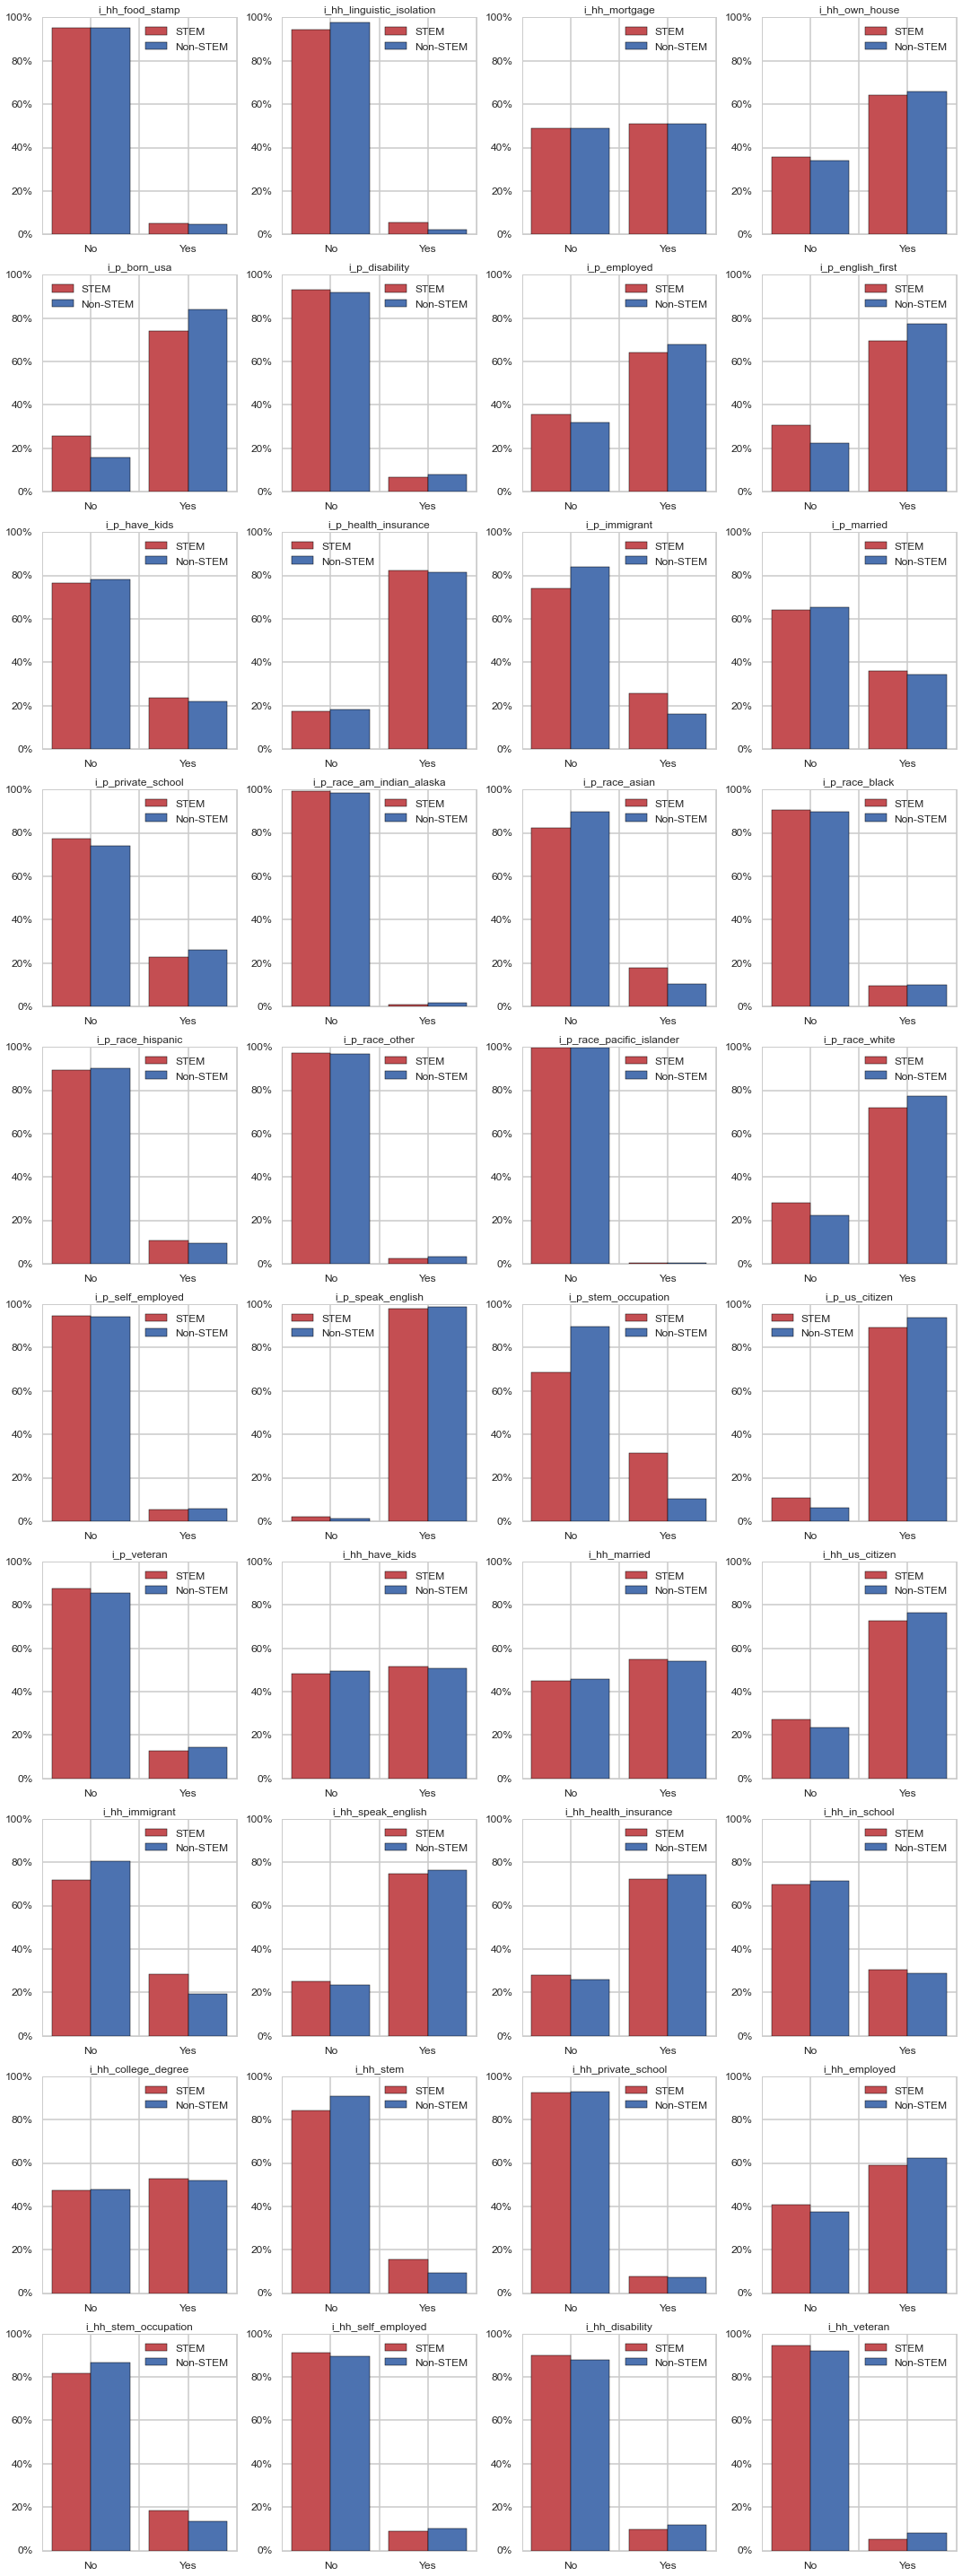

In [89]:
# check for trends in indicator variables
figIndicators, axes = plt.subplots(nrows=10, ncols=4, figsize=(15, 40), tight_layout=True)

for axis, feature in zip(axes.ravel(), INDICATOR_VARS_MODEL):
    countsSTEM = df5_male[feature][df5_male.i_p_stem==1]
    countsNonSTEM = df5_male[feature][df5_male.i_p_stem==0]
    featureSTEM = [(countsSTEM[countsSTEM==i].shape[0] * 100. / male_STEM) for i in range(2)]
    featureNonSTEM = [(countsNonSTEM[countsNonSTEM==i].shape[0] * 100. / male_nonSTEM) for i in range(2)]    
    axis.bar([-0.4, 0.6], featureSTEM, width=0.4, color=snsRed, label='STEM')
    axis.bar([0.0, 1.0], featureNonSTEM, width=0.4, color=snsBlue, label='Non-STEM')
    axis.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    axis.set_title(feature, fontsize=12)
    axis.set_xlim(xmin=-0.5, xmax=1.5)
    axis.set_ylim(ymin=0, ymax=100)
    axis.set_xticklabels(['', 'No', '', 'Yes', ''])
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

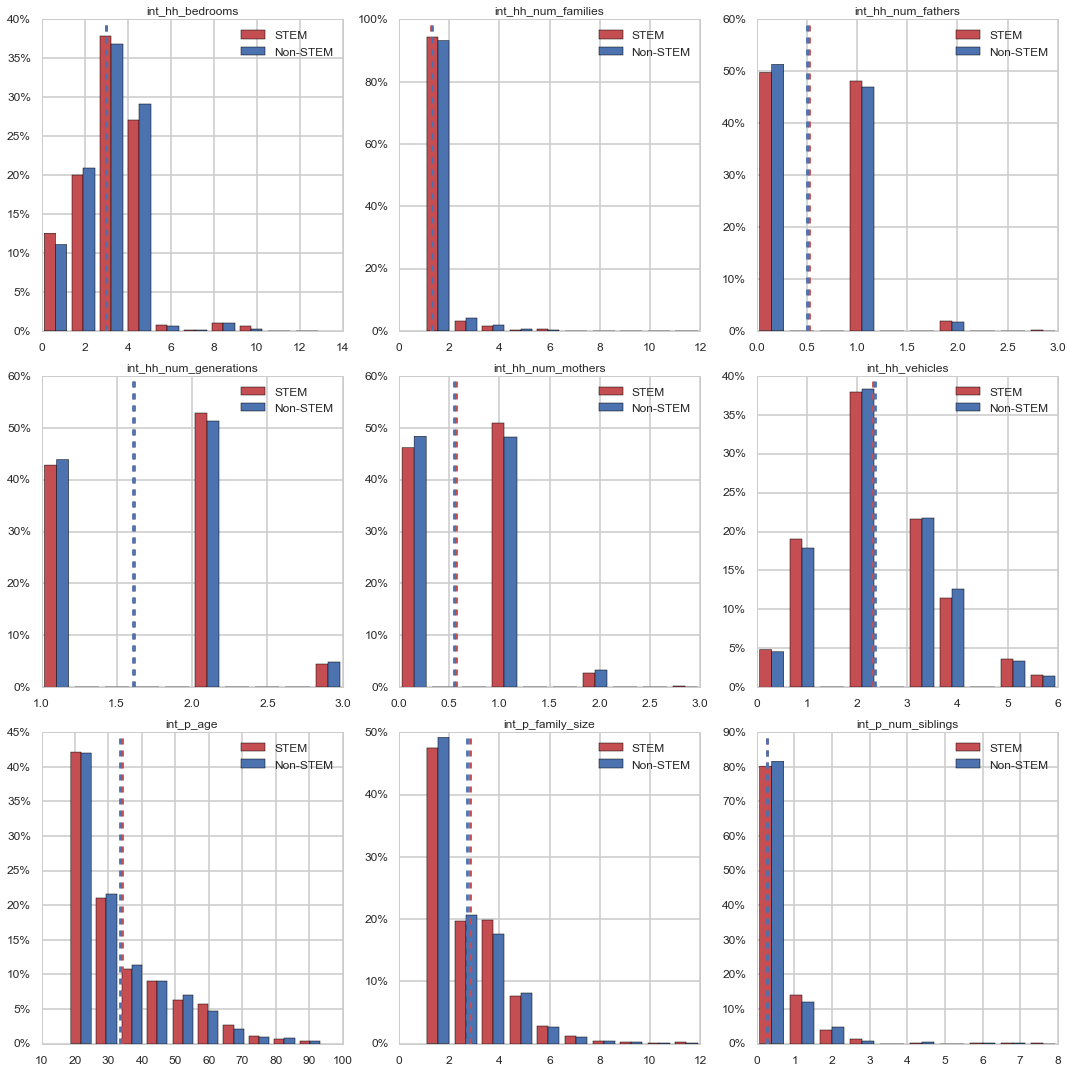

In [90]:
# check for trends in integer variables
figIntVars, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), tight_layout=True)

for axis, feature in zip(axes.ravel(), INTEGER_VARS):
    STEMResp = df5_male[feature][df5_male.i_p_stem==1].values
    NonSTEMResp = df5_male[feature][df5_male.i_p_stem==0].values
    STEMWeights = np.zeros_like(STEMResp) + 100. / STEMResp.size
    NonSTEMWeights = np.zeros_like(NonSTEMResp) + 100. / NonSTEMResp.size
    axis.hist([STEMResp, NonSTEMResp], weights=[STEMWeights, NonSTEMWeights], label=['STEM', 'Non-STEM'],
              color=[snsRed,snsBlue])
    axis.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    axis.axvline(x=STEMResp.mean(), linestyle='--', color=snsRed)
    axis.axvline(x=NonSTEMResp.mean(), linestyle='--', color=snsBlue)
    axis.set_title(feature, fontsize=12)
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

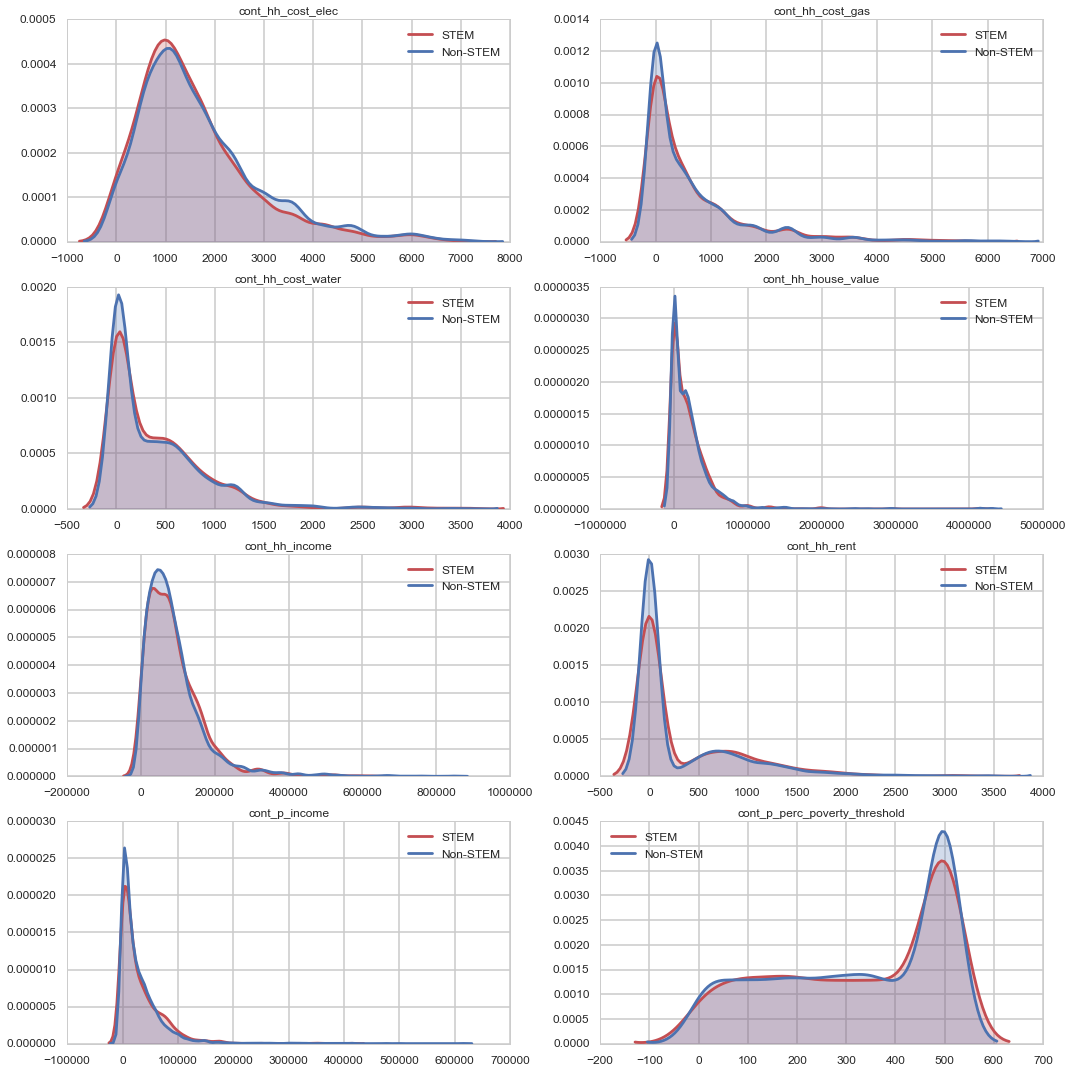

In [91]:
# check for trends in continuous variables
# note - not standardized
figContVars, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15), tight_layout=True)

for axis, feature in zip(axes.ravel(), CONTINUOUS_VARS):
    sns.kdeplot(df5_male[feature][df5_male.i_p_stem==1], shade=True, label='STEM', color=snsRed, ax=axis)
    sns.kdeplot(df5_male[feature][df5_male.i_p_stem==0], shade=True, label='Non-STEM', color=snsBlue, ax=axis)
    axis.set_title(feature, fontsize=12)
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

For comparison purposes, we also plotted the same features for the male undergraduate students. It was interesting to notice some similarities, including a higher proportion of students that:

* were not born in the USA
* are not US citizens
* do not have english as a first language
* are of Asian descent and/or are not white
* are already in a STEM occupation
* have at least one household member with a STEM degree or that works in STEM

Again, there appears to be an association between STEM students and certain demographic characteristics, as well as exposure to the field through prior work experience or a household member.

The integer and continuous variables did not yield significant observable trends.

**4.3.3 Age Distribution**

As mentioned above, we were surprised to see the very wide range of ages of individuals that identified as being college undergraduates at the time of the census. While there is indeed a cluster of students in their early 20s (35% of female students across disciplines are under 25), the mean age is surprisingly high at 33. 

We initially considered applying an age cut-off to the data in order to focus on younger students, but we decide to move forward with the analysis with the entire dataset. This decision reflected our overarching interest in identifying factors that drive women in STEM - at any age.

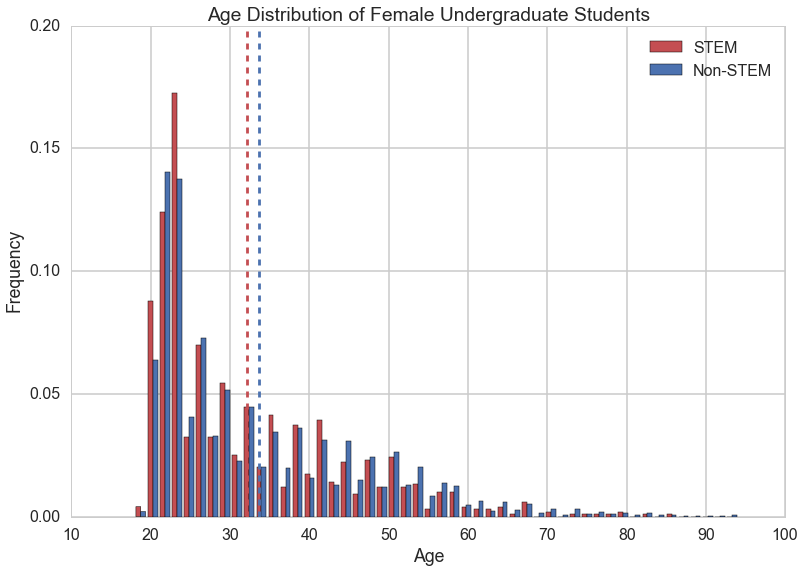

In [92]:
feature = 'int_p_age'

STEMResp = df5_female[feature][df5_female.i_p_stem==1].values
NonSTEMResp = df5_female[feature][df5_female.i_p_stem==0].values
STEMWeights = np.zeros_like(STEMResp) + 1. / STEMResp.size
NonSTEMWeights = np.zeros_like(NonSTEMResp) + 1. / NonSTEMResp.size

plt.hist([STEMResp, NonSTEMResp], weights=[STEMWeights, NonSTEMWeights], label=['STEM', 'Non-STEM'],
         bins=50, color=[snsRed,snsBlue])
plt.title('Age Distribution of Female Undergraduate Students')
plt.vlines(x=STEMResp.mean(), ymin=0, ymax=1, linestyle='--', color=snsRed)
plt.vlines(x=NonSTEMResp.mean(), ymin=0, ymax=1, linestyle='--', color=snsBlue)
plt.ylim(ymin=0, ymax=0.2)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

In [93]:
# move forward with students of all ages
df6_female = df5_female.copy()
df6_male = df5_male.copy()

### 4.4 Rebalancing Classes

Due to the very nature of our research question, our final dataset was very unbalanced, with only 13% of female students majoring in STEM subjects. The male student dataset was also unbalanced, though to a lesser extent, with 26% of students studying STEM.

This inbalance meant that we would not be able to use an accuracy measure in order to assess the models we planned to build. To address the problem, we rebalanced the class for both the female and male datasets via over-sampling, a technique that is well-suited to the problem because it does not introduce bias. This allowed us to use accuracy in order to determine the predictive strength of our models.

**4.4.1 All Female Students**

In [94]:
# determine number of samples required
num_STEM = df6_female[df6_female.i_p_stem==1].shape[0]
num_nonSTEM = df6_female[df6_female.i_p_stem==0].shape[0]
print '%.2f percent STEM students' % (num_STEM * 100. / (num_STEM + num_nonSTEM))
samples_required = num_nonSTEM - num_STEM
print '%d additional samples required to balance classes' % (samples_required)

12.61 percent STEM students
5873 additional samples required to balance classes


In [95]:
# non-parametric bootstrap
# randomly sample with replacement from female STEM fields
new_samples = df6_female[df6_female.i_p_stem==1].sample(n=samples_required, replace=2, axis=0)
dftomodel_femaleall = pd.concat([df6_female, new_samples])

In [96]:
# check split
dftomodel_femaleall[dftomodel_femaleall.i_p_stem==1].shape[0], dftomodel_femaleall[dftomodel_femaleall.i_p_stem==0].shape[0]

(6863, 6863)

In [97]:
dftomodel_femaleall.shape

(13726, 69)

In [98]:
dftomodel_femaleall.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
0,2160,480,600,56000,25200,0,4700,147,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,4,1,1,2,0,2,20,3,1,105,62,1,2,0,0,68
1,2160,480,60,540000,131100,0,2100,501,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,4,1,1,2,1,3,21,4,1,493,76,1,3,2,0,93
2,2400,0,30,15000,24800,0,16400,191,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,4,1,0,2,1,1,45,2,0,747,27,0,2,1,0,45
3,0,0,0,0,76800,2200,4800,501,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,3,1,0,1,0,3,46,2,0,816,27,0,1,0,2,27
4,960,960,600,114000,43900,0,34500,303,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,1,0,1,0,2,28,2,0,1607,21,0,2,0,1,24


In [99]:
# save clean dataset
# dftomodel_femaleall.to_csv('data/dftomodel_femaleall.csv')

**4.4.2 All Male Students**

In [100]:
# determine number of samples required
num_STEM = df6_male[df6_male.i_p_stem==1].shape[0]
num_nonSTEM = df6_male[df6_male.i_p_stem==0].shape[0]
print '%.2f percent STEM students' % (num_STEM * 100. / (num_STEM + num_nonSTEM))
samples_required = num_nonSTEM - num_STEM
print '%d additional samples required to balance classes' % (samples_required)

26.28 percent STEM students
2433 additional samples required to balance classes


In [101]:
# non-parametric bootstrap
# randomly sample with replacement from male STEM fields
new_samples = df6_male[df6_male.i_p_stem==1].sample(n=samples_required, replace=2, axis=0)
dftomodel_maleall = pd.concat([df6_male, new_samples])

In [102]:
# check split
dftomodel_maleall[dftomodel_maleall.i_p_stem==1].shape[0], dftomodel_maleall[dftomodel_maleall.i_p_stem==0].shape[0]

(3781, 3781)

In [103]:
dftomodel_maleall.shape

(7562, 69)

In [104]:
dftomodel_maleall.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
0,2400,0,30,165000,87000,0,45000,396,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,0,1,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,1,0,3,1,1,2,1,3,33,4,0,80,60,0,1,0,2,60
1,2760,360,20,350000,135000,0,60000,501,1,0,1,0,1,1,0,1,0,1,1,1,1,0,1,0,0,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,1,0,3,1,1,2,1,2,34,4,0,160,53,0,2,0,1,51
2,0,0,0,0,26000,0,12000,106,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,2,2,0,1,0,3,22,1,0,359,16,0,1,0,0,17
3,3720,48,300,290000,231500,0,2500,501,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,4,1,1,2,1,4,24,3,0,430,84,1,3,2,0,104
4,960,720,300,0,35500,250,35500,316,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,1,0,1,0,2,24,1,0,1051,66,0,1,0,0,67


In [105]:
# save clean dataset
# dftomodel_maleall.to_csv('data/dftomodel_maleall.csv')

**4.4.3 Female Students Over/Under 25**

Given the wide distribution of ages, we also created analogous dataframes for female college students over and under the ages of 25, in order to determine whether there are any key distinguishing characteristics.

In [106]:
female_under25 = df6_female[df6_female.int_p_age<=25]

In [107]:
# determine number of samples required
num_STEM = female_under25[female_under25.i_p_stem==1].shape[0]
num_nonSTEM = female_under25[female_under25.i_p_stem==0].shape[0]
print '%.2f percent STEM students' % (num_STEM * 100. / (num_STEM + num_nonSTEM))
samples_required = num_nonSTEM - num_STEM
print '%d additional samples required to balance classes' % (samples_required)

13.65 percent STEM students
2221 additional samples required to balance classes


In [108]:
# non-parametric bootstrap
# randomly sample with replacement from male STEM fields
new_samples = female_under25[female_under25.i_p_stem==1].sample(n=samples_required, replace=2, axis=0)
dftomodel_femaleunder25 = pd.concat([female_under25, new_samples])

In [109]:
# check split
dftomodel_femaleunder25[dftomodel_femaleunder25.i_p_stem==1].shape[0], dftomodel_femaleunder25[dftomodel_femaleunder25.i_p_stem==0].shape[0]

(2638, 2638)

In [110]:
dftomodel_femaleunder25.shape

(5276, 69)

In [111]:
dftomodel_femaleunder25.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
0,2160,480,600,56000,25200,0,4700,147,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,4,1,1,2,0,2,20,3,1,105,62,1,2,0,0,68
1,2160,480,60,540000,131100,0,2100,501,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,4,1,1,2,1,3,21,4,1,493,76,1,3,2,0,93
5,3000,120,1600,140000,75600,0,15600,332,0,0,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,1,1,2,1,4,21,4,1,1700,71,1,3,2,0,109
6,1920,0,30,0,7500,0,7500,28,0,0,0,1,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,1,1,2,1,3,22,5,0,1870,19,0,1,0,2,18
10,2760,0,0,0,15440,540,5300,47,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,3,3,0,2,1,2,25,1,0,2604,48,0,3,0,0,149


In [112]:
# save clean dataset
# dftomodel_femaleunder25.to_csv('data/dftomodel_femaleunder25.csv')

In [113]:
female_over25 = df6_female[df6_female.int_p_age>25]

In [114]:
# determine number of samples required
num_STEM = female_over25[female_over25.i_p_stem==1].shape[0]
num_nonSTEM = female_over25[female_over25.i_p_stem==0].shape[0]
print '%.2f percent STEM students' % (num_STEM * 100. / (num_STEM + num_nonSTEM))
samples_required = num_nonSTEM - num_STEM
print '%d additional samples required to balance classes' % (samples_required)

11.94 percent STEM students
3652 additional samples required to balance classes


In [115]:
# non-parametric bootstrap
# randomly sample with replacement from male STEM fields
new_samples = female_over25[female_over25.i_p_stem==1].sample(n=samples_required, replace=2, axis=0)
dftomodel_femaleover25 = pd.concat([female_over25, new_samples])

In [116]:
# check split
dftomodel_femaleover25[dftomodel_femaleover25.i_p_stem==1].shape[0], dftomodel_femaleover25[dftomodel_femaleover25.i_p_stem==0].shape[0]

(4225, 4225)

In [117]:
dftomodel_femaleover25.shape

(8450, 69)

In [118]:
dftomodel_femaleover25.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
2,2400,0,30,15000,24800,0,16400,191,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,4,1,0,2,1,1,45,2,0,747,27,0,2,1,0,45
3,0,0,0,0,76800,2200,4800,501,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,3,1,0,1,0,3,46,2,0,816,27,0,1,0,2,27
4,960,960,600,114000,43900,0,34500,303,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,1,0,1,0,2,28,2,0,1607,21,0,2,0,1,24
7,3480,1800,30,15000,11000,0,11000,73,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,2,0,2,1,2,29,2,0,2214,41,0,1,0,0,41
8,2400,0,780,0,17300,730,17300,115,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,4,1,0,2,1,1,49,2,0,2374,89,0,1,0,0,90


In [119]:
# save clean dataset
# dftomodel_femaleover25.to_csv('data/dftomodel_femaleover25.csv')

 <a id = "section5"></a>
 ## 5. Additional Data Preparation

We now had a complete and clean data set to work with, but we still had to carry out a few additional steps before we were reading to begin building our predictive models.

In [3]:
# use locally stored file
dftomodel = pd.read_csv('data/dftomodel_femaleall.csv')

# use web-based file (~2.3MB)
# dftomodel = pd.read_csv('https://copy.com/R0oIMahBZgm8TPnN')

dftomodel.drop('Unnamed: 0', axis=1, inplace=True)

### 5.1 Exploring the Dataset

In [4]:
dftomodel.shape

(13726, 69)

In [5]:
dftomodel.dtypes

cont_hh_cost_elec                int64
cont_hh_cost_gas                 int64
cont_hh_cost_water               int64
cont_hh_house_value              int64
cont_hh_income                   int64
cont_hh_rent                     int64
cont_p_income                    int64
cont_p_perc_poverty_threshold    int64
i_hh_college_degree              int64
i_hh_disability                  int64
i_hh_employed                    int64
i_hh_food_stamp                  int64
i_hh_have_kids                   int64
i_hh_health_insurance            int64
i_hh_immigrant                   int64
i_hh_in_school                   int64
i_hh_linguistic_isolation        int64
i_hh_married                     int64
i_hh_mortgage                    int64
i_hh_own_house                   int64
i_hh_private_school              int64
i_hh_self_employed               int64
i_hh_speak_english               int64
i_hh_stem                        int64
i_hh_stem_occupation             int64
i_hh_us_citizen          

In [6]:
dftomodel.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
0,2160,480,600,56000,25200,0,4700,147,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,4,1,1,2,0,2,20,3,1,105,62,1,2,0,0,68
1,2160,480,60,540000,131100,0,2100,501,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,4,1,1,2,1,3,21,4,1,493,76,1,3,2,0,93
2,2400,0,30,15000,24800,0,16400,191,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,4,1,0,2,1,1,45,2,0,747,27,0,2,1,0,45
3,0,0,0,0,76800,2200,4800,501,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,3,1,0,1,0,3,46,2,0,816,27,0,1,0,2,27
4,960,960,600,114000,43900,0,34500,303,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,1,0,1,0,2,28,2,0,1607,21,0,2,0,1,24


We first split our features into standardizable (numerical) and indicator (boolean) variables.

In [7]:
# hard coded so that we can start running the notebook at section 5 without having to re-run previous sections

STANDARDIZABLE = ['int_hh_bedrooms',
 'int_hh_num_families',
 'int_hh_num_fathers',
 'int_hh_num_generations',
 'int_hh_num_mothers',
 'int_hh_vehicles',
 'int_p_age',
 'int_p_family_size',
 'int_p_num_siblings',
 'cont_hh_cost_elec',
 'cont_hh_cost_gas',
 'cont_hh_cost_water',
 'cont_hh_house_value',
 'cont_hh_income',
 'cont_hh_rent',
 'cont_p_income',
 'cont_p_perc_poverty_threshold']

INDICATORS = ['i_hh_food_stamp',
 'i_hh_linguistic_isolation',
 'i_hh_mortgage',
 'i_hh_own_house',
 'i_p_born_usa',
 'i_p_disability',
 'i_p_employed',
 'i_p_english_first',
 'i_p_have_kids',
 'i_p_health_insurance',
 'i_p_immigrant',
 'i_p_married',
 'i_p_private_school',
 'i_p_race_am_indian_alaska',
 'i_p_race_asian',
 'i_p_race_black',
 'i_p_race_hispanic',
 'i_p_race_other',
 'i_p_race_pacific_islander',
 'i_p_race_white',
 'i_p_self_employed',
 'i_p_speak_english',
 'i_p_stem_occupation',
 'i_p_us_citizen',
 'i_p_veteran',
 'i_hh_have_kids',
 'i_hh_married',
 'i_hh_us_citizen',
 'i_hh_immigrant',
 'i_hh_speak_english',
 'i_hh_health_insurance',
 'i_hh_in_school',
 'i_hh_college_degree',
 'i_hh_stem',
 'i_hh_private_school',
 'i_hh_employed',
 'i_hh_stem_occupation',
 'i_hh_self_employed',
 'i_hh_disability',
 'i_hh_veteran']

We then separated out the continuous variables, and took a closer look at them.

In [8]:
CONTINUOUS = ['cont_hh_cost_elec',
 'cont_hh_cost_gas',
 'cont_hh_cost_water',
 'cont_hh_house_value',
 'cont_hh_income',
 'cont_hh_rent',
 'cont_p_income',
 'cont_p_perc_poverty_threshold']

print min(dftomodel.cont_hh_cost_elec), max(dftomodel.cont_hh_cost_elec)
print min(dftomodel.cont_hh_cost_gas), max(dftomodel.cont_hh_cost_gas)
print min(dftomodel.cont_hh_cost_water), max(dftomodel.cont_hh_cost_water)
print min(dftomodel.cont_hh_house_value), max(dftomodel.cont_hh_house_value)
print min(dftomodel.cont_hh_income), max(dftomodel.cont_hh_income)
print min(dftomodel.cont_hh_rent), max(dftomodel.cont_hh_rent)
print min(dftomodel.cont_p_income), max(dftomodel.cont_p_income)
print min(dftomodel.cont_p_perc_poverty_threshold), max(dftomodel.cont_p_perc_poverty_threshold)

0 7200
0 6480
0 3600
0 5303000
-12300 1103200
0 3800
-8700 498000
1 501


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
//anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


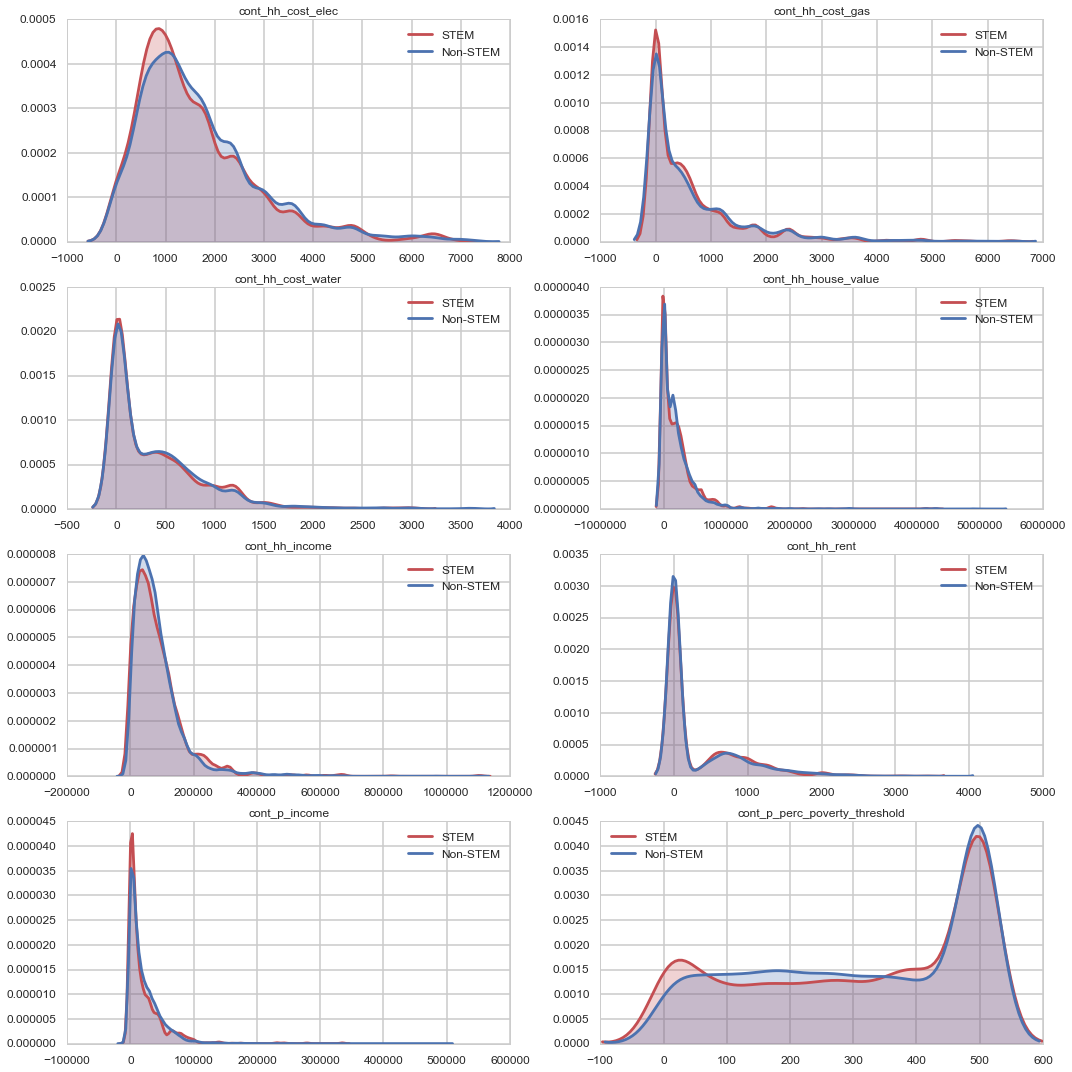

In [9]:
# check for trends in continuous variables
# note - not standardized
figContVars, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15), tight_layout=True)

for axis, feature in zip(axes.ravel(), CONTINUOUS):
    sns.kdeplot(dftomodel[feature][dftomodel.i_p_stem==1], shade=True, label='STEM', color=snsRed, ax=axis)
    sns.kdeplot(dftomodel[feature][dftomodel.i_p_stem==0], shade=True, label='Non-STEM', color=snsBlue, ax=axis)
    axis.set_title(feature, fontsize=12)
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

Some of these variables may be amenable to log-transformation, and this may be considered in future investigations. For now, we will standardize these variables below.

### 5.2 Creating Training and Test Datasets

We standardized the test and training sets separately. Specifically, wanted to standardize the non-indicator columns on both the test and training sets, by subtracting out the mean of the training set from the value and dividing by the standard deviation of the training set. This helped us put all the continuous variables on the same scale.

In [10]:
from sklearn.cross_validation import train_test_split

In [11]:
# random_state sets the seed, for reproducibility
itrain, itest = train_test_split(xrange(dftomodel.shape[0]), train_size=0.7, random_state=123)

In [12]:
mask = np.ones(dftomodel.shape[0], dtype='int')
mask[itrain] = 1
mask[itest] = 0
mask = (mask==1)

In [13]:
mask

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [14]:
mask.shape, mask.sum()

((13726,), 9608)

### 5.3 Standardization

We used the mask to compute the training and test parts of the dataframe. We used `StandardScaler` from `sklearn.preprocessing` to "fit" the columns in `STANDARDIZABLE` on the training set. We then used the resultant estimator to transform both the training and the test parts of each of the columns in the dataframe, replacing the old non-standardized values in the `STANDARDIZABLE` columns of `dftomodel` by the new standardized ones.

In [15]:
from sklearn import preprocessing

In [16]:
# making a working copy, although not necessary (as we could use pandas slice commands)
# seems to be less buggy
working_df = dftomodel[STANDARDIZABLE].copy()
df_train = working_df[mask]
df_test = working_df[~mask]

std_scale = preprocessing.StandardScaler().fit(df_train)
train_std = std_scale.transform(df_train)
test_std = std_scale.transform(df_test)

working_df[mask] = train_std
working_df[~mask] = test_std

dftomodel[STANDARDIZABLE] = working_df

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


In [17]:
dftomodel.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
0,0.415855,-0.172717,0.417191,-0.479285,-0.715661,-0.592330,-0.561563,-0.946656,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0.747364,-0.352001,1.028274,0.598927,-1.025915,-0.248088,-1.041172,0.134110,1.228346,105,62,1,2,0,0,68
1,0.415855,-0.172717,-0.663030,1.063372,0.518666,-0.592330,-0.650386,1.067376,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0.747364,-0.352001,1.028274,0.598927,0.647882,0.590922,-0.960230,0.757492,1.228346,493,76,1,3,2,0,93
2,0.609845,-0.672978,-0.723042,-0.609964,-0.720323,-0.592330,-0.161863,-0.696324,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0.747364,-0.352001,-0.871660,0.598927,0.647882,-1.087097,0.982370,-0.489272,-0.391911,747,27,0,2,1,0,45
3,-1.330055,-0.672978,-0.783054,-0.657774,-0.114232,3.474797,-0.558147,1.067376,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,-0.014350,-0.352001,-0.871660,-1.075350,-1.025915,0.590922,1.063311,-0.489272,-0.391911,816,27,0,1,0,2,27
4,-0.554095,0.327544,0.417191,-0.294421,-0.497701,-0.592330,0.456477,-0.059116,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,-0.014350,-0.352001,-0.871660,-1.075350,-1.025915,-0.248088,-0.393639,-0.489272,-0.391911,1607,21,0,2,0,1,24


### 5.4 Isolating Predictors

We created a list `lcols` of the columns to be used in our classifier, and checked that it did not not contain the response `RESP`. We excluded features that were not in our `STANDARDIZABLE` or `INDICATORS` list. We counted the total number of features.

In [18]:
col_list = dftomodel.columns.tolist()
col_list

['cont_hh_cost_elec',
 'cont_hh_cost_gas',
 'cont_hh_cost_water',
 'cont_hh_house_value',
 'cont_hh_income',
 'cont_hh_rent',
 'cont_p_income',
 'cont_p_perc_poverty_threshold',
 'i_hh_college_degree',
 'i_hh_disability',
 'i_hh_employed',
 'i_hh_food_stamp',
 'i_hh_have_kids',
 'i_hh_health_insurance',
 'i_hh_immigrant',
 'i_hh_in_school',
 'i_hh_linguistic_isolation',
 'i_hh_married',
 'i_hh_mortgage',
 'i_hh_own_house',
 'i_hh_private_school',
 'i_hh_self_employed',
 'i_hh_speak_english',
 'i_hh_stem',
 'i_hh_stem_occupation',
 'i_hh_us_citizen',
 'i_hh_veteran',
 'i_p_born_usa',
 'i_p_college',
 'i_p_college_degree',
 'i_p_disability',
 'i_p_employed',
 'i_p_english_first',
 'i_p_female',
 'i_p_have_kids',
 'i_p_health_insurance',
 'i_p_immigrant',
 'i_p_in_school',
 'i_p_married',
 'i_p_private_school',
 'i_p_race_am_indian_alaska',
 'i_p_race_asian',
 'i_p_race_black',
 'i_p_race_hispanic',
 'i_p_race_other',
 'i_p_race_pacific_islander',
 'i_p_race_white',
 'i_p_self_employed',


In [19]:
# subtract STANDARDIZABLE, INDICATORS, and our response `i_p_stem`
extra_vars = list(set(col_list) - set(STANDARDIZABLE) - set(INDICATORS) - set(['i_p_stem']))
extra_vars

['tech_p_dad_id',
 'i_p_female',
 'tech_hh_weight',
 'tech_hh_id',
 'i_p_in_school',
 'tech_p_spouse_id',
 'i_p_college',
 'tech_p_mom_id',
 'i_p_college_degree',
 'tech_p_id',
 'tech_p_weight']

In [20]:
# drop these from the dataframe
dftomodel = dftomodel.drop(extra_vars, axis=1)
dftomodel.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_disability,i_p_employed,i_p_english_first,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings
0,0.415855,-0.172717,0.417191,-0.479285,-0.715661,-0.592330,-0.561563,-0.946656,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0.747364,-0.352001,1.028274,0.598927,-1.025915,-0.248088,-1.041172,0.134110,1.228346
1,0.415855,-0.172717,-0.663030,1.063372,0.518666,-0.592330,-0.650386,1.067376,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0.747364,-0.352001,1.028274,0.598927,0.647882,0.590922,-0.960230,0.757492,1.228346
2,0.609845,-0.672978,-0.723042,-0.609964,-0.720323,-0.592330,-0.161863,-0.696324,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0.747364,-0.352001,-0.871660,0.598927,0.647882,-1.087097,0.982370,-0.489272,-0.391911
3,-1.330055,-0.672978,-0.783054,-0.657774,-0.114232,3.474797,-0.558147,1.067376,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,-0.014350,-0.352001,-0.871660,-1.075350,-1.025915,0.590922,1.063311,-0.489272,-0.391911
4,-0.554095,0.327544,0.417191,-0.294421,-0.497701,-0.592330,0.456477,-0.059116,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,-0.014350,-0.352001,-0.871660,-1.075350,-1.025915,-0.248088,-0.393639,-0.489272,-0.391911


We defined the response variable as `RESP`.

In [21]:
RESP = "i_p_stem"  

## list of predictor variables
lcols = list(dftomodel.columns)
lcols.remove(RESP)
assert len(lcols)==len(STANDARDIZABLE+INDICATORS)
print len(lcols)

57


### 5.4 Defining Cross-Validation Functions

We defined a function `cv_optimize`, which uses a Grid Search in parameters, and a default of 5-fold cross-validation. It takes as arguments a classifier `clf`, with hyper-parameter dictionary `parameters`, training feature matrix `X`, response `y`, number of folds `n_folds`, and custom scoring function `score_func`. It performs cross-validation using `GridSearchCV` along with a grid-search of hyperparameters. It obtains the best model by the average cross-validation score (allowing for a custom cross-validation score, not just those provided by `sklearn`), and finally returns this best model. <br><p>

This `cv_optimize` function will be passed to the subsequent `do_classify` function.

In [22]:
from sklearn.grid_search import GridSearchCV

In [23]:
# based on AC209 HW3

"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary that is passed to GridSearchCV
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""

def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    
    return best

We used the `cv_optimize` function to implement the function `do_classify` below, which provides a general interface to any classifier. This function `do_classify` can take either a mask or a `reuse_split` dictionary to specify which is the training set and which is the test set in `X` and `y`. In the former case the mask is used to choose which samples to use as training samples and which ones to use as test samples. In the latter case a dictionary is used to directly provide training and test sets. This is useful when the splits have already been done and we want to test multiple classifiers on the same test set to compare their performance.

The function constructs the features from `featurenames` columns of the dataframe `indf`, while the column name `targetname` is used with `target1val` as the value that provides a 1 (i.e. a positive instance). A custom scorer can be provided in the optional `score_func` argument (with default value None). `n_folds` is the number of cross-validation folds, set to a default value of 5.

This function prints out the accuracy score on the training and test data, and also the confusion matrix associated with this classifier. It returns the best_fit classifier, along with the training and test sets. Note that the parameters dictionary is used to provide a parameter dictionary in the style of GridSearchCV, which is used by the function `cv_optimize` above.

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
# based on AC209 HW3
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, 
                mask=None, reuse_split=None, score_func=None, n_folds=5):
    
    subdf = indf[featurenames]
    X = subdf.values
    y = (indf[targetname].values==target1val)*1
    
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest = reuse_split['Xtrain'], reuse_split['Xtest']
        ytrain, ytest = reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, 
                             score_func=score_func)
    clf = clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    
    return clf, Xtrain, ytrain, Xtest, ytest

### 5.5 Examining the Response Variable

In [26]:
# individuals are only college women
# whether the individual is in a STEM major or not

print "whole data set", dftomodel[RESP].mean()
print "training set", dftomodel[RESP][mask].mean(), "test set", dftomodel[RESP][~mask].mean()

whole data set 0.5
training set 0.501457119067 test set 0.496600291404


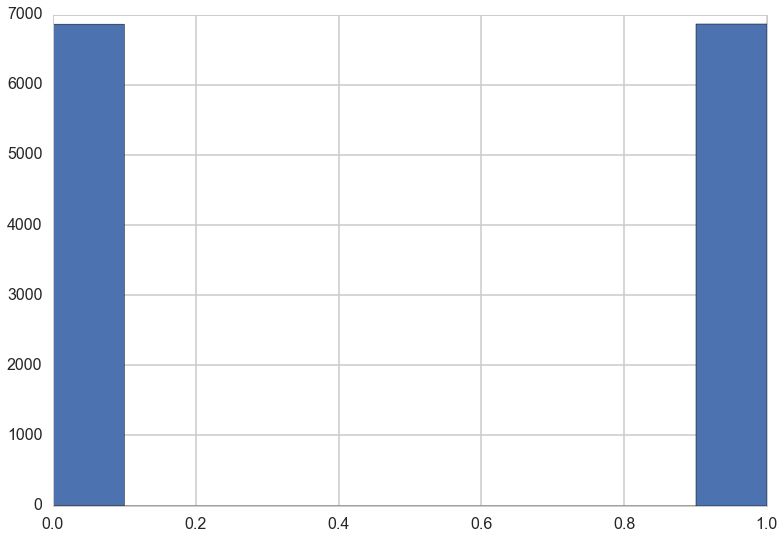

In [27]:
plt.hist(dftomodel[RESP]);

This makes sense as we rebalanced the classes earlier.

 <a id = "section6"></a>
 ## 6. Logistic Regression Models

We chose to begin our modeling with logistic regression models, due to the more intuitive interpretability of their results. We also considered that these results might form part of the input into the later decision tree and/or random forest models.

### 6.1 Logistic Regression with Lasso Based Feature Selection

We proceeded with a logistic regression model with lasso penalty, a form of regularization and variable selection. Regularization adds a penalty term to a cost function to encourage smaller weights. Mathematically, logistic regression with lasso minimizes the equation:

$$
\min_{(\beta_0, \beta) \in \mathbb{R}^{p+1}} -\left[\frac{1}{N} \sum_{i=1}^N y_i \cdot (\beta_0 + x_i^T \beta) - \log (1+e^{(\beta_0+x_i^T \beta)})\right] + \alpha\ ||\beta||_1
$$

i.e. it looks for solutions $(\beta_0, \beta)$ that are small in terms of the $L_1$ norm.

We used the `do_classify` function defined above to run the logistic regression with L1 regularization. The function returns the estimated `clflog`, and training and test sets `Xtrain`, `ytrain`, `Xtest`, and `ytest`. We let the regularization hyperparameter `C` range in powers of 10 from 0.0001 to 100,000. To use "L1" or Lasso regularization, we passed penalty="l1" to `LogisticRegression`: `clf = LogisticRegression(penalty="l1")`.

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
#random_state sets a fixed seed for reproducibility
clflog = LogisticRegression(penalty="l1", random_state=234)

parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(clflog, parameters, dftomodel, lcols, 
                                                   RESP, 1, mask=mask)

reuse_split = dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)  # save for reuse

using mask
BEST {'C': 1} 0.604600333056 [mean: 0.49854, std: 0.00013, params: {'C': 0.0001}, mean: 0.49854, std: 0.00013, params: {'C': 0.001}, mean: 0.59981, std: 0.01725, params: {'C': 0.01}, mean: 0.60408, std: 0.02750, params: {'C': 0.1}, mean: 0.60460, std: 0.02465, params: {'C': 1}, mean: 0.60408, std: 0.02497, params: {'C': 10}, mean: 0.60439, std: 0.02513, params: {'C': 100}, mean: 0.60439, std: 0.02513, params: {'C': 1000}, mean: 0.60439, std: 0.02513, params: {'C': 10000}, mean: 0.60450, std: 0.02515, params: {'C': 100000}]
############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.61
[[1387  686]
 [ 904 1141]]
########################################################


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


It does not seem to have a very high degree of accuracy, but it is not too bad, and at least it is not overfitting. Note:

In [30]:
np.mean(dftomodel[RESP])

0.5

... we are still doing quite a bit better than random guessing.

### 6.2 Regularization Path

We used the estimated `clflog` to plot the regularization path, which shows the coefficients of the different features for different regularization strengths.

In [31]:
len(clflog.coef_[0])

57

In [32]:
clflog

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=234, solver='liblinear', tol=0.0001,
          verbose=0)

In [33]:
# dataframe of coefficients from logistic regression model obtained from CV at best "C"
coefdf = pd.DataFrame({
        'features': lcols,
        'female_coeffs': clflog.coef_[0]
        })
coefdf

,features,female_coeffs
0,cont_hh_cost_elec,-0.022443
1,cont_hh_cost_gas,-0.002007
2,cont_hh_cost_water,-0.051037
3,cont_hh_house_value,-0.066562
4,cont_hh_income,0.026973
5,cont_hh_rent,-0.103972
6,cont_p_income,-0.000295
7,cont_p_perc_poverty_threshold,-0.065633
8,i_hh_college_degree,0.072354
9,i_hh_disability,-0.270405


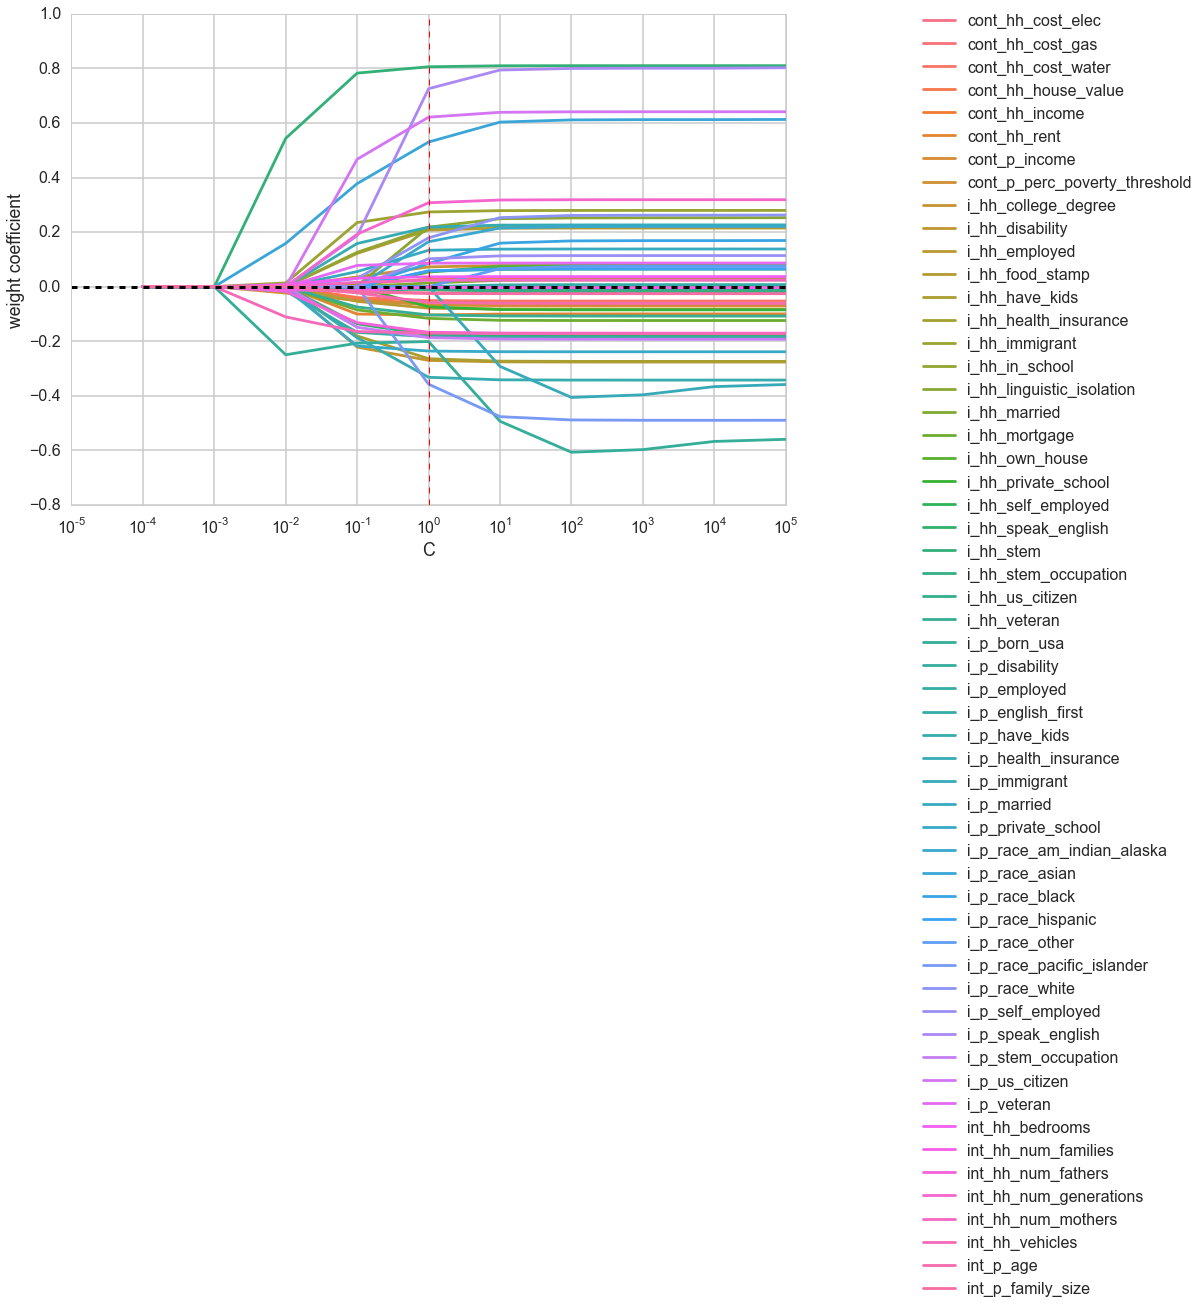

In [34]:
# Adapted from 
# Source: S. Raschka, "Python Machine Learning" (2015)

fig = plt.figure()
ax = plt.subplot(111)
colors = sns.color_palette(palette="husl", n_colors=(len(clflog.coef_[0])+1))
weights, params = [], []

for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=234)
    lr.fit(Xtrain, ytrain)
    # print lr.coef_  # for debugging
    weights.append(lr.coef_[0])  # only two classes
    params.append(10**c)

weights = np.array(weights)

# power of C for best "C"
best_c = 0 # fourth index is C = 1

for column, color in zip(range(weights.shape[1]), colors):
    if dftomodel.columns[column]!=RESP:
        x = params
        y = weights[:, column]
        plt.plot(x, y,
                 label=dftomodel.columns[column],
                 color=color)

plt.axvline(10**(-(best_c)), color="red", linestyle="--", linewidth=1) # added reference line
plt.axhline(0, color="black", linestyle="--", linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

We noticed that a number of the coefficients were zeroed when applying the Lasso penalty, which included `i_hh_self_employed`, `i_p_english_first`, `i_p_immigrant`, and `i_p_race_other`. This does not necessarily mean these variables are unimportant when considered in isolation; it is possible that many of these variables are strongly correlated with others, and relatively speaking, these particular features are not sufficiently increasing the degree of accuracy in the model with their inclusion.

As for the other features remaining in the model, some appear to have very little relative effect on the response, while others would seem to be more important due to their larger magnitudes. We sorted the coefficients by magnitude and sign, and depicted them graphically below -- the greatest positive coefficients would appear to have the greatest positive effect, while the greatest negative coefficients would appear to have the greatest negative effect.

<img src='img/logreg1.png' width=70%>

<img src='img/logreg2.png'>

<img src='img/infopic.jpg' width=60%>

We identified the following top 5 factors based on the coefficients of the model (note that the top 5 positive factors are also the top 5 in magnitude):

* **Individual works in a STEM occupation (this may mean they have part-time work, or they had full-time work and are studying part-time):** this makes sense as these individuals likely already have an affinity toward STEM majors

* **Another member of the household studied STEM in college:** this is eye-opening, and may speak to the importance of having good role models in the family, and possibly strong mentors on a broader level when younger.

* **The individual speaks English:** note this just suggests an association, it is not causation.

* **Veteran status:** perhaps science and engineering skills are more valued for individuals trained or training for military service

* **Asian descent:** there may be cultural influences at play

It is also interesting to take note of the five factors that have a strong negative association, including factors such as having children, or a disability. 

**Interpretation of Coefficients**

The sign of each coefficient indicates whether the probability that an individual will be classified as a STEM (RESP=1) increases or decreases as the value of the predictor increases. The estimated *odds* of a "success" (that the individual is classified as STEM) change by a **multiplicative factor of** *exp(coefficient)* for a one-unit increase in the predictor (for a continuous variable after standardization), or when the value of an indicator is 1 rather than zero, *holding all other predictors constant*. 

### 6.3 ROC Curves

In anticipation of model comparisons, we included code in `make_roc` to plot ROC curves.

ROC curves are a set of classifiers, where each point on the curve corresponds to a different threshold. They are useful for comparing classifiers against each other and with respect to baseline models. In the standard scenario where the accuracy score is used to assess a classifier's predictive power, the threshold is implicitly set to 0.5, which corresponds to only one point on the ROC curve.

To calculate the ROC curve, we pass `proba=True` to `make_roc` seeing as logistic regression is a probabilistic classifier. For non-probabilistic classifiers (e.g. SVM) we would set this to `False`. This function uses `roc_curve` from `sklearn`, which carries out the process described above and returns `fpr` (False Positive Rate), `tpr` (True Positive Rate), and `thresholds`. It also calculates the AUC (area under curve), and plots the ROC curve at various thresholds, skipping every `labe` number of thresholds to make labels.

In [35]:
from sklearn.metrics import roc_curve, auc

In [36]:
# based on AC209 HW3

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba: # for classifiers like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else: # for classifiers like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, 
                label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, 
                label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

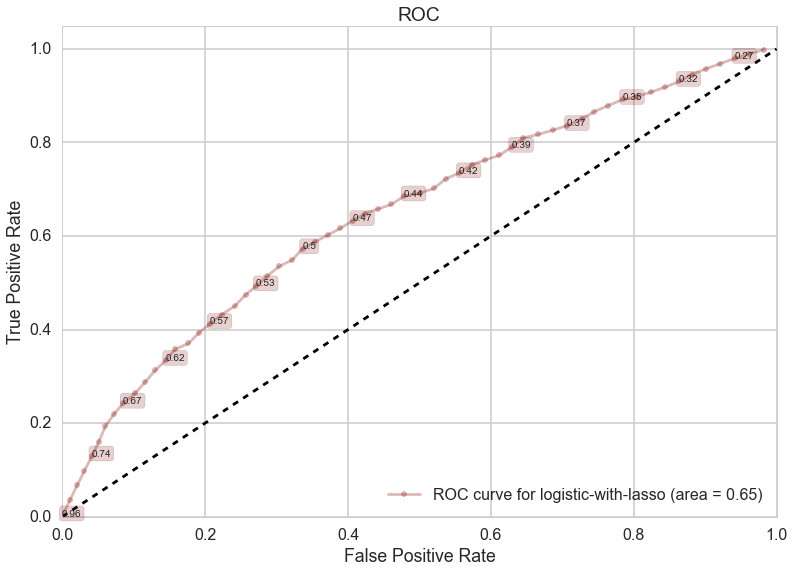

In [37]:
# for the first plot we do not pass an axes object. Subsequent calls to
# make_roc can use the returned axes object ax.
with sns.hls_palette(2, l=.3, s=.8):
    make_roc("logistic-with-lasso", clflog, ytest, Xtest, labe=200, skip=50)

The threshold value of 0.5 for the original logistic-with-lasso model seems closest to the upper left corner on the curve. This is not too surprising, given that we pre-balanced the dataset.

We also incorporated some interactivity into the ROC curves.

In [38]:
# z1 = np.arange(0.,1., 0.02)
# def plot_line(ax, intercept):
#     plt.figure(figsize=(12,12))
#     ax=plt.gca()
#     ax.set_xlim([0.0,1.0])
#     ax.set_ylim([0.0,1.0])
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')
#     with sns.hls_palette(2, l=.3, s=.8):
#         make_roc("logistic-with-lasso", clflog, ytest, Xtest, labe=200, skip=50)
#     ax.plot(z1 , slope*z1 + intercept, 'k-')

In [39]:
# from ipywidgets import interact, fixed

In [40]:
# slope = 1
# interact(plot_line, ax=fixed(ax), intercept=(0.0,1.0, 0.02));

<div class="alert alert-info">
<strong>Note:</strong> this is a new package that still has some bugs when run in an iPython notebook. This is a documented issue, and a new instance of the notebook may need to be run.
</div>

### 6.4 Elastic Net Regularized Logistic Regression

We then moved on to run an elastic net regularized logistic regression, which is a combination of Lasso and Ridge regularization, in order to see whether this approach would yield greater predictive power. 

>$$
\begin{aligned}
\log = \frac{\text{Pr}(V=1|X=x)}{\text{Pr}(V=0|X=x)} = \beta_0 + \beta^T x
\end{aligned}
$$

>Thus, the objective function is to minimize 
>
$$
\begin{aligned}
\min_{(\beta_0, \beta) \in \mathbb{R}^{p+1}} -\left[\frac{1}{N} \sum_{i=1}^N y_i \cdot (\beta_0 + x_i^T \beta) - \log (1+e^{(\beta_0+x_i^T \beta)})\right] + \alpha (1-\lambda)||\beta||_2^2/2 + \alpha\lambda||\beta||_1
\end{aligned}
$$

In our code $\lambda =$ `l1_ratio`, and an $\alpha$ range is determined by `eps`, see the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) for more details. 

According to Hui Zou and Trevor Hastie, *Regularization and Variable Selection via the Elastic Net*, elastic net is supposed to address the following limitations of lasso regularization:
    
* If p > n, the lasso selects at most n variables.

* Grouped variables: the lasso fails to do grouped selection. It tends to select one variable from a group and ignore the others.

In [41]:
from sklearn.linear_model import lasso_path, enet_path

In [42]:
eps = 5e-6  # the smaller it is the longer is the path

df_noresp = dftomodel.drop(RESP, axis=1)
mm = pd.DataFrame(Xtrain, columns=df_noresp.columns)
X = Xtrain.astype(np.double)
Y = ytrain.astype(np.double)

In [43]:
%%time
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, Y, eps, fit_intercept=False)

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(X, Y, eps=eps, l1_ratio=0.8, 
                                       fit_intercept=False)

Computing regularization path using the lasso...
Computing regularization path using the elastic net...
CPU times: user 83.9 ms, sys: 5.76 ms, total: 89.7 ms
Wall time: 105 ms


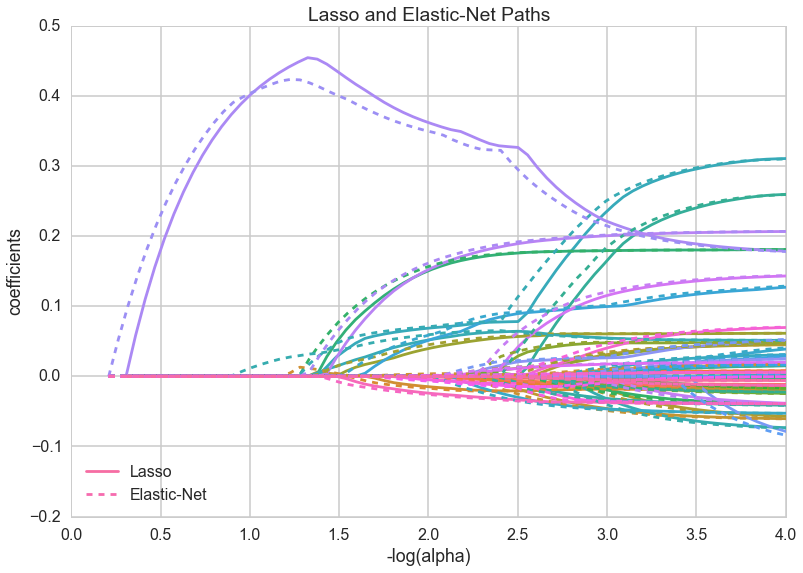

In [44]:
# Color Palette, seaborn has the best colors i.m.o.
col = sns.color_palette("husl", 58)

# make the lasso path
plt.figure(1)
ax = plt.gca()
ax.set_color_cycle(col)
l1 = plt.plot(-np.log10(alphas_lasso), coefs_lasso.T)
l2 = plt.plot(-np.log10(alphas_enet), coefs_enet.T, linestyle='--')
plt.xlim([0, 4])

plt.xlabel('-log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left');

In [45]:
# subset variables with large coefficients to make the plot easier to read
keep = np.abs(coefs_enet.T.sum(axis = 0)) > 7

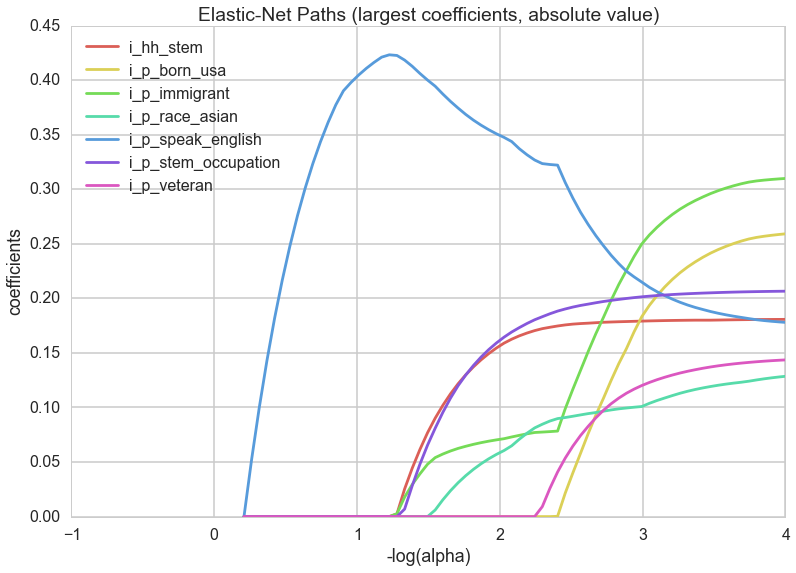

In [46]:
# Color Palette, seaborn has the best colors i.m.o.
col = sns.color_palette("hls", keep.sum())

plt.figure(1)
ax = plt.gca()
ax.set_color_cycle(col)
l2 = plt.plot(-np.log10(alphas_enet), coefs_enet.T[:,keep])
plt.xlim([-1, 4])

plt.xlabel('-log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net Paths (largest coefficients, absolute value)')
plt.legend(l2, list(mm.columns.values[keep]), loc='upper left');

The comparison between the lasso and elastic-net paths showed that the lasso curves were quite well-behaved, and that the adjustments obtained from the elastic-net regularization track them closely. Indeed, the most significant coefficients were similar to those that were derived and discused earlier. On this basis, we concluded that we could proceed with our original results.

### 6.5 Feature Selection Using Linear Discriminant Analysis

The logistic regression methods presented above can be used not only to build a predictive model, but also to select features for use in other techniques. Feature selection is often carried out - either automatically or otherwise - because there may be a strong correlation between features, making many of the superfluous. A large number of features can also lead to overfitting. Feature selection addresses these problems, and can also help curb the "curse of dimensionality".

Before closing the chapter on Logistic Regression Models, we decided to experiment with an alternative form of feature selection: Linear Discriminant Analysis (LDA). The goal of LDA is to find the feature subspace that optimizes class separability. Both LDA and Principal Component Analysis (PCA) are linear transformation techniques that can be used to reduce the number of dimensions in a dataset; LDA is supervised while PCA is unsupervised. LDA assumes that the data is normally distributed and that features are statistically independent; this is unlikely to be the case here, but LDA can often work reasonably well despite violations of these assumptions.

In [47]:
from itertools import cycle

In [48]:
from sklearn.lda import LDA

In [49]:
def plot_decision_regions(X, y, clf, X_highlight=None, res=0.02, cycle_marker=True, legend=1, cmap=None):
    """
    Plots decision regions of a classifier.
    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
      Feature Matrix.
    y : array-like, shape = [n_samples]
      True class labels.
    clf : Classifier object. Must have a .predict method.
    X_highlight : array-like, shape = [n_samples, n_features] (default: None)
      An array with data points that are used to highlight samples in `X`.
    res : float (default: 0.02)
      Grid width. Lower values increase the resolution but
      slow down the plotting.
    cycle_marker : bool
      Use different marker for each class.
    legend : int
      Integer to specify the legend location.
      No legend if legend is 0.
    cmap : Custom colormap object .
    Returns
    ---------
    None
    Examples
    --------
    from sklearn import datasets
    from sklearn.svm import SVC
    iris = datasets.load_iris()
    X = iris.data[:, [0,2]]
    y = iris.target
    svm = SVC(C=1.0, kernel='linear')
    svm.fit(X,y)
    plot_decision_region(X, y, clf=svm, res=0.02, cycle_marker=True, legend=1)
    plt.xlabel('sepal length [cm]')
    plt.ylabel('petal length [cm]')
    plt.title('SVM on Iris')
    plt.show()
    """
    # check if data is numpy array
    for a in (X, y):
        if not isinstance(a, np.ndarray):
            raise ValueError('%s must be a NumPy array.' % a.__name__)

    # check if test data is provided
    plot_testdata = True
    if not isinstance(X_highlight, np.ndarray):
        if X_highlight is not None:
            raise ValueError('X_test must be a NumPy array or None')
        else:
            plot_testdata = False

    if len(X.shape) == 2 and X.shape[1] > 1:
        dim = '2d'
    else:
        dim = '1d'


    marker_gen = cycle('sxo^v')

    # make color map
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    n_classes = len(np.unique(y))
    if n_classes > 5:
        raise NotImplementedError('Does not support more than 5 classes.')

    if not cmap:
        cmap = mpl.colors.ListedColormap(colors[:n_classes])

    # plot the decision surface

    if dim == '2d':
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    else:
        y_min, y_max = -1, 1

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, res),
                         np.arange(y_min, y_max, res))

    if dim == '2d':
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        Z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)
    else:
        y_min, y_max = -1, 1
        Z = clf.predict(np.array([xx.ravel()]).T)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # plot class samples

    for c in np.unique(y):
        if dim == '2d':
            y_data = X[y==c, 1]
        else:
            y_data = [0 for i in X[y==c]]

        plt.scatter(x=X[y==c, 0],
                    y=y_data,
                    alpha=0.8,
                    c=cmap(c),
                    marker=next(marker_gen),
                    label=c)

    if legend:
        plt.legend(loc=legend, fancybox=True, framealpha=0.5)

    if plot_testdata:
        if dim == '2d':
            plt.scatter(X_highlight[:,0], X_highlight[:,1], c='', alpha=1.0, linewidth=1, marker='o', s=80)
        else:
            plt.scatter(X_highlight, [0 for i in X_highlight], c='', alpha=1.0, linewidth=1, marker='o', s=80)


//anaconda/lib/python2.7/site-packages/sklearn/lda.py:371: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


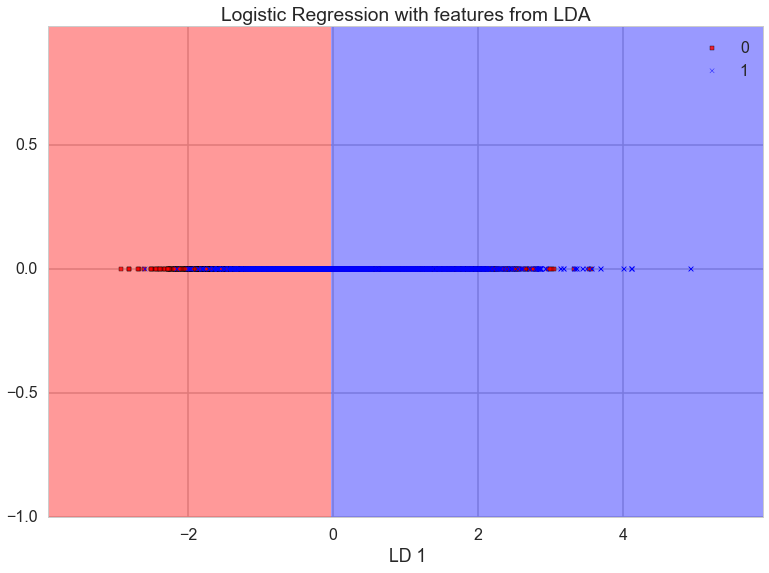

In [50]:
lda = LDA(n_components=2)
X_train_lda_fit = lda.fit(Xtrain, ytrain)
X_train_lda = X_train_lda_fit.transform(Xtrain)

clflog2 = LogisticRegression()
clflog2 = clflog2.fit(X_train_lda, ytrain)
plot_decision_regions(X_train_lda, ytrain, clf=clflog2, res=0.02, cycle_marker=True, legend=1)
plt.xlabel("LD 1")
plt.ylabel("")
plt.title('Logistic Regression with features from LDA')
plt.show()

In [51]:
training_accuracy = clflog2.score(X_train_lda, ytrain)
training_accuracy

0.63124479600333061

In [52]:
Xtest_LDA = X_train_lda_fit.transform(Xtest)
test_accuracy = clflog2.score(Xtest_LDA, ytest)

print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clflog2.predict(Xtest_LDA))
print "########################################################"

############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.62
[[1380  693]
 [ 886 1159]]
########################################################


We found that this approach had comparable accuracy, but that the results were not as readily interpretable at the Logistic Regression model.  Once again, we found that our first attempt continued to be the best.

 <a id = "section7"></a>
 ## 7. Decision Tree and Random Forest Models

Having completed our investigation of logistic regression models, including a detour via LDA, we moved on to another major class of models: decision trees and random forest models. Our previous model had done better than the baseline accuracy of 50% but still had considerable room for improvement, so we were curious to see whether other approaches would yield better results.

### 7.1 Single Decision Tree

In [53]:
from sklearn import tree

**7.1.1 All Features**

We started our exploration of this class of models with a single decision tree incorporating all the features. Once again, our baseline target was 50% accuracy from random guessing, due to our dataset having been rebalanced to 50/50 STEM and non-STEM majors. 

We immediately saw a significant improvement in accuracy (compared to the logistic regression models) when running a single decision tree optimized for hyperparameters and using all relevant non-technical features. The classifier achieved just over 90% accuracy for test data; however, we noticed that it consistently made Type I errors, misclassifying women as STEM majors who are actually not STEM majors.

In [54]:
clfTree1 = tree.DecisionTreeClassifier()

parameters = {'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'max_depth': range(1, 100, 5)}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, dftomodel, 
                                                     lcols, RESP, 1, 
                                                     mask=mask, score_func = 'f1')

using mask
BEST {'max_depth': 51, 'min_samples_leaf': 1} 0.902855615506 [mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.60193, std: 0.02650, params: {'max_depth': 6, 'min_samples_leaf': 1}, mean: 0.60168, std: 0.02682, params: {'max_depth': 6, 'min_samples_leaf': 2}, mean: 0.60194, std: 0.02721, params: {'max_depth': 6, 'min_samples_leaf': 3}, mean: 0.60110, std: 0.02712, params: {'max_depth': 6, 'min_samples_leaf': 4}, mean: 0.59892, std: 0.02740, params: {'max_depth': 6, 'min_samples_leaf': 5}, mean: 0.59824, std: 0.02687, params: {'max_depth': 6, 'min_samples_le

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


**7.1.2 Investigating Subsets of Data**

To ensure that there are no factors inflating the performance, we investigated the possibility of a lurking feature in the person level variables that may be too similar to the response variable `i_p_stem`.

Given the wide distribution of ages among those that indicated they were in college at the time of the 2010 US Census, we considered whether `i_p_stem_occupation` (i.e. whether the person is already in a STEM occupation) and `cont_p_income` (personal income) might be results of the decision to study STEM rather than predictors. Before attempting to build a second decision tree, we removed these features from the input data and subset the data to females under the age of 25 to focus on college-age women who are likely to be less established in their careers and to contribute a smaller percentage of household income (`cont_hh_income`).

We found that the performance was quite similar both in terms of accuracy and the confusion matrix. We therefore returned to our full dataset of all women. 

In [55]:
# use locally stored file
dftomodel_youngf = pd.read_csv('data/dftomodel_femaleunder25.csv')

# use web-based file (~900KB)
# dftomodel_youngf = pd.read_csv('https://copy.com/FopmBDGwmw9k6n9i')

dftomodel_youngf.drop('Unnamed: 0', axis=1, inplace=True)

In [56]:
test_lcols = lcols
test_lcols.remove('i_p_stem_occupation')
test_lcols.remove('cont_p_income')

In [57]:
# build training and test sets
itrain1, itest1 = train_test_split(xrange(dftomodel_youngf.shape[0]), train_size=0.7, 
                                 random_state=321)
mask1 = np.ones(dftomodel_youngf.shape[0], dtype='int')
mask1[itrain1] = 1
mask1[itest1] = 0
mask1 = (mask1==1)

In [58]:
clfTree2 = tree.DecisionTreeClassifier()

parameters = {'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'max_depth': range(1, 100, 5)}
clfTree2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree2, parameters, dftomodel_youngf, 
                                                     test_lcols, RESP, 1, 
                                                     mask=mask1, score_func = 'f1')

using mask
BEST {'max_depth': 51, 'min_samples_leaf': 1} 0.890843281601 [mean: 0.22315, std: 0.01876, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.22315, std: 0.01876, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.22315, std: 0.01876, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.22315, std: 0.01876, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.22315, std: 0.01876, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.22315, std: 0.01876, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.60193, std: 0.00862, params: {'max_depth': 6, 'min_samples_leaf': 1}, mean: 0.60004, std: 0.00731, params: {'max_depth': 6, 'min_samples_leaf': 2}, mean: 0.59935, std: 0.00825, params: {'max_depth': 6, 'min_samples_leaf': 3}, mean: 0.59824, std: 0.00857, params: {'max_depth': 6, 'min_samples_leaf': 4}, mean: 0.59650, std: 0.00948, params: {'max_depth': 6, 'min_samples_leaf': 5}, mean: 0.59510, std: 0.00907, params: {'max_depth': 6, 'min_samples_le

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


**7.1.3 Using Key Features from Lasso**

We next explored the accuracy of a decision tree that uses only the most influential features, as determined by the results of our logistic regression models (see above). We found that the accuracy was somewhat lower, so again returned to the full dataset.

In [59]:
important_features = ['i_p_stem_occupation', 'i_hh_stem', 'i_p_speak_english', 'i_p_veteran', 'i_p_race_asian', 
                      'int_hh_num_mothers', 'i_hh_immigrant', 'i_p_health_insurance', 'i_hh_linguistic_isolation', 
                      'i_hh_in_school', 'i_p_race_pacific_islander', 'i_p_have_kids', 'i_hh_disability', 
                      'i_hh_have_kids', 'i_p_private_school', 'i_p_born_usa', 'i_p_us_citizen', 'i_p_employed', 
                      'i_hh_speak_english', 'int_p_age']

In [60]:
# all women
clfTree3 = tree.DecisionTreeClassifier()

parameters = {'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'max_depth': range(1, 100, 5)}
clfTree3, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree3, parameters, dftomodel, 
                                                     important_features, RESP, 1, 
                                                     mask=mask, score_func = 'f1')

using mask
BEST {'max_depth': 61, 'min_samples_leaf': 1} 0.82695645015 [mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.35862, std: 0.00691, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.58528, std: 0.03379, params: {'max_depth': 6, 'min_samples_leaf': 1}, mean: 0.58493, std: 0.03368, params: {'max_depth': 6, 'min_samples_leaf': 2}, mean: 0.58292, std: 0.03560, params: {'max_depth': 6, 'min_samples_leaf': 3}, mean: 0.58284, std: 0.03469, params: {'max_depth': 6, 'min_samples_leaf': 4}, mean: 0.58251, std: 0.03507, params: {'max_depth': 6, 'min_samples_leaf': 5}, mean: 0.58190, std: 0.03606, params: {'max_depth': 6, 'min_samples_lea

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


### 7.2 Random Forest

Although our single decision tree was already doing much better than the logistic regression, we decided to try to improve performance by using a Random Forest classifier.

**7.2.1 All Features**

We first created a random forest using all all available features, optimizing for the number of trees, using a coarse run over a wide range of trees. 

The random forest performed much better than the single decision tree with all features (0.99 accuracy on test data, compared to 0.91). However, it also tended to make false positive classifications for STEM majors.

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
clfForest_all = RandomForestClassifier(random_state=0)

parameters = {"n_estimators": range(1, 500, 50), "max_depth": range(1, 100, 20)}
clfForest_all, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest_all, parameters, 
                                                       dftomodel, lcols, RESP, 1, mask=mask, score_func='f1')

using mask
BEST {'n_estimators': 301, 'max_depth': 41} 0.970913953201 [mean: 0.39623, std: 0.02003, params: {'n_estimators': 1, 'max_depth': 1}, mean: 0.49789, std: 0.03260, params: {'n_estimators': 51, 'max_depth': 1}, mean: 0.55631, std: 0.02214, params: {'n_estimators': 101, 'max_depth': 1}, mean: 0.55872, std: 0.02514, params: {'n_estimators': 151, 'max_depth': 1}, mean: 0.56055, std: 0.02589, params: {'n_estimators': 201, 'max_depth': 1}, mean: 0.56209, std: 0.02598, params: {'n_estimators': 251, 'max_depth': 1}, mean: 0.56264, std: 0.02470, params: {'n_estimators': 301, 'max_depth': 1}, mean: 0.55977, std: 0.02301, params: {'n_estimators': 351, 'max_depth': 1}, mean: 0.55745, std: 0.02382, params: {'n_estimators': 401, 'max_depth': 1}, mean: 0.55981, std: 0.02464, params: {'n_estimators': 451, 'max_depth': 1}, mean: 0.82135, std: 0.00521, params: {'n_estimators': 1, 'max_depth': 21}, mean: 0.96059, std: 0.01361, params: {'n_estimators': 51, 'max_depth': 21}, mean: 0.96373, std: 0

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


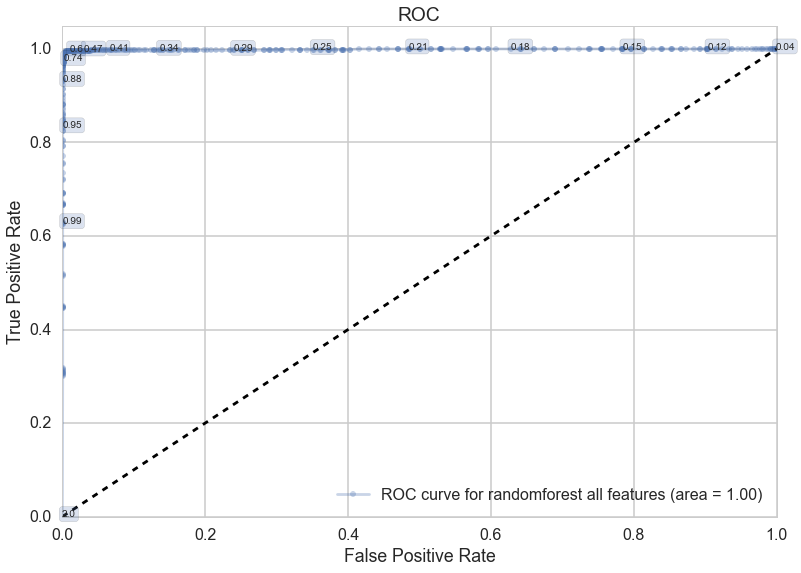

In [63]:
make_roc("randomforest all features", clfForest_all, ytest, Xtest, labe=25, skip=1);

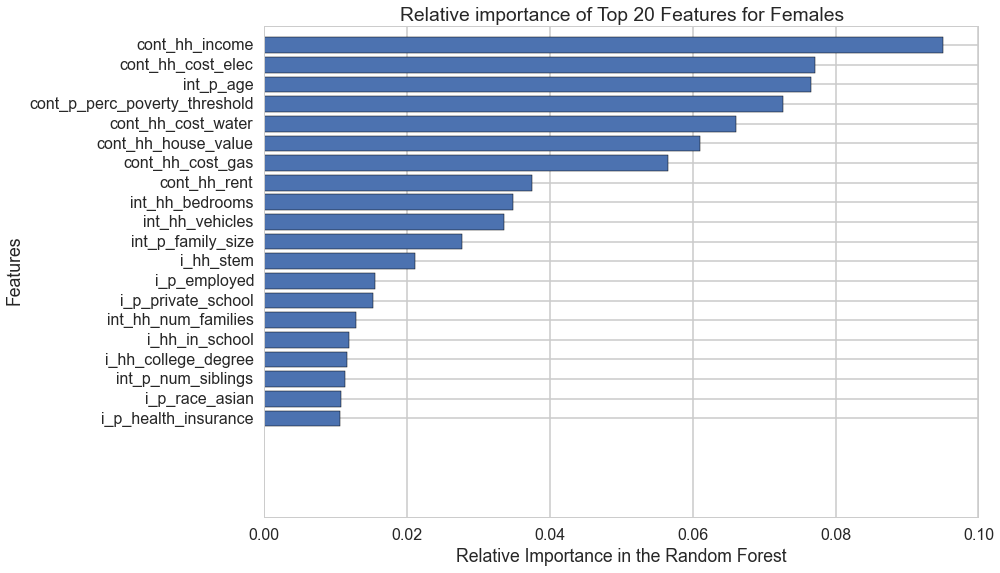

In [64]:
importance_list = clfForest_all.feature_importances_
name_list = lcols
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
# just get top (in reverse order)
top_imp = importance_list[-20:]
top_names = name_list[-20:]
plt.barh(range(len(top_names)),top_imp,align='center')
plt.yticks(range(len(top_names)),top_names)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Top 20 Features for Females')
plt.show()

The relative importance indicated that the features most influential in the random forest model were various indicators of household wealth, which interestingly enough did not emerge as major features in the logistic regression with lasso analysis. From analzying the individual trees, it appeared that the random forest was gravitating towards features that were continuous rather than binary because they provide more information to split on, calling into question the generalizability of the model to other datasets where the average income may change or increase (e.g. due to inflation).

**7.2.2 Income Only**

To investigate this issue, we tried a random forest classifier using household income as the only feature and found that it performed suspiciously well.  

In [65]:
clfForest_income_only = RandomForestClassifier(random_state=0)

parameters = {"n_estimators": range(1, 500, 50)}
clfForest_income_only, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest_income_only, parameters, 
                                                    dftomodel, ['cont_hh_income'], RESP, 1, mask=mask, 
                                                      score_func='f1')

using mask
BEST {'n_estimators': 251} 0.753170779394 [mean: 0.71617, std: 0.00776, params: {'n_estimators': 1}, mean: 0.75253, std: 0.00467, params: {'n_estimators': 51}, mean: 0.75221, std: 0.00422, params: {'n_estimators': 101}, mean: 0.75190, std: 0.00478, params: {'n_estimators': 151}, mean: 0.75295, std: 0.00396, params: {'n_estimators': 201}, mean: 0.75317, std: 0.00469, params: {'n_estimators': 251}, mean: 0.75249, std: 0.00600, params: {'n_estimators': 301}, mean: 0.75064, std: 0.00602, params: {'n_estimators': 351}, mean: 0.75158, std: 0.00574, params: {'n_estimators': 401}, mean: 0.75159, std: 0.00476, params: {'n_estimators': 451}]
############# based on standard predict ################
Accuracy on training data: 0.80
Accuracy on test data:     0.74
[[1336  737]
 [ 328 1717]]
########################################################


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


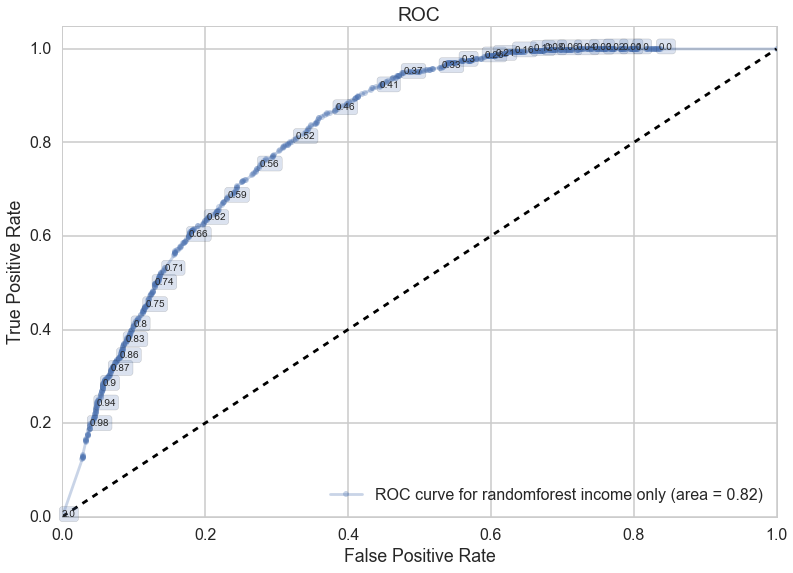

In [66]:
make_roc("randomforest income only", clfForest_income_only, ytest, Xtest, labe=25, skip=1);

**7.2.3 Key Features Only**

Given the lack of interpretability of the random forest feature importances, we decided to compromise some accuracy and use the findings from the Lasso analysis to build the random forest, with the hopes of it having more generalizeable predictive power. This random forest uses only the "important" features (as determined by the logistic regression analysis), which generally do not include any continuous variables about wealth.  

Optimizing through the hyperparameters with this subset of features, we found that the random forest performed best at about 80 trees.

In [67]:
important_features

['i_p_stem_occupation',
 'i_hh_stem',
 'i_p_speak_english',
 'i_p_veteran',
 'i_p_race_asian',
 'int_hh_num_mothers',
 'i_hh_immigrant',
 'i_p_health_insurance',
 'i_hh_linguistic_isolation',
 'i_hh_in_school',
 'i_p_race_pacific_islander',
 'i_p_have_kids',
 'i_hh_disability',
 'i_hh_have_kids',
 'i_p_private_school',
 'i_p_born_usa',
 'i_p_us_citizen',
 'i_p_employed',
 'i_hh_speak_english',
 'int_p_age']

In [68]:
# Lasso features
clfForest_main = RandomForestClassifier(random_state=0)

parameters = {"n_estimators": range(1, 100, 5)}
clfForest_main, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest_main, parameters, 
                                                    dftomodel, important_features, RESP, 1, mask=mask, 
                                                      score_func='f1')

using mask
BEST {'n_estimators': 46} 0.842774105927 [mean: 0.79314, std: 0.01141, params: {'n_estimators': 1}, mean: 0.83836, std: 0.00791, params: {'n_estimators': 6}, mean: 0.83541, std: 0.01003, params: {'n_estimators': 11}, mean: 0.83944, std: 0.00718, params: {'n_estimators': 16}, mean: 0.83795, std: 0.00881, params: {'n_estimators': 21}, mean: 0.84029, std: 0.00726, params: {'n_estimators': 26}, mean: 0.84130, std: 0.00621, params: {'n_estimators': 31}, mean: 0.84259, std: 0.00550, params: {'n_estimators': 36}, mean: 0.84199, std: 0.00602, params: {'n_estimators': 41}, mean: 0.84277, std: 0.00716, params: {'n_estimators': 46}, mean: 0.84238, std: 0.00643, params: {'n_estimators': 51}, mean: 0.84259, std: 0.00629, params: {'n_estimators': 56}, mean: 0.84183, std: 0.00701, params: {'n_estimators': 61}, mean: 0.84261, std: 0.00646, params: {'n_estimators': 66}, mean: 0.84176, std: 0.00708, params: {'n_estimators': 71}, mean: 0.84269, std: 0.00626, params: {'n_estimators': 76}, mean:

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


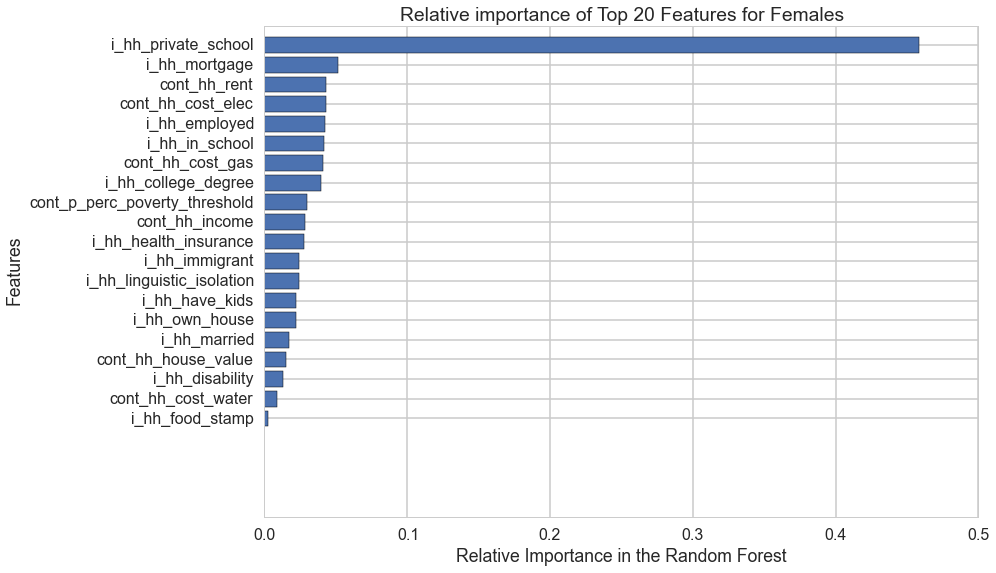

In [69]:
importance_list = clfForest_main.feature_importances_
name_list = lcols
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
# just get top (in reverse order)
top_imp = importance_list[-20:]
top_names = name_list[-20:]
plt.barh(range(len(top_names)),top_imp,align='center')
plt.yticks(range(len(top_names)),top_names)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Top 20 Features for Females')
plt.show()

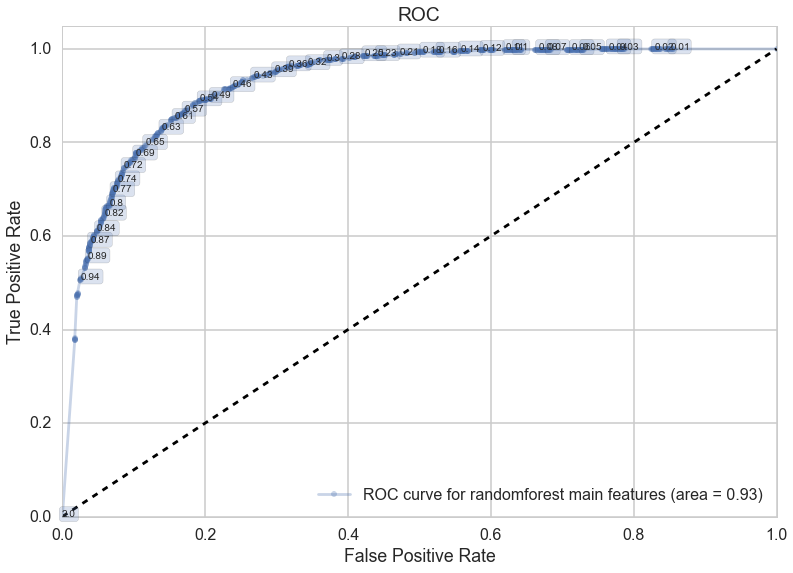

In [70]:
make_roc("randomforest main features", clfForest_main, ytest, Xtest, labe=20, skip=1);

### 7.3 Tree Ensemble Methods

We also experimented with some boosting ensemble methods but found that they did not outperform the random forest. 

**7.3.1. AdaBoost**

In [71]:
from sklearn.ensemble import AdaBoostClassifier

In [72]:
clfAda = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 500, 50)}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, 
                                                       dftomodel, important_features, RESP, 1, mask=mask, 
                                                       score_func='f1')

using mask
BEST {'n_estimators': 460} 0.605872939455 [mean: 0.57455, std: 0.01581, params: {'n_estimators': 10}, mean: 0.59886, std: 0.01693, params: {'n_estimators': 60}, mean: 0.60109, std: 0.01398, params: {'n_estimators': 110}, mean: 0.60258, std: 0.01473, params: {'n_estimators': 160}, mean: 0.60467, std: 0.01484, params: {'n_estimators': 210}, mean: 0.60506, std: 0.01579, params: {'n_estimators': 260}, mean: 0.60329, std: 0.01625, params: {'n_estimators': 310}, mean: 0.60415, std: 0.01770, params: {'n_estimators': 360}, mean: 0.60474, std: 0.01806, params: {'n_estimators': 410}, mean: 0.60587, std: 0.01813, params: {'n_estimators': 460}]
############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.61
[[1371  702]
 [ 921 1124]]
########################################################


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


**7.3.2 Gradient Boost Classifier**

In [73]:
from sklearn.ensemble import GradientBoostingClassifier

In [74]:
clfGB = GradientBoostingClassifier()

# this one takes longer - because optimizing over 2 parameters
# max_depth - because using trees as weak learners
parameters = {"n_estimators": range(10, 500, 50)}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, 
                                                       dftomodel, important_features, RESP, 1, mask=mask, 
                                                       score_func='f1')

using mask
BEST {'n_estimators': 460} 0.659813479899 [mean: 0.56091, std: 0.01369, params: {'n_estimators': 10}, mean: 0.59980, std: 0.01091, params: {'n_estimators': 60}, mean: 0.61619, std: 0.01363, params: {'n_estimators': 110}, mean: 0.63014, std: 0.01966, params: {'n_estimators': 160}, mean: 0.63970, std: 0.01904, params: {'n_estimators': 210}, mean: 0.64400, std: 0.02122, params: {'n_estimators': 260}, mean: 0.64854, std: 0.02184, params: {'n_estimators': 310}, mean: 0.64957, std: 0.01896, params: {'n_estimators': 360}, mean: 0.65655, std: 0.01667, params: {'n_estimators': 410}, mean: 0.65981, std: 0.01724, params: {'n_estimators': 460}]
############# based on standard predict ################
Accuracy on training data: 0.70
Accuracy on test data:     0.66
[[1431  642]
 [ 760 1285]]
########################################################


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


 <a id = "section8"></a>
 ## 8. Subgroup Analysis

We also decided to take a closer look at certain natural divisions between various groups of individuals. We wanted to see whether the model - particularly the most influential factors from the logistic regression model - would vary between these groups.

### 8.1 Male College Students

**8.1.1 Logistic Regression for Male College Students**

In [75]:
# use locally stored file
dftomodel_male = pd.read_csv('data/dftomodel_maleall.csv')

# use web-based file (~1.3MB)
# dftomodel_male = pd.read_csv('https://copy.com/HuFkpe8Y64KY2gdc')

dftomodel_male.drop('Unnamed: 0', axis=1, inplace=True)

In [76]:
# build training and test sets
itrain, itest = train_test_split(xrange(dftomodel_male.shape[0]), train_size=0.7, random_state=456)
mask = np.ones(dftomodel_male.shape[0], dtype='int')
mask[itrain] = 1
mask[itest] = 0
mask = (mask==1)

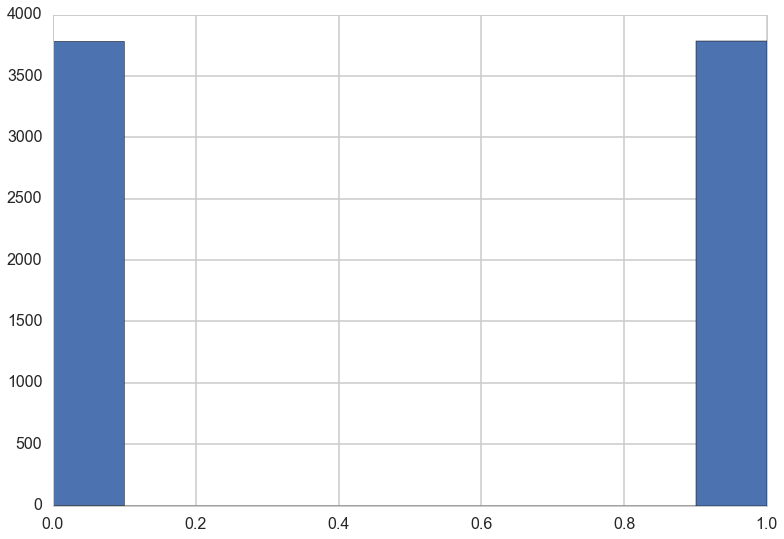

In [77]:
# drop extra variables, and look at response variable to check if balanced
dftomodel_male = dftomodel_male.drop(extra_vars, axis=1)
plt.hist(dftomodel_male[RESP]);

In [78]:
# standardize predictors
working_df = dftomodel_male[STANDARDIZABLE].copy()
dftomodel_male_standard = dftomodel_male.copy()

df_train = working_df[mask]
df_test = working_df[~mask]

std_scale = preprocessing.StandardScaler().fit(df_train)
train_std = std_scale.transform(df_train)
test_std = std_scale.transform(df_test)

working_df[mask] = train_std
working_df[~mask] = test_std

dftomodel_male_standard[STANDARDIZABLE] = working_df

In [79]:
# fit logistic regression model
clflog_male = LogisticRegression(penalty="l1", random_state=345)

parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
clflog_male, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_male, parameters, 
                                                        dftomodel_male_standard, lcols,
                                                        RESP, 1, mask=mask)

using mask
BEST {'C': 0.1} 0.553183449839 [mean: 0.49726, std: 0.00019, params: {'C': 0.0001}, mean: 0.49726, std: 0.00019, params: {'C': 0.001}, mean: 0.50879, std: 0.01377, params: {'C': 0.01}, mean: 0.55318, std: 0.03340, params: {'C': 0.1}, mean: 0.55111, std: 0.03229, params: {'C': 1}, mean: 0.55186, std: 0.03049, params: {'C': 10}, mean: 0.55148, std: 0.03064, params: {'C': 100}, mean: 0.55148, std: 0.03064, params: {'C': 1000}, mean: 0.55148, std: 0.03064, params: {'C': 10000}, mean: 0.55148, std: 0.03064, params: {'C': 100000}]
############# based on standard predict ################
Accuracy on training data: 0.59
Accuracy on test data:     0.58
[[727 422]
 [521 599]]
########################################################


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [80]:
# save dataframe of coefficients from logistic regression model obtained from CV at best "C"
coefdf_male = pd.DataFrame({
        'features': lcols,
        'male_coeffs': clflog_male.coef_[0]
        })
coefdf_male

,features,male_coeffs
0,cont_hh_cost_elec,-0.046103
1,cont_hh_cost_gas,0.010292
2,cont_hh_cost_water,0.033403
3,cont_hh_house_value,-0.028435
4,cont_hh_income,-0.027732
5,cont_hh_rent,0.003903
6,cont_p_perc_poverty_threshold,0.054069
7,i_hh_college_degree,-0.046790
8,i_hh_disability,-0.080292
9,i_hh_employed,-0.206245


In [81]:
# sort by coefficient
sortedcoef_male = coefdf_male.sort(coefdf_male.columns[1], ascending=False)
sortedcoef_male

,features,male_coeffs
22,i_hh_stem,0.555373
32,i_p_immigrant,0.282042
23,i_hh_stem_occupation,0.250406
15,i_hh_linguistic_isolation,0.194334
36,i_p_race_asian,0.191036
13,i_hh_immigrant,0.155033
38,i_p_race_hispanic,0.124084
30,i_p_have_kids,0.114022
31,i_p_health_insurance,0.084358
46,int_hh_bedrooms,0.058807


We found that being in a STEM occupation and having a household member with a STEM major are also strong (positive) indicators for male students. In addition, having a household member that works in a STEM occupation also had a higher influence for men than for women. Other influential factors included: having a household member that is an immigrant to the US and being positive for linguistic isolation (i.e. all household members 14 years or older have at least some difficulty with English). This suggests that being from an immigrant family may be associated with a higher probability of a male student majoring in STEM at college.

Turning to the negative factors, it is interesting to note that being in private school once again appears as one of the top five factors. (Perhaps these students are more likely to go into a social science like law, business or economics?)

**8.1.2 Random Forest for Male College Students**

In [82]:
clfForestmale= RandomForestClassifier()

parameters = {"n_estimators": range(1, 500, 50)}
clfForestmale, Xtrain, ytrain, Xtest, ytest = do_classify(clfForestmale, parameters, dftomodel_male, 
                                                       important_features, RESP, 1, mask=mask, score_func='f1')

using mask
BEST {'n_estimators': 51} 0.766781840482 [mean: 0.70856, std: 0.01597, params: {'n_estimators': 1}, mean: 0.76678, std: 0.01670, params: {'n_estimators': 51}, mean: 0.76487, std: 0.01952, params: {'n_estimators': 101}, mean: 0.76120, std: 0.01942, params: {'n_estimators': 151}, mean: 0.76063, std: 0.01767, params: {'n_estimators': 201}, mean: 0.76075, std: 0.01757, params: {'n_estimators': 251}, mean: 0.76033, std: 0.01681, params: {'n_estimators': 301}, mean: 0.76140, std: 0.01691, params: {'n_estimators': 351}, mean: 0.76335, std: 0.01693, params: {'n_estimators': 401}, mean: 0.76321, std: 0.01764, params: {'n_estimators': 451}]
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.76
[[822 327]
 [226 894]]
########################################################


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


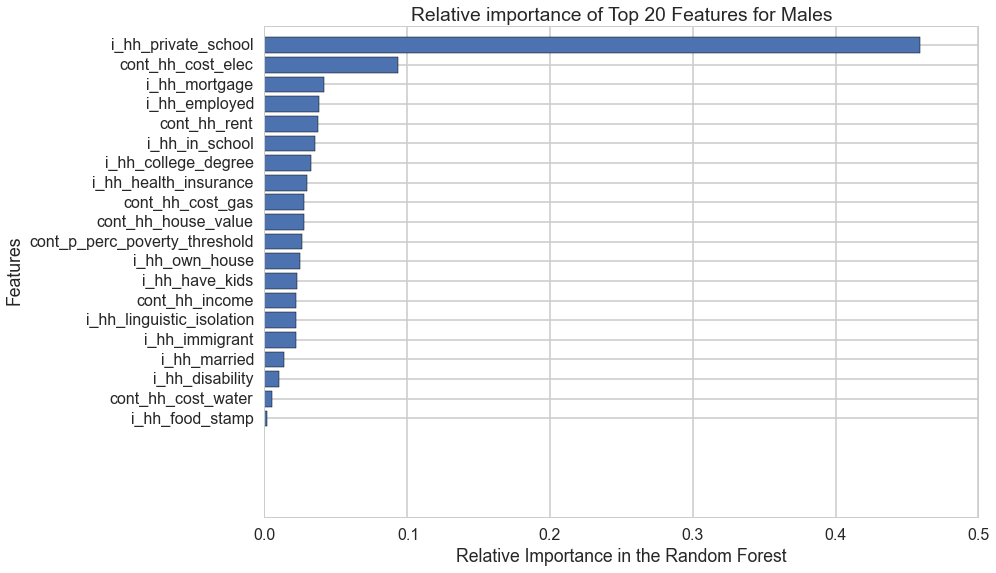

In [83]:
mimportance_list = clfForestmale.feature_importances_
mname_list = lcols
mimportance_list, mname_list = zip(*sorted(zip(mimportance_list, mname_list)))
# just get top (in reverse order)
mtop_imp = mimportance_list[-20:]
mtop_names = mname_list[-20:]
plt.barh(range(len(mtop_names)),mtop_imp,align='center')
plt.yticks(range(len(mtop_names)),mtop_names)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Top 20 Features for Males')
plt.show()

We found that our random forest model is not able to predict with as high accuracy whether a male student will choose to major in STEM or not. This could be for a number of reasons: perhaps the reasons for which men choose STEM are not captured in our data, or perhaps the factors that lead them to choose STEM majors are simply more varied.

We also tried using the random forest model trained on the female data, to see how well it would predict on the men. The resulting accuracy is barely above the 50% baseline from random choice, indicating that the predictors for men and women choosing STEM majors differ.

The confusion matrix shows that the model makes an especially high number of false negative predictions.

In [84]:
subdf = dftomodel_male[important_features]
X = subdf.values
y = (dftomodel_male[RESP].values==1)*1

print clfForest_main.score(X, y)
print confusion_matrix(y, clfForest_main.predict(X))

0.512827294367
[[3686   95]
 [3589  192]]


### 8.2 Older Female College Students

We arbitrarily chose 25 as the threshold; "older" female college students are aged 25 and older.

In [85]:
# use locally stored file
dftomodel_oldf = pd.read_csv('data/dftomodel_femaleover25.csv')

# use web-based file (~1.4MB)
# dftomodel_oldf = pd.read_csv('https://copy.com/SchpVXLISnt9hJIX')

dftomodel_oldf.drop('Unnamed: 0', axis=1, inplace=True)

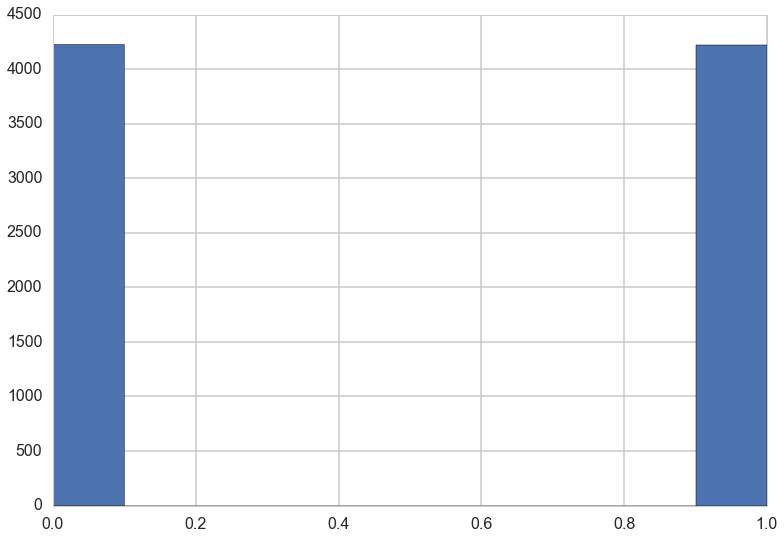

In [86]:
# drop extra variables, and look at response variable to check if balanced
dftomodel_oldf = dftomodel_oldf.drop(extra_vars, axis=1)
plt.hist(dftomodel_oldf[RESP]);

# build training and test sets
itrain, itest = train_test_split(xrange(dftomodel_oldf.shape[0]), train_size=0.7, 
                                 random_state=555)
mask = np.ones(dftomodel_oldf.shape[0], dtype='int')
mask[itrain] = 1
mask[itest] = 0
mask = (mask==1)

# standardize predictors
working_df = dftomodel_oldf[STANDARDIZABLE].copy()
dftomodel_oldf_standard = dftomodel_oldf
df_train = working_df[mask]
df_test = working_df[~mask]

std_scale = preprocessing.StandardScaler().fit(df_train)
train_std = std_scale.transform(df_train)
test_std = std_scale.transform(df_test)

working_df[mask] = train_std
working_df[~mask] = test_std

dftomodel_oldf_standard[STANDARDIZABLE] = working_df

In [87]:
# fit logistic regression model
clflog_oldf = LogisticRegression(penalty="l1", random_state=543)

parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
clflog_oldf, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_oldf, parameters, 
                                                        dftomodel_oldf_standard, lcols,
                                                        RESP, 1, mask=mask)

using mask
BEST {'C': 1000} 0.606255283178 [mean: 0.50854, std: 0.00017, params: {'C': 0.0001}, mean: 0.50854, std: 0.00017, params: {'C': 0.001}, mean: 0.60270, std: 0.02330, params: {'C': 0.01}, mean: 0.60118, std: 0.03094, params: {'C': 0.1}, mean: 0.60237, std: 0.03789, params: {'C': 1}, mean: 0.60575, std: 0.03917, params: {'C': 10}, mean: 0.60609, std: 0.03907, params: {'C': 100}, mean: 0.60626, std: 0.03922, params: {'C': 1000}, mean: 0.60626, std: 0.03922, params: {'C': 10000}, mean: 0.60626, std: 0.03922, params: {'C': 100000}]
############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.60
[[863 354]
 [671 647]]
########################################################


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [88]:
# save dataframe of coefficients from logistic regression model obtained from CV at best "C"
coefdf_oldf = pd.DataFrame({
        'features': lcols,
        'olderfemale_coeffs': clflog_oldf.coef_[0]
        })

# sort by coefficient
sortedcoef_oldf = coefdf_oldf.sort(coefdf_oldf.columns[1], ascending=False)
sortedcoef_oldf

,features,olderfemale_coeffs
22,i_hh_stem,1.041395
45,i_p_veteran,0.652733
36,i_p_race_asian,0.422515
24,i_hh_us_citizen,0.370620
33,i_p_married,0.321997
15,i_hh_linguistic_isolation,0.311586
10,i_hh_food_stamp,0.307992
50,int_hh_num_mothers,0.305261
43,i_p_speak_english,0.261400
31,i_p_health_insurance,0.245456


Four of the top five positive factors were the same; the only difference was that the indicator for the household being on food stamps replaces the indicator for speaking English.

Turning to the top negative factors, it was interesting to note that being in a multi-generational household appears to make it less likely that an "older" female student in college is majoring in STEM. Once again, the negative association of US born reinforced the message that immigrants are more likely to study STEM. It was becoming increasingly clear by this point that more needs to be done "at home" to encourage women to enter STEM fields.

### 8.3 Younger Female College Students

Using the same cut-off point, our "young" women are 25 and under.

In [89]:
# use locally stored file
dftomodel_youngf = pd.read_csv('data/dftomodel_femaleunder25.csv')

# use web-based file (~900KB)
# dftomodel_youngf = pd.read_csv('https://copy.com/FopmBDGwmw9k6n9i')

dftomodel_youngf.drop('Unnamed: 0', axis=1, inplace=True)

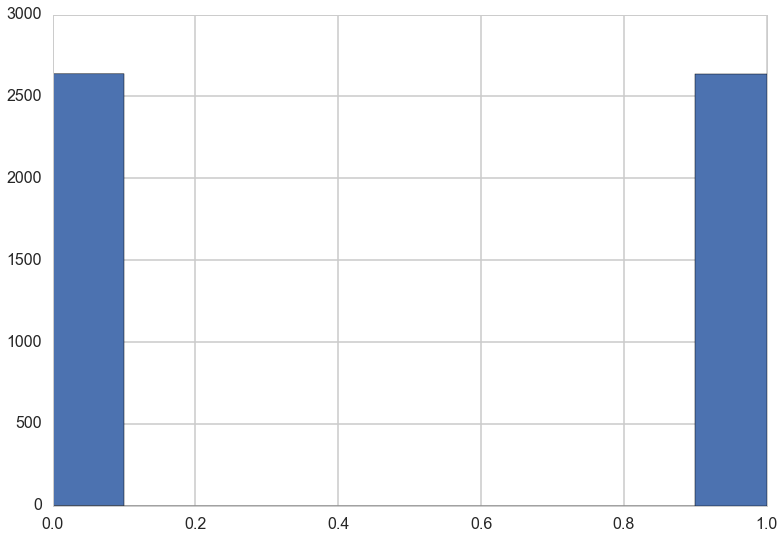

In [90]:
# drop extra variables, and look at response variable to check if balanced
dftomodel_youngf = dftomodel_youngf.drop(extra_vars, axis=1)
plt.hist(dftomodel_youngf[RESP]);

# build training and test sets
itrain, itest = train_test_split(xrange(dftomodel_youngf.shape[0]), train_size=0.7, 
                                 random_state=321)
mask = np.ones(dftomodel_youngf.shape[0], dtype='int')
mask[itrain] = 1
mask[itest] = 0
mask = (mask==1)

# standardize predictors
working_df = dftomodel_youngf[STANDARDIZABLE].copy()
dftomodel_youngf_standard = dftomodel_youngf.copy()
df_train = working_df[mask]
df_test = working_df[~mask]

std_scale = preprocessing.StandardScaler().fit(df_train)
train_std = std_scale.transform(df_train)
test_std = std_scale.transform(df_test)

working_df[mask] = train_std
working_df[~mask] = test_std

dftomodel_youngf[STANDARDIZABLE] = working_df

In [91]:
# fit logistic regression model
clflog_youngf = LogisticRegression(penalty="l1", random_state=543)

parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
clflog_youngf, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_youngf, parameters, 
                                                        dftomodel_youngf_standard, lcols,
                                                        RESP, 1, mask=mask)

using mask
BEST {'C': 100} 0.59463850528 [mean: 0.52478, std: 0.01670, params: {'C': 0.0001}, mean: 0.53371, std: 0.01534, params: {'C': 0.001}, mean: 0.53019, std: 0.01613, params: {'C': 0.01}, mean: 0.58976, std: 0.01676, params: {'C': 0.1}, mean: 0.59274, std: 0.01318, params: {'C': 1}, mean: 0.59437, std: 0.01373, params: {'C': 10}, mean: 0.59464, std: 0.01453, params: {'C': 100}, mean: 0.59383, std: 0.01523, params: {'C': 1000}, mean: 0.59383, std: 0.01525, params: {'C': 10000}, mean: 0.59410, std: 0.01472, params: {'C': 100000}]
############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.60
[[478 288]
 [352 465]]
########################################################


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [92]:
# save dataframe of coefficients from logistic regression model obtained from CV at best "C"
coefdf_youngf = pd.DataFrame({
        'features': lcols,
        'youngfemale_coeffs': clflog_youngf.coef_[0]
        })

# sort by coefficient
sortedcoef_youngf = coefdf_youngf.sort(coefdf_youngf.columns[1], ascending=False)
sortedcoef_youngf

,features,youngfemale_coeffs
45,i_p_veteran,1.501142e+00
43,i_p_speak_english,1.324531e+00
50,int_hh_num_mothers,1.154600e+00
36,i_p_race_asian,6.447041e-01
22,i_hh_stem,6.092236e-01
10,i_hh_food_stamp,5.928157e-01
48,int_hh_num_fathers,5.071210e-01
18,i_hh_own_house,4.898738e-01
21,i_hh_speak_english,4.777712e-01
31,i_p_health_insurance,3.470103e-01


We found that the top six positive factors were all the same, with the number of mothers in the household being ranked slightly higher than being of Asian descent, compared to the overall female group of all ages.

Three of the top five negative factors were also the same. It was interesting to see that young women seem less likely to be studying STEM fields if they are married (ranked sixth from the bottom) or self-employed at the time when they are in college.

 <a id = "section9"></a>
 ## 9. Prediction Tool

Armed with the knowledge from our prediction models, we set out to build a prediction tool based on the random forest model trained on all female data. 

When testing it, we found that it tends to favor predicting a non-STEM major choice. Even if we input "yes" for most of the positive correlated features, the resulting probability is still just barely above 50%.

In [93]:
important_features

['i_p_stem_occupation',
 'i_hh_stem',
 'i_p_speak_english',
 'i_p_veteran',
 'i_p_race_asian',
 'int_hh_num_mothers',
 'i_hh_immigrant',
 'i_p_health_insurance',
 'i_hh_linguistic_isolation',
 'i_hh_in_school',
 'i_p_race_pacific_islander',
 'i_p_have_kids',
 'i_hh_disability',
 'i_hh_have_kids',
 'i_p_private_school',
 'i_p_born_usa',
 'i_p_us_citizen',
 'i_p_employed',
 'i_hh_speak_english',
 'int_p_age']

In [94]:
questions = [
    'Do you currently work in a STEM-related occupation? (Y/N) ',
    'Does someone in your household work in a STEM-related occupation? (Y/N) ',
    'Do you speak English? (Y/N) ',
    'Are you a veteran? (Y/N) ',
    'Are you Asian? (Y/N) ',
    'Did you grow up with one or more mothers in your household? (Y/N) ',
    'Is anyone in your household an immigrant? (Y/N) ',
    'Do you have health insurance? (Y/N) ',
    'Are you the only one that speaks English in your household? (Y/N) ',
    'Is anyone else in your household currently in school? (Y/N) ',
    'Are you a Pacific islander? (Y/N) ',
    'Do you have children of your own? (Y/N) ',
    'Do you have a disability? (Y/N) ',
    'Are there children in the household? (Y/N) ',
    'Did you attend private school? (Y/N) ',
    'Were you born in the US? (Y/N) ',
    'Are you a US citizen? (Y/N) ',
    'Are you currently employed? (Y/N) ',
    'Does someone in your household speak english? (Y/N) ',
    'How old are you? '
]

In [95]:
def random_forest_prediction(questions, important_features):
    
    answers = []
    
    for q in questions:
        
        a = raw_input(q)
        
        if a[0].upper() == 'Y':
            answers.append(1)
        elif a[0].upper() == 'N':
            answers.append(0)
        else:
            try:
                answers.append(int(a))
            except:
                print 'Question answer formatted incorrectly.'
                return

    result = clfForest_main.predict_proba(np.array(answers))
    prob_choosing_stem = result[0][1]
    if prob_choosing_stem >= 0.5: 
        print "You will likely choose a STEM Major in college!"
    else: 
        print "You will NOT likely choose a STEM major in college!"
        
    print "Probability: %.2f" % prob_choosing_stem        

In [96]:
random_forest_prediction(questions, important_features)

Do you currently work in a STEM-related occupation? (Y/N) N
Does someone in your household work in a STEM-related occupation? (Y/N) N
Do you speak English? (Y/N) N
Are you a veteran? (Y/N) N
Are you Asian? (Y/N) N
Did you grow up with one or more mothers in your household? (Y/N) N
Is anyone in your household an immigrant? (Y/N) N
Do you have health insurance? (Y/N) N
Are you the only one that speaks English in your household? (Y/N) N
Is anyone else in your household currently in school? (Y/N) N
Are you a Pacific islander? (Y/N) N
Do you have children of your own? (Y/N) N
Do you have a disability? (Y/N) N
Are there children in the household? (Y/N) N
Did you attend private school? (Y/N) N
Were you born in the US? (Y/N) N
Are you a US citizen? (Y/N) N
Are you currently employed? (Y/N) N
Does someone in your household speak english? (Y/N) N
How old are you? 30
You will NOT likely choose a STEM major in college!
Probability: 0.30


Our of interest, we also calculated a probability distribution of female students selecting STEM majors based on the random forest classifier and the original (unbalanced) dataset. The results are shown below.

In [100]:
# in case the entire ipython notebook has not been run
# use locally stored files
df5_female = pd.read_csv('data/dftouse5female.csv')

# use web-based file (~1.3MB)
# df5_female = pd.read_csv('https://copy.com/GCYuqmNCu7pZIkyw')

df5_female.drop('Unnamed: 0', axis=1, inplace=True)

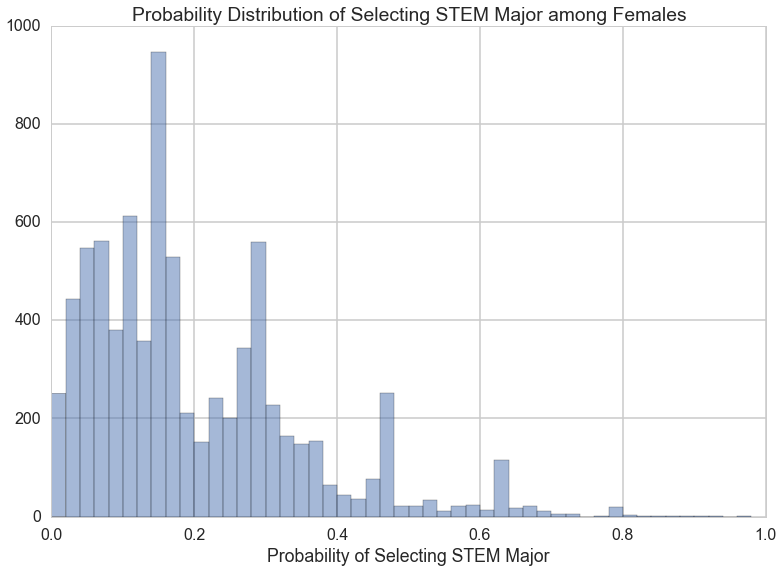

In [101]:
probs = clfForest_main.predict_proba(df5_female[important_features])
stem_1 = [item[1] for item in probs]

plt.hist(stem_1, bins=np.arange(0,1,0.02), alpha=0.5)
plt.title('Probability Distribution of Selecting STEM Major among Females')
plt.xlabel('Probability of Selecting STEM Major')
plt.show()

 <a id = "section10"></a>
 ## 10. Discussion and Takeaways

### 10.1 Summary Results

As our discussion above shows, throughout our project we experimented with a wide range of machine learning techniques in order to build predictive models of likelihood of female college students majoring in STEM subjects.

We present below a summary chart of the coefficients for the models of the four groups of college students:

* Female students, all ages (our primary group of interest)
* Male students, all ages
* Female students, over 25
* Female students, 25 and under

These coefficients are suggestive of the predictive power on the likelihood of a student studying a STEM field or not.

Please note that we are only providing point estimates here for general comparison purposes. For more exact comparisons, we could have calculated confidence intervals for these coefficients; this may be the subject of future investigation.

In [97]:
coef = pd.merge(left=coefdf, right=coefdf_male)
coef = pd.merge(left=coef, right=coefdf_oldf)
coef = pd.merge(left=coef, right=coefdf_youngf)
coef

,features,female_coeffs,male_coeffs,olderfemale_coeffs,youngfemale_coeffs
0,cont_hh_cost_elec,-0.022443,-0.046103,-0.061600,6.478512e-05
1,cont_hh_cost_gas,-0.002007,0.010292,0.029492,-1.209753e-05
2,cont_hh_cost_water,-0.051037,0.033403,0.010184,-2.234857e-04
3,cont_hh_house_value,-0.066562,-0.028435,-0.008825,-4.686180e-07
4,cont_hh_income,0.026973,-0.027732,0.031695,8.847942e-07
5,cont_hh_rent,-0.103972,0.003903,-0.156930,8.916246e-05
6,cont_p_perc_poverty_threshold,-0.065633,0.054069,0.080353,-9.627193e-04
7,i_hh_college_degree,0.072354,-0.046790,-0.072000,1.147699e-03
8,i_hh_disability,-0.270405,-0.080292,-0.192687,-2.112407e-01
9,i_hh_employed,-0.079161,-0.206245,0.114212,-2.492039e-01


<img src ='img/compare_bars.png' width=80%>

<img src='img/highlight_table.png' width=75%>

<img src='img/horiz_bars.png' width=90%>

## 10.2 Potential Extensions

* A simplifying assumption that we made when constructing the dataset was to aggregate all characteristics related to other household members. Future work may include further analysis on the subset of data with full parental information in order to determine how (or whether) different household members influence male and female students. This is a particularly interesting question given that we have identified a clear link between household members with STEM degrees or occupations and current STEM majors.

* We focused our analysis on microdata from a single U.S. cenus. Another potential extension could be to run a similar analysis at different points in time, in order to determine whether the key predictive factors have changed over time.

## 10.3 Conclusions

In this project, we set out to determine whether we could identify characteristics that make a female college student more or less likely to major in a STEM subject. Our exploratory analysis confirmed our understanding that fewer female than male students are majoring in these subjects, and hinted at factors (e.g. ethnicity, immigration, and the presence of household members with STEM backgrounds) that may be correlated with female students' decision to study STEM.

We focused on two main categories of classifiers: Logistic Regression Models and Decision Tree and Random Forest Models. For each of these, we experimented with different variations and optimizations in order to improve the predictive performance of our models. Broadly speaking, our logistic regression models had lower predictive accuracy (~60%) but yielded clearly interpretable results that reinforced our preliminary findings from the exploratory analysis. Our decision tree and random forest models had considerably higher predictive accuracy (90%-100%!) but were less easily interpretable.

We also carried out subgroup analysis, in order to determine whether the features that we had identified for female students translated to male students, and whether they still held when splitting students based on age. We found an overlap in key features with the male students but less predictive accuracy, suggesting that male students' decisions may be either more random or influenced by factors that are not reflected in our dataset. We also found that the key features did not differ significantly when looking at specific age groups of female students.

But what does this all mean? We chose one key takeaway from this analysis: the importance of role models! Over and over again, we saw the predictive power of having a household member with a STEM degree or in a STEM occupation, suggesting that these household members are exposing the female college students to STEM fields and making them aware of the potential opportunities in those areas. This is critical - we should not only encourage girls to study STEM, but we should also encourage potential role models to teach these young women about the options that are available to them.

## 10.4 Communicating our Message

Our goal in creating our video and project website was to focus on the above higher level takeaways, in order to make the material more accessible to a non-technical audience. For this reason, we focused our attention on making intuitive, easy to understand visualizations.

**10.4.1 Website**

We chose a website design that displays all the key components on the landing page, but that also allows the user to focus in on particular areas of interest. The website can be accessed at <a href='https://stemstudy.wordpress.com/'>https://stemstudy.wordpress.com/</a>. We have included a few screenshots that illustrate the design below.

<img src='img/website1.png' style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">
<img src='img/website2.png' style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">
<img src='img/website3.png' style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">
<img src='img/website4.png' style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">
<img src='img/website5.png' style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">
<img src='img/website6.png' style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">

<p style="clear: both;">

**10.4.2 Video**

We also wanted our video to be relatively simple, so that the audience could focus on the key takeaways. In particular, we focused on one key visualization (included below) that summarises our key findings from our analysis.

Our screencast is included on our website, and can also be accessed directly <a href='https://youtu.be/kp3m9FR8lPk'>here</a>. For reference, we also included our final video script <a href='doc/video_script.md'>here</a>.

<img src='img/updated.jpg'>